In [1]:
import pandas as pd
import numpy as np
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
pd.options.display.float_format = '{:,.3f}'.format

pd.options.mode.chained_assignment = None
import seaborn as sns
%matplotlib inline
sns.set(style="whitegrid", font_scale = 1.5)
sns.set_context(rc={"lines.markersize": 10})

use_pgf = False
import matplotlib
import matplotlib.ticker as ticker
if use_pgf:
    matplotlib.use("pgf")
    matplotlib.rcParams.update({
        "pgf.texsystem": "pdflatex",
        'font.family': 'serif',
        'text.usetex': True,
        'pgf.rcfonts': False,
    })

import pickle as pkl
from matplotlib import pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})

from scipy.stats.stats import pearsonr
from scipy.stats.stats import pearsonr

from functools import reduce

In [2]:
plotdir = "../Plots/coha/"
cutoff = 10
timespan = 10
dimension = 300
mode = "CompoundAware"
#mode = "CompoundAgnostic"
new_plot_col=list(range(1820,2010,timespan))
featurefile = "../../../Compounding/coha_compounds/features_{}_{}_{}_{}.pkl".format(mode, timespan, cutoff, dimension)
compoundfile = "../../../Compounding/coha_compounds/compounds_{}_{}_{}_{}.pkl".format(mode, timespan, cutoff, dimension)
constituentsfile = "../../../Compounding/coha_compounds/constituents_CompoundAgnostic_{}_{}_{}.pkl".format(timespan, cutoff, dimension)

In [3]:
features=pd.read_csv(featurefile, sep="\t")
features['compound_rating']=''
features.loc[features.compound_mean>=4,'compound_rating']='high'
features.loc[(features.compound_mean>=2) & (features.compound_mean<4),'compound_rating']='med'
features.loc[features.compound_mean<2,'compound_rating']='low'
features.compound_rating.value_counts()

high    23
med     12
low      8
Name: compound_rating, dtype: int64

In [4]:
features

modifier             head  modifier_mean  modifier_std  head_mean  \
0           web_noun        site_noun          2.679         1.691      3.933   
1         video_noun        game_noun          4.500         0.719      5.000   
2       balance_noun       sheet_noun          3.821         0.889      3.897   
3         radio_noun     station_noun          4.655         0.957      4.345   
4          face_noun       value_noun          1.393         1.113      4.643   
5        ground_noun       floor_noun          4.655         0.658      4.700   
6           law_noun        firm_noun          4.724         0.518      3.893   
7           lip_noun     service_noun          2.033         1.251      1.750   
8        health_noun   insurance_noun          4.533         0.884      4.833   
9         chain_noun    reaction_noun          2.407         1.163      4.517   
10     graduate_noun     student_noun          4.700         0.458      5.000   
11         rock_noun      bottom_noun          0.741         0.886      3.800   
12      climate_noun      change_noun          4.897         0.305      4.828   
13         case_noun       study_noun          3.655         1.123      4.667   
14     interest_noun        rate_noun          4.345         0.992      4.690   
15       engine_noun        room_noun          4.862         0.345      5.000   
16     research_noun     project_noun          4.900         0.300      4.533   
17       credit_noun        card_noun          4.667         0.537      4.897   
18      parking_noun         lot_noun          4.833         0.373      4.767   
19        brick_noun        wall_noun          3.160         2.203      3.533   
20        speed_noun       limit_noun          4.933         0.249      4.828   
21      academy_noun       award_noun          3.130         1.632      4.696   
22       banana_noun    republic_noun          0.818         0.853      2.773   
23          box_noun      office_noun          0.560         0.821      1.640   
24        crime_noun        rate_noun          4.783         1.043      4.043   
25        fairy_noun        tale_noun          1.636         1.177      4.273   
26        glass_noun     ceiling_noun          0.667         1.016      1.000   
27       health_noun        care_noun          4.800         0.414      2.867   
28         home_noun         run_noun          2.381         1.565      3.476   
29  information_noun         age_noun          4.400         1.454      1.267   
30        music_noun    festival_noun          4.790         0.535      2.947   
31        peace_noun  conference_noun          4.667         0.637      4.417   
32        shelf_noun        life_noun          1.522         1.163      2.174   
33         tear_noun         gas_noun          2.864         1.457      4.773   
34         baby_noun       buggy_noun          4.500         1.043      3.667   
35        birth_noun        rate_noun          4.700         0.733      4.650   
36          bow_noun         tie_noun          4.250         1.238      4.688   
37     computer_noun     program_noun          4.667         0.840      4.556   
38       cotton_noun       candy_noun          1.105         1.150      4.316   
39    insurance_noun     company_noun          5.000         0.000      4.889   
40         loan_noun       shark_noun          4.579         0.961      0.579   
41         news_noun      agency_noun          4.944         0.236      3.944   
42        phone_noun        book_noun          4.300         0.865      4.400   

    head_std  compound_mean  compound_std  1830_head_prod  1840_head_prod  \
0      1.181          3.786         1.206           0.000           0.000   
1      0.000          4.600         0.611           0.000           0.000   
2      0.959          3.862         1.008           0.000           0.000   
3      0.800          4.467         0.718           0.000           0.000   
4      0.811          3.037         0.881           0.000     

In [5]:
to_add_cols=['compound_mean','compound_rating']
lmi_cols = [col for col in features.columns if 'local_mi' in col]
llr_cols = [col for col in features.columns if 'log_ratio' in col]
ppmi_cols = [col for col in features.columns if 'ppmi' in col]
sim_bw_constituents_cols = [col for col in features.columns if 'sim_bw_constituents' in col]
sim_with_head_cols = [col for col in features.columns if 'sim_with_head' in col]
sim_with_modifier_cols = [col for col in features.columns if 'sim_with_modifier' in col]
head_prod_cols = [col for col in features.columns if 'head_prod' in col]
mod_prod_cols = [col for col in features.columns if 'mod_prod' in col]
#selected_compounds=['health insurance','silver bullet','melting pot','gold mine','swimming pool','bank account']
#assert (len(lmi_cols)+len(llr_cols)+len(ppmi_cols)+len(sim_bw_constituents_cols)+len(sim_with_head_cols)+len(sim_with_modifier_cols))==(len(features.columns))

In [6]:
head_prod_df=features.set_index(["modifier", "head"])[head_prod_cols+to_add_cols]
#lmi_df=lmi_df.pct_change(axis='columns')*100
#lmi_df.columns=new_plot_col
head_prod_df.reset_index(inplace=True)
head_prod_df['compound']=head_prod_df['modifier'].str[:-5]+' '+head_prod_df['head'].str[:-5]
head_prod_df.drop(['modifier','head'],axis=1,inplace=True)
#plot_lmi_df=plot_lmi_df.loc[plot_lmi_df['compound'].isin(selected_compounds)]
head_prod_df.set_index('compound',inplace=True)
#plot_lmi_df=plot_lmi_df[plot_lmi_df.columns[10:]]
old_vars=[x.split('_')[0] for x in head_prod_df.columns if 'compound' not in x]
head_prod_df.columns=old_vars+to_add_cols
#plot_lmi_df.columns
#lmi_df.info()
head_prod_df.reset_index(inplace=True)
plot_head_prod_df=pd.melt(head_prod_df,id_vars=['compound','compound_rating','compound_mean'],
                        value_vars=old_vars)

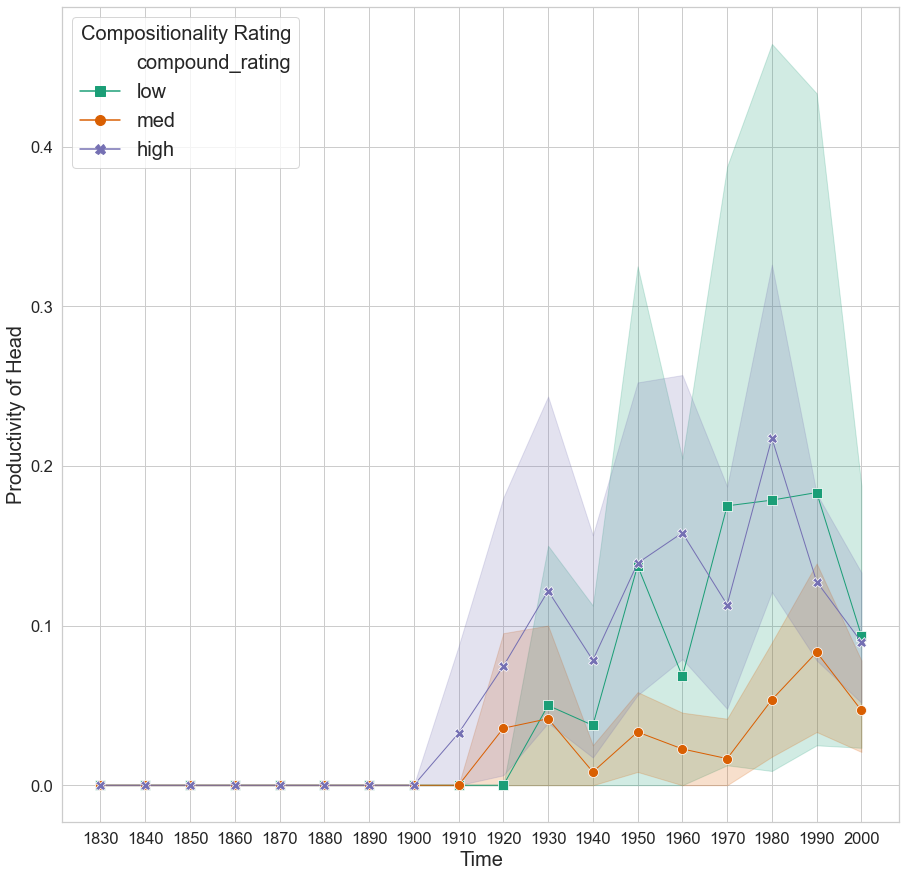

In [7]:
plt.figure(figsize=(15,15))
g=sns.lineplot(x="variable", y="value", hue="compound_rating", hue_order=["low", "med", "high"],style="compound_rating",data=plot_head_prod_df,palette="Dark2", marker='o',linewidth=1,dashes=False,markers=True)#,err_style="bars", ci=68)
g.set_xlabel("Time", fontsize=20)
g.set_ylabel("Productivity of Head", fontsize=20)
g.legend(title='Compositionality Rating', loc='upper left', fontsize=20, title_fontsize=20)
#g.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)
#g.set_xlim(1799, 2000)
plt.savefig(plotdir+'head_prod_merged_{}_{}_{}_{}.png'.format(mode, timespan, cutoff, dimension))
if use_pgf:
    plt.savefig(plotdir+'head_prod_merged_{}_{}_{}_{}.pgf'.format(mode, timespan, cutoff, dimension))

In [8]:
mod_prod_df=features.set_index(["modifier", "head"])[mod_prod_cols+to_add_cols]
#lmi_df=lmi_df.pct_change(axis='columns')*100
#lmi_df.columns=new_plot_col
mod_prod_df.reset_index(inplace=True)
mod_prod_df['compound']=mod_prod_df['modifier'].str[:-5]+' '+mod_prod_df['head'].str[:-5]
mod_prod_df.drop(['modifier','head'],axis=1,inplace=True)
#plot_lmi_df=plot_lmi_df.loc[plot_lmi_df['compound'].isin(selected_compounds)]
mod_prod_df.set_index('compound',inplace=True)
#plot_lmi_df=plot_lmi_df[plot_lmi_df.columns[10:]]
old_vars=[x.split('_')[0] for x in mod_prod_df.columns if 'compound' not in x]
mod_prod_df.columns=old_vars+to_add_cols
#plot_lmi_df.columns
#lmi_df.info()
mod_prod_df.reset_index(inplace=True)
plot_mod_prod_df=pd.melt(mod_prod_df,id_vars=['compound','compound_rating','compound_mean'],
                        value_vars=old_vars)

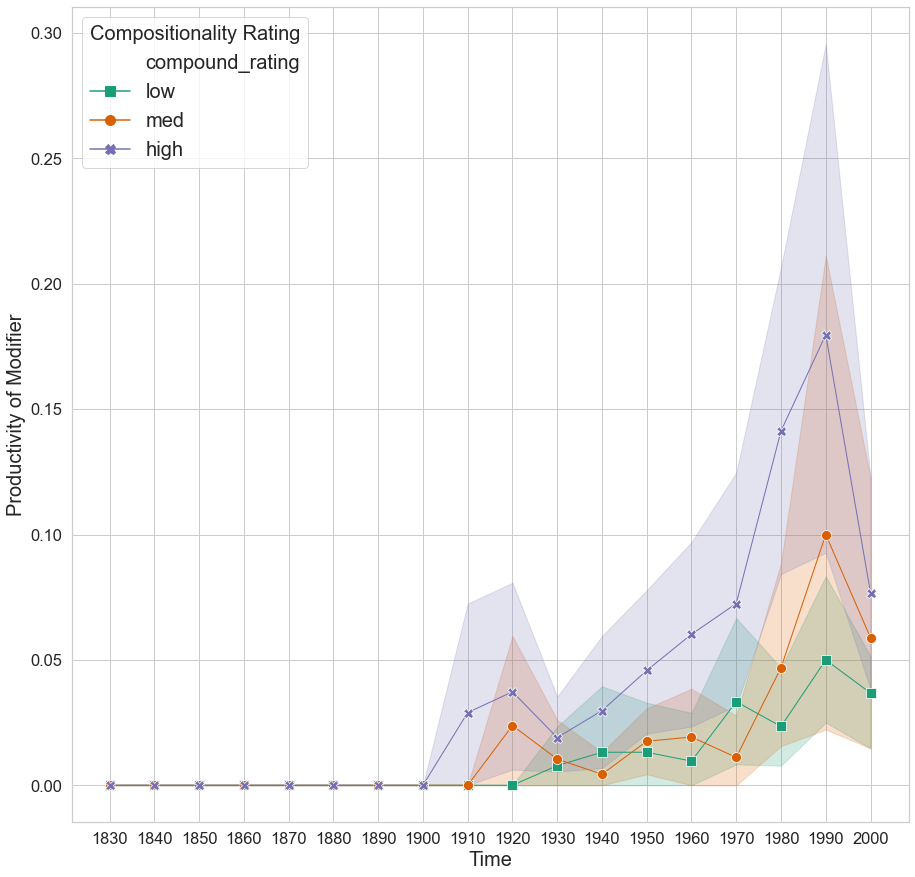

In [9]:
plt.figure(figsize=(15,15))
g=sns.lineplot(x="variable", y="value", hue="compound_rating", hue_order=["low", "med", "high"],style="compound_rating",data=plot_mod_prod_df,palette="Dark2", marker='o',linewidth=1,dashes=False,markers=True)#,err_style="bars", ci=68)
g.set_xlabel("Time", fontsize=20)
g.set_ylabel("Productivity of Modifier", fontsize=20)
g.legend(title='Compositionality Rating', loc='upper left', fontsize=20, title_fontsize=20)
#g.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)
#g.set_xlim(1799, 2000)
plt.savefig(plotdir+'modprod_merged_{}_{}_{}_{}.png'.format(mode, timespan, cutoff, dimension))
if use_pgf:
    plt.savefig(plotdir+'modprod_merged_{}_{}_{}_{}.pgf'.format(mode, timespan, cutoff, dimension))

In [10]:
lmi_df=features.set_index(["modifier", "head"])[lmi_cols+to_add_cols]
#lmi_df=lmi_df.pct_change(axis='columns')*100
#lmi_df.columns=new_plot_col
lmi_df.reset_index(inplace=True)
lmi_df['compound']=lmi_df['modifier'].str[:-5]+' '+lmi_df['head'].str[:-5]
lmi_df.drop(['modifier','head'],axis=1,inplace=True)
#plot_lmi_df=plot_lmi_df.loc[plot_lmi_df['compound'].isin(selected_compounds)]
lmi_df.set_index('compound',inplace=True)
#plot_lmi_df=plot_lmi_df[plot_lmi_df.columns[10:]]
old_vars=[x.split('_')[0] for x in lmi_df.columns if 'compound' not in x]
lmi_df.columns=old_vars+to_add_cols
#plot_lmi_df.columns
#lmi_df.info()
lmi_df.reset_index(inplace=True)
plot_lmi_df=pd.melt(lmi_df,id_vars=['compound','compound_rating','compound_mean'],
                        value_vars=old_vars)

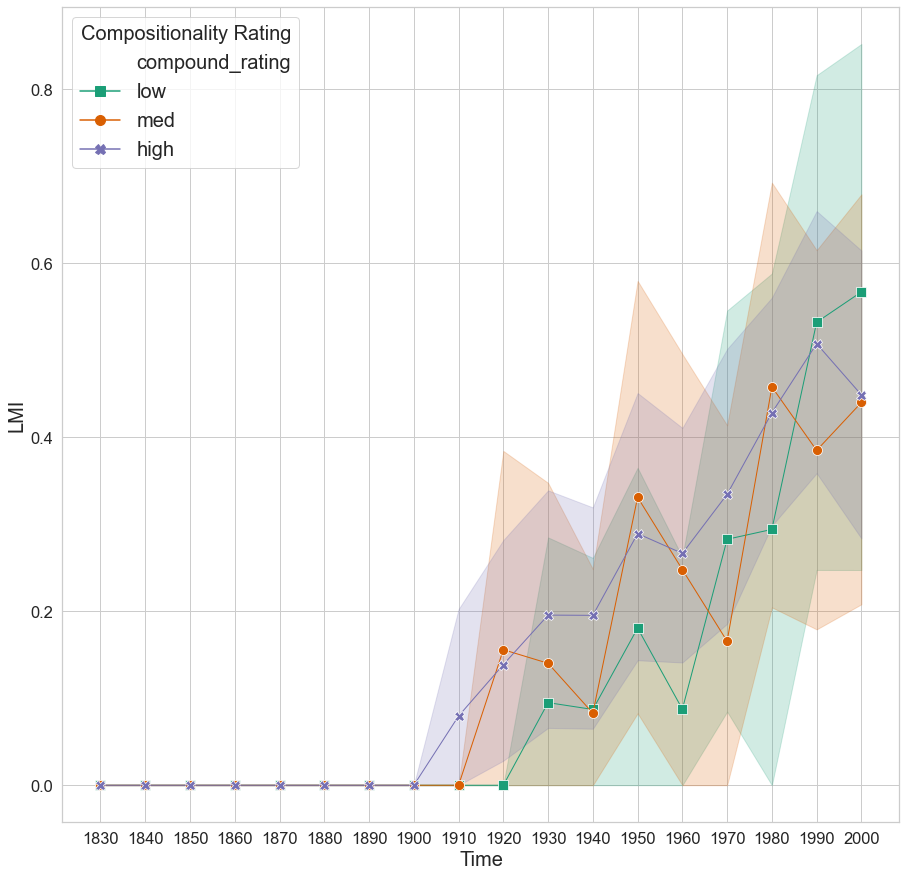

In [11]:
plt.figure(figsize=(15,15))
g=sns.lineplot(x="variable", y="value", hue="compound_rating", hue_order=["low", "med", "high"],style="compound_rating",data=plot_lmi_df,palette="Dark2", marker='o',linewidth=1,dashes=False,markers=True)#,err_style="bars", ci=68)
g.set_xlabel("Time", fontsize=20)
g.set_ylabel("LMI", fontsize=20)
g.legend(title='Compositionality Rating', loc='upper left', fontsize=20, title_fontsize=20)
#g.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)
#g.set_xlim(1799, 2000)
plt.savefig(plotdir+'LMI_merged_{}_{}_{}_{}.png'.format(mode, timespan, cutoff, dimension))
if use_pgf:
    plt.savefig(plotdir+'LMI_merged_{}_{}_{}_{}.pgf'.format(mode, timespan, cutoff, dimension))

In [12]:
llr_df=features.set_index(["modifier", "head"])[llr_cols+to_add_cols]
#lmi_df=lmi_df.pct_change(axis='columns')*100
#lmi_df.columns=new_plot_col
llr_df.reset_index(inplace=True)
llr_df['compound']=llr_df['modifier'].str[:-5]+' '+llr_df['head'].str[:-5]
llr_df.drop(['modifier','head'],axis=1,inplace=True)
#plot_lmi_df=plot_lmi_df.loc[plot_lmi_df['compound'].isin(selected_compounds)]
llr_df.set_index('compound',inplace=True)
#plot_lmi_df=plot_lmi_df[plot_lmi_df.columns[10:]]
old_vars=[x.split('_')[0] for x in llr_df.columns if 'compound' not in x]
llr_df.columns=old_vars+to_add_cols
#plot_lmi_df.columns
#lmi_df.info()
llr_df.reset_index(inplace=True)
plot_llr_df=pd.melt(llr_df,id_vars=['compound','compound_rating','compound_mean'],
                        value_vars=old_vars)

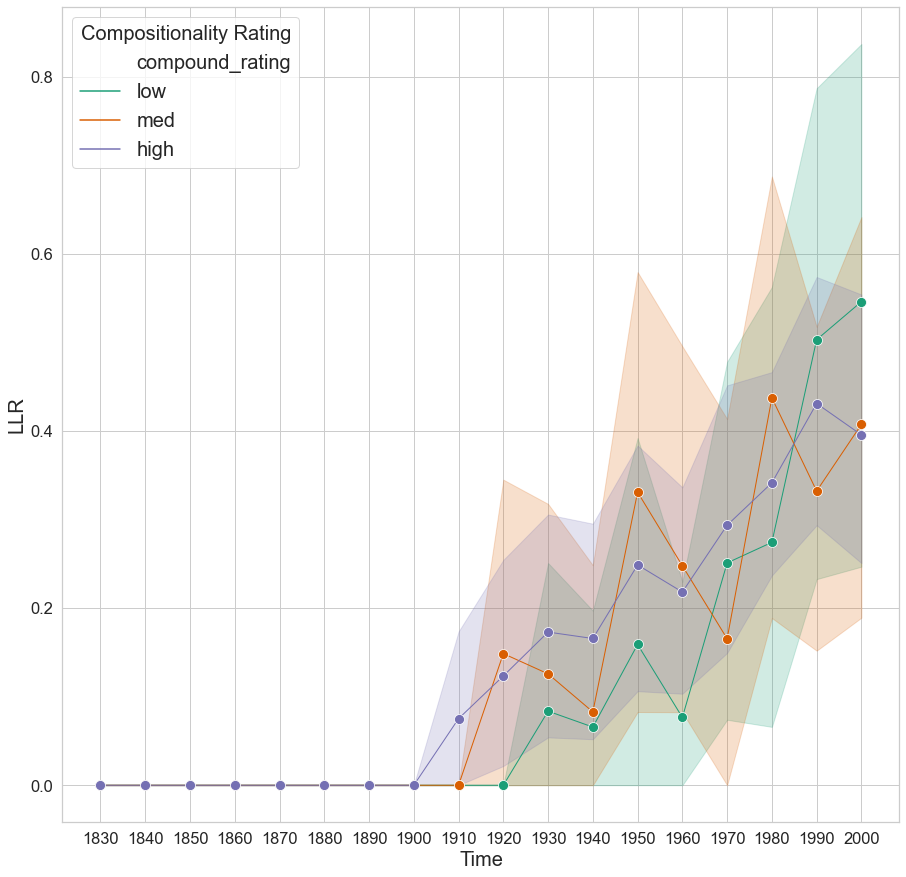

In [13]:
plt.figure(figsize=(15,15))
g=sns.lineplot(x="variable", y="value", hue="compound_rating", hue_order=["low", "med", "high"],style="compound_rating",data=plot_llr_df,palette="Dark2", marker='o',linewidth=1,dashes=False)#,err_style="bars", ci=68)
g.set_xlabel("Time", fontsize=20)
g.set_ylabel("LLR", fontsize=20)
g.legend(title='Compositionality Rating', loc='upper left', fontsize=20, title_fontsize=20)
#g.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)
#g.set_xlim(1799, 2000)
plt.savefig(plotdir+'LLR_merged_{}_{}_{}_{}.png'.format(mode, timespan, cutoff, dimension))
if use_pgf:
    plt.savefig(plotdir+'LLR_merged_{}_{}_{}_{}.pgf'.format(mode, timespan, cutoff, dimension))

In [14]:
ppmi_df=features.set_index(["modifier", "head"])[ppmi_cols+to_add_cols]
#lmi_df=lmi_df.pct_change(axis='columns')*100
#lmi_df.columns=new_plot_col
ppmi_df.reset_index(inplace=True)
ppmi_df['compound']=ppmi_df['modifier'].str[:-5]+' '+ppmi_df['head'].str[:-5]
ppmi_df.drop(['modifier','head'],axis=1,inplace=True)
#plot_lmi_df=plot_lmi_df.loc[plot_lmi_df['compound'].isin(selected_compounds)]
ppmi_df.set_index('compound',inplace=True)
#plot_lmi_df=plot_lmi_df[plot_lmi_df.columns[10:]]
old_vars=[x.split('_')[0] for x in ppmi_df.columns if 'compound' not in x]
ppmi_df.columns=old_vars+to_add_cols
#plot_lmi_df.columns
#lmi_df.info()
ppmi_df.reset_index(inplace=True)
plot_ppmi_df=pd.melt(ppmi_df,id_vars=['compound','compound_rating','compound_mean'],
                        value_vars=old_vars)

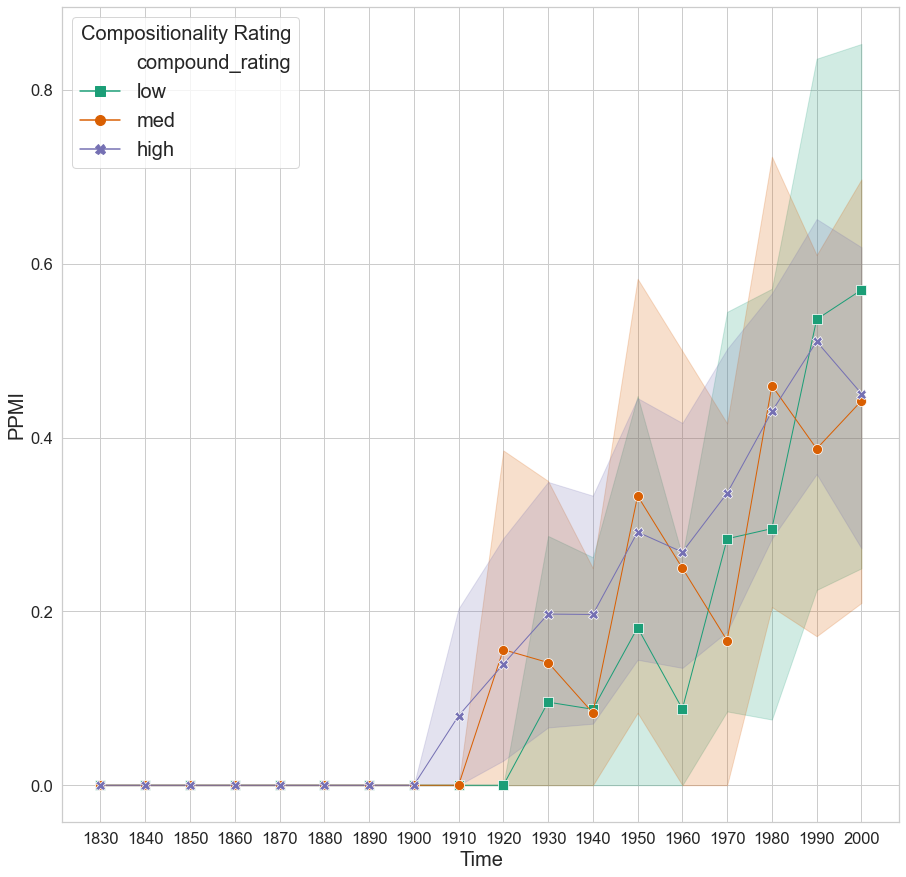

In [15]:
plt.figure(figsize=(15,15))
g=sns.lineplot(x="variable", y="value", hue="compound_rating", hue_order=["low", "med", "high"],style="compound_rating",data=plot_ppmi_df,palette="Dark2", marker='o',linewidth=1,dashes=False,markers=True)#,err_style="bars", ci=68)
g.set_xlabel("Time", fontsize=20)
g.set_ylabel("PPMI", fontsize=20)
g.legend(title='Compositionality Rating', loc='upper left', fontsize=20, title_fontsize=20)
#g.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)
#g.set_xlim(1799, 2000)
plt.savefig(plotdir+'PPMI_merged_{}_{}_{}_{}.png'.format(mode, timespan, cutoff, dimension))
if use_pgf:
    plt.savefig(plotdir+'PPMI_merged_{}_{}_{}_{}.pgf'.format(mode, timespan, cutoff, dimension))

In [16]:
sim_bw_constituents_df=features.set_index(["modifier", "head"])[sim_bw_constituents_cols+to_add_cols]
#lmi_df=lmi_df.pct_change(axis='columns')*100
#lmi_df.columns=new_plot_col
sim_bw_constituents_df.reset_index(inplace=True)
sim_bw_constituents_df['compound']=sim_bw_constituents_df['modifier'].str[:-5]+' '+sim_bw_constituents_df['head'].str[:-5]
sim_bw_constituents_df.drop(['modifier','head'],axis=1,inplace=True)
#plot_lmi_df=plot_lmi_df.loc[plot_lmi_df['compound'].isin(selected_compounds)]
sim_bw_constituents_df.set_index('compound',inplace=True)
#plot_lmi_df=plot_lmi_df[plot_lmi_df.columns[10:]]
old_vars=[x.split('_')[0] for x in sim_bw_constituents_df.columns if 'compound' not in x]
sim_bw_constituents_df.columns=old_vars+to_add_cols
#plot_lmi_df.columns
#lmi_df.info()
sim_bw_constituents_df.reset_index(inplace=True)
plot_sim_bw_constituents_df=pd.melt(sim_bw_constituents_df,id_vars=['compound','compound_rating','compound_mean'],
                        value_vars=old_vars)

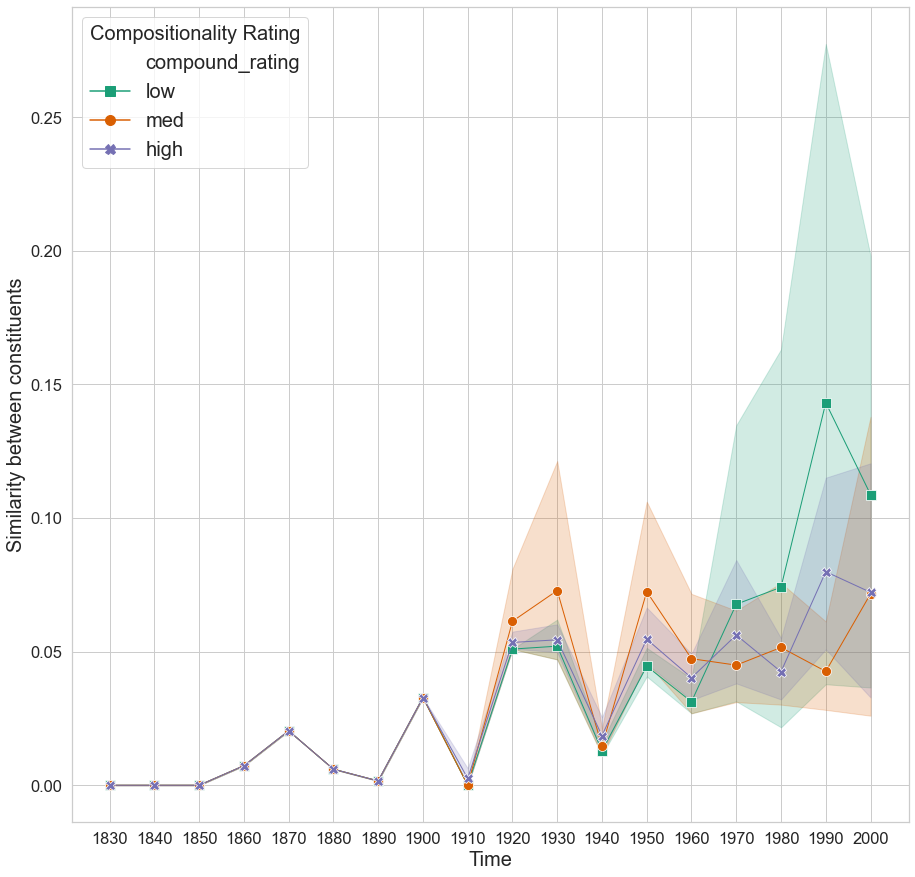

In [17]:
plt.figure(figsize=(15,15))
g=sns.lineplot(x="variable", y="value", hue="compound_rating", hue_order=["low", "med", "high"],style="compound_rating",data=plot_sim_bw_constituents_df,palette="Dark2", marker='o',linewidth=1,dashes=False,markers=True)#,err_style="bars", ci=68)
g.set_xlabel("Time", fontsize=20)
g.set_ylabel("Similarity between constituents", fontsize=20)
g.legend(title='Compositionality Rating', loc='upper left', fontsize=20, title_fontsize=20)
#g.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)
#g.set_xlim(1799, 2000)
plt.savefig(plotdir+'sim-bw-const_merged_{}_{}_{}_{}.png'.format(mode, timespan, cutoff, dimension))
if use_pgf:
    plt.savefig(plotdir+'sim-bw-const_merged_{}_{}_{}_{}.pgf'.format(mode, timespan, cutoff, dimension))

In [18]:
sim_with_head_df=features.set_index(["modifier", "head"])[sim_with_head_cols+to_add_cols]
#lmi_df=lmi_df.pct_change(axis='columns')*100
#lmi_df.columns=new_plot_col
sim_with_head_df.reset_index(inplace=True)
sim_with_head_df['compound']=sim_with_head_df['modifier'].str[:-5]+' '+sim_with_head_df['head'].str[:-5]
sim_with_head_df.drop(['modifier','head'],axis=1,inplace=True)
#plot_lmi_df=plot_lmi_df.loc[plot_lmi_df['compound'].isin(selected_compounds)]
sim_with_head_df.set_index('compound',inplace=True)
#plot_lmi_df=plot_lmi_df[plot_lmi_df.columns[10:]]
old_vars=[x.split('_')[0] for x in sim_with_head_df.columns if 'compound' not in x]
sim_with_head_df.columns=old_vars+to_add_cols
#plot_lmi_df.columns
#lmi_df.info()
sim_with_head_df.reset_index(inplace=True)
plot_sim_with_head_df=pd.melt(sim_with_head_df,id_vars=['compound','compound_rating','compound_mean'],
                        value_vars=old_vars)

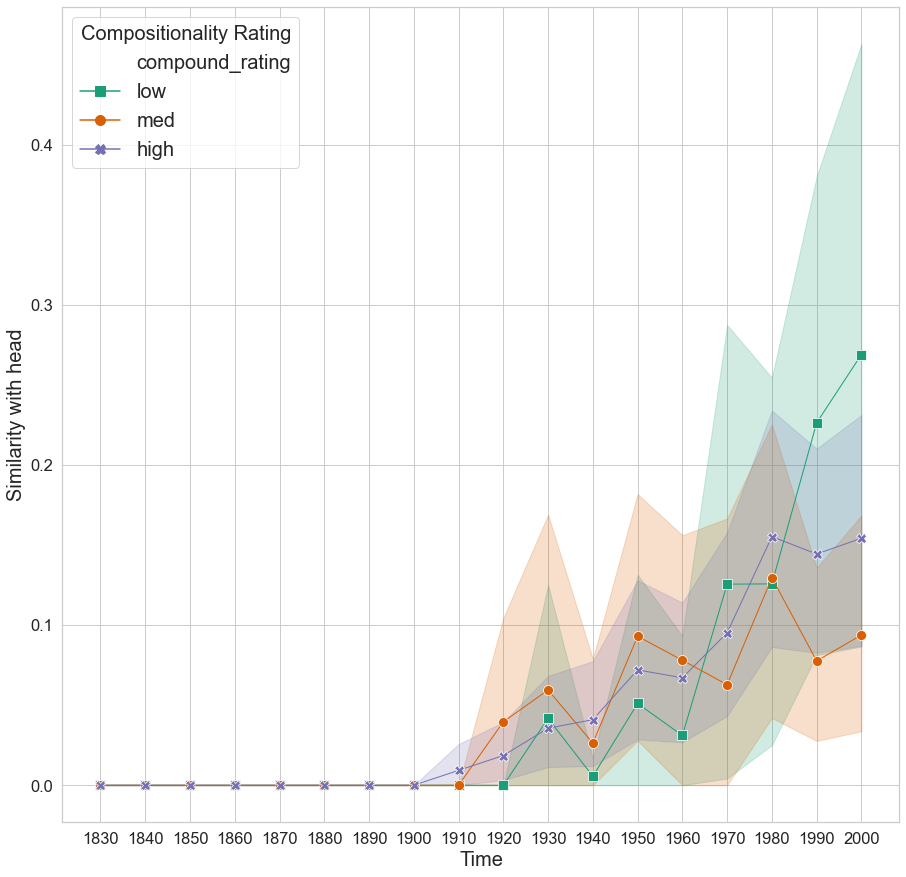

In [19]:
plt.figure(figsize=(15,15))
g=sns.lineplot(x="variable", y="value", hue="compound_rating", hue_order=["low", "med", "high"],style="compound_rating",data=plot_sim_with_head_df,palette="Dark2", marker='o',linewidth=1,dashes=False,markers=True)#,err_style="bars", ci=68)
g.set_xlabel("Time", fontsize=20)
g.set_ylabel("Similarity with head", fontsize=20)
g.legend(title='Compositionality Rating', loc='upper left', fontsize=20, title_fontsize=20)
#g.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)
#g.set_xlim(1799, 2000)
plt.savefig(plotdir+'sim-with-head_merged_{}_{}_{}_{}.png'.format(mode, timespan, cutoff, dimension))
if use_pgf:
    plt.savefig(plotdir+'sim-with-head_merged_{}_{}_{}_{}.pgf'.format(mode, timespan, cutoff, dimension))

In [20]:
sim_with_modifier_df=features.set_index(["modifier", "head"])[sim_with_modifier_cols+to_add_cols]
#lmi_df=lmi_df.pct_change(axis='columns')*100
#lmi_df.columns=new_plot_col
sim_with_modifier_df.reset_index(inplace=True)
sim_with_modifier_df['compound']=sim_with_modifier_df['modifier'].str[:-5]+' '+sim_with_modifier_df['head'].str[:-5]
sim_with_modifier_df.drop(['modifier','head'],axis=1,inplace=True)
#plot_lmi_df=plot_lmi_df.loc[plot_lmi_df['compound'].isin(selected_compounds)]
sim_with_modifier_df.set_index('compound',inplace=True)
#plot_lmi_df=plot_lmi_df[plot_lmi_df.columns[10:]]
old_vars=[x.split('_')[0] for x in sim_with_modifier_df.columns if 'compound' not in x]
sim_with_modifier_df.columns=old_vars+to_add_cols
#plot_lmi_df.columns
#lmi_df.info()
sim_with_modifier_df.reset_index(inplace=True)
plot_sim_with_modifier_df=pd.melt(sim_with_modifier_df,id_vars=['compound','compound_rating','compound_mean'],
                        value_vars=old_vars)

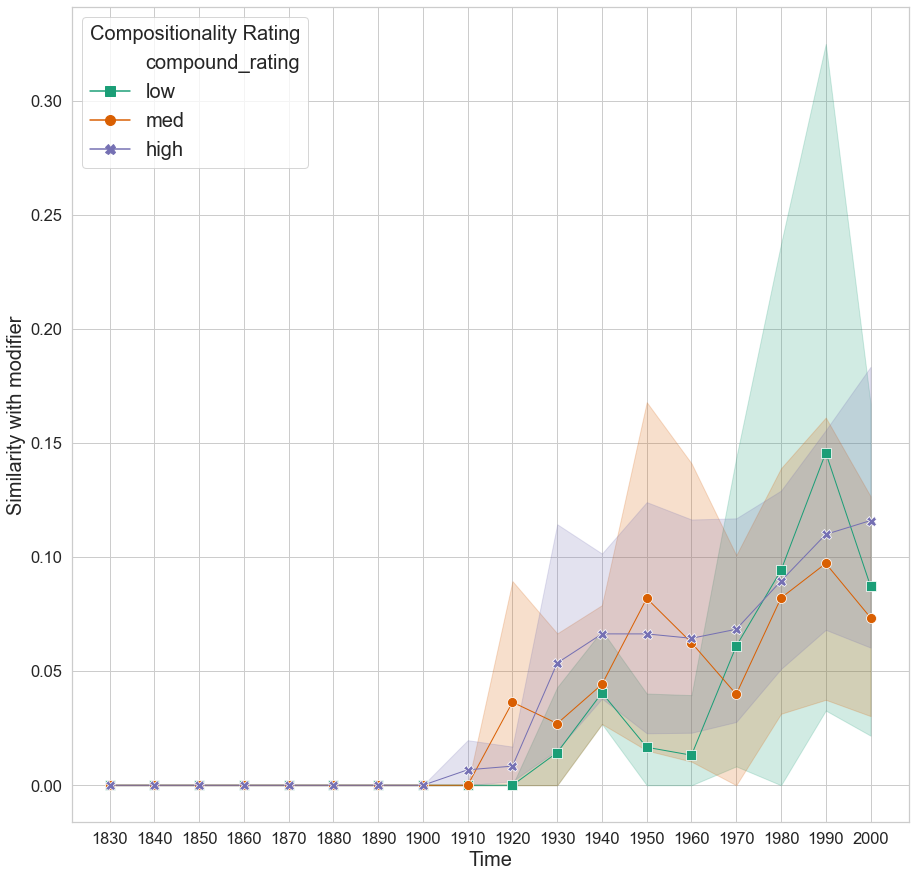

In [21]:
plt.figure(figsize=(15,15))
g=sns.lineplot(x="variable", y="value", hue="compound_rating", hue_order=["low", "med", "high"],style="compound_rating",data=plot_sim_with_modifier_df,palette="Dark2", marker='o',linewidth=1,dashes=False,markers=True)#,err_style="bars", ci=68)
g.set_xlabel("Time", fontsize=20)
g.set_ylabel("Similarity with modifier", fontsize=20)
g.legend(title='Compositionality Rating', loc='upper left', fontsize=20, title_fontsize=20)
#g.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)
#g.set_xlim(1799, 2000)
plt.savefig(plotdir+'sim-with-mod_merged_{}_{}_{}_{}.png'.format(mode, timespan, cutoff, dimension))
if use_pgf:
    plt.savefig(plotdir+'sim-with-mod_merged_{}_{}_{}_{}.pgf'.format(mode, timespan, cutoff, dimension))

In [22]:
compounds=pd.read_pickle(compoundfile)
compounds.head()

common     0     1     2  \
modifier      head        time                                                
abortion_noun reform_noun 1970  abortion_noun reform_noun 0.031 0.010 0.011   
academy_noun  award_noun  1950    academy_noun award_noun 0.056 0.019 0.008   
                          1960    academy_noun award_noun 0.051 0.018 0.005   
                          1970    academy_noun award_noun 0.035 0.012 0.009   
                          1980    academy_noun award_noun 0.079 0.032 0.010   

                                   3     4      5      6     7     8  ...  \
modifier      head        time                                        ...   
abortion_noun reform_noun 1970 0.010 0.048  0.004  0.002 0.014 0.167  ...   
academy_noun  award_noun  1950 0.007 0.053  0.001  0.001 0.006 0.145  ...   
                          1960 0.002 0.042  0.000  0.002 0.005 0.088  ...   
                          1970 0.006 0.074 -0.018 -0.006 0.004 0.169  ...   
                          1980 0.010 0.061 -0.002  0.000 0.007 0.148  ...   

                                 290    291    292    293    294    295  \
modifier      head        time                                            
abortion_noun reform_noun 1970 0.057  0.013 -0.009  0.029 -0.007 -0.036   
academy_noun  award_noun  1950 0.165 -0.028 -0.026 -0.086 -0.028  0.042   
                          1960 0.210  0.081  0.054  0.086 -0.089 -0.049   
                          1970 0.146  0.050  0.024  0.035 -0.040 -0.026   
                          1980 0.354  0.072 -0.024  0.088 -0.075 -0.014   

                                  296    297    298    299  
modifier      head        time                              
abortion_noun reform_noun 1970  0.075  0.008 -0.035  0.045  
academy_noun  award_noun  1950  0.250  0.046  0.074 -0.065  
                          1960 -0.057 -0.029 -0.049 -0.001  
                          1970 -0.021 -0.038 -0.035 -0.019  
                          1980 -0.016 -0.051 -0.051 -0.027  

[5 rows x 301 columns]

In [23]:
merge_df_aware=features[['modifier','head','compound_rating']].merge(compounds.drop(['common'],axis=1).reset_index(),on=['modifier','head'],how='inner')
merge_df_aware.set_index(["modifier", "head",'time','compound_rating'], inplace = True)
merge_df_aware.head()

0      1     2     3     4    \
modifier   head      time compound_rating                                  
web_noun   site_noun 1990 med             0.211  0.678 0.006 0.010 0.051   
                     2000 med             0.041  0.008 0.027 0.025 0.327   
video_noun game_noun 1980 high            0.020  0.005 0.014 0.012 0.063   
                     1990 high            0.014  0.003 0.010 0.007 0.041   
                     2000 high            0.281 -0.064 0.013 0.019 0.033   

                                             5      6      7     8      9    \
modifier   head      time compound_rating                                     
web_noun   site_noun 1990 med             -0.001  0.003  0.017 0.199 -0.013   
                     2000 med             -0.115 -0.015 -0.003 0.302 -0.012   
video_noun game_noun 1980 high             0.008  0.011  0.008 0.209 -0.012   
                     1990 high             0.003  0.004  0.006 0.157 -0.004   
                     2000 high             0.003  0.004 -0.009 0.216 -0.009   

                                           ...    290    291    292    293  \
modifier   head      time compound_rating  ...                               
web_noun   site_noun 1990 med              ... -0.001  0.007 -0.024 -0.061   
                     2000 med              ... -0.005 -0.037 -0.019 -0.035   
video_noun game_noun 1980 high             ...  0.007  0.001 -0.017 -0.009   
                     1990 high             ...  0.001  0.100  0.104  0.030   
                     2000 high             ...  0.151  0.089  0.060 -0.028   

                                             294    295    296    297    298  \
modifier   head      time compound_rating                                      
web_noun   site_noun 1990 med              0.021 -0.001 -0.023  0.023 -0.032   
                     2000 med             -0.001  0.007 -0.039  0.015 -0.025   
video_noun game_noun 1980 high            -0.037 -0.003 -0.002 -0.016 -0.006   
                     1990 high            -0.099  0.060 -0.052 -0.000 -0.040   
                     2000 high            -0.005  0.096  0.068  0.005 -0.116   

                                             299  
modifier   head      time compound_rating         
web_noun   site_noun 1990 med             -0.008  
                     2000 med              0.002  
video_noun game_noun 1980 high             0.004  
                     1990 high            -0.070  
                     2000 high            -0.019  

[5 rows x 300 columns]

In [24]:
def cosine(row1,row2):
    if row1.name[:-2]!=row2.name[:-2]:
        return np.nan
    else:
        denom1=np.sqrt(np.sum(np.square(row1)))
        denom2=np.sqrt(np.sum(np.square(row2)))
        num=np.sum(row1*row2)
        return num/(denom1*denom2)

In [25]:
cosine(merge_df_aware.iloc[2-1],merge_df_aware.iloc[2])

nan

In [26]:
cosine_compound_agnostic=[np.nan]
for i in range(1,merge_df_aware.shape[0]):
    cosine_compound_agnostic.append(cosine(merge_df_aware.iloc[i-1],merge_df_aware.iloc[i]))

In [27]:
merge_df_aware['compound_cosine']=cosine_compound_agnostic
compound_df=pd.pivot_table(merge_df_aware.reset_index(), values = 'compound_cosine', index=['modifier','head','compound_rating'], columns = 'time')

In [28]:
compound_df.reset_index(inplace=True)
compound_df['compound']=compound_df['modifier'].str[:-5]+' '+compound_df['head'].str[:-5]
compound_df.drop(['modifier','head'],axis=1,inplace=True)
#plot_compound_df=plot_compound_df.loc[plot_compound_df['compound'].isin(selected_compounds)]
#compound_df.set_index('compound',inplace=True)
#plot_compound_df=plot_compound_df[plot_compound_df.columns[10:]]
plot_compound_df=pd.melt(compound_df,id_vars=['compound','compound_rating'],
                        value_vars=[c for c in compound_df.columns if c not in ("compound_rating", "compound")])

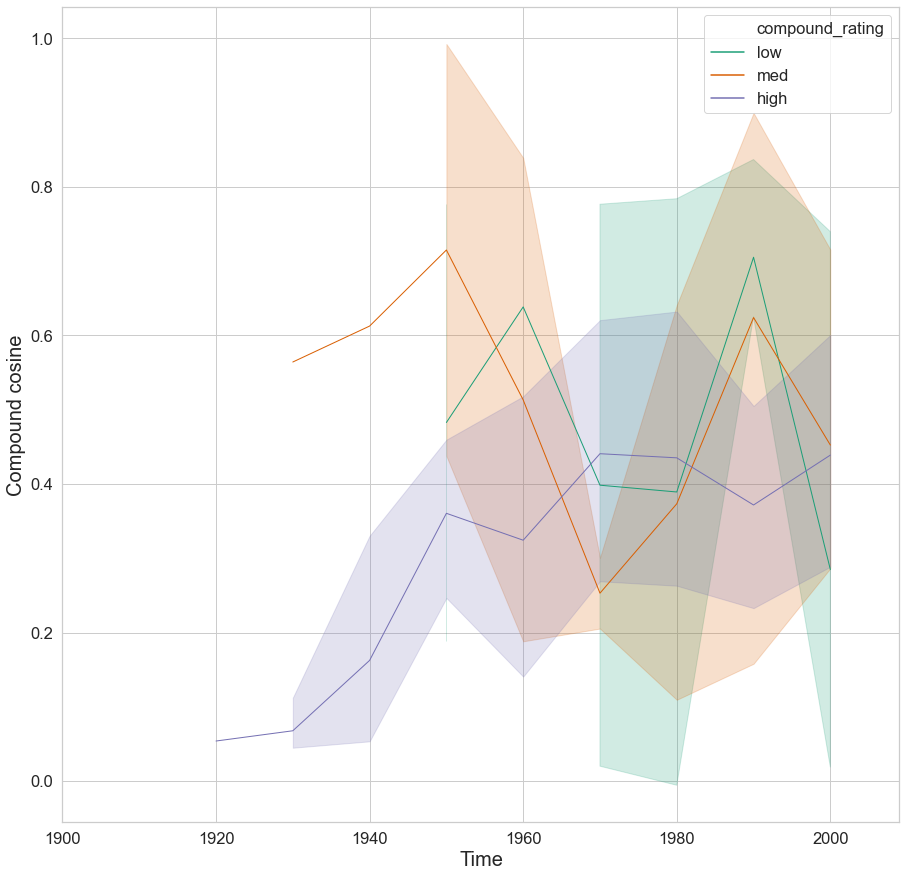

In [29]:
plt.figure(figsize=(15,15))
g=sns.lineplot(x="time", y="value", hue="compound_rating", hue_order=["low", "med", "high"],style="compound_rating",data=plot_compound_df,palette="Dark2",linewidth=1,dashes=False)#,err_style="bars", ci=68)
g.set_xlabel("Time", fontsize=20)
g.set_ylabel("Compound cosine", fontsize=20)
#g.legend(title='Compound Rating', loc='upper left', labels=["high", "low", "med"], fontsize=20, title_fontsize=20)
#g.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)
g.set_xlim(1900, 2009)
plt.savefig(plotdir+'compound-cosine_{}_{}_{}_{}.png'.format(mode, timespan, cutoff, dimension))
if use_pgf:
    plt.savefig(plotdir+'compound-cosine_{}_{}_{}_{}.pgf'.format(mode, timespan, cutoff, dimension))

In [30]:
heads=pd.read_pickle(constituentsfile)
heads.index.set_names('head',level=0,inplace=True)
heads.head()

0     1     2      3     4     5      6      7      8      9    \
head    time                                                                    
--_noun 1830 0.006 0.002 0.012 -0.003 0.011 0.010 -0.034  0.001 -0.009  0.015   
        1840 0.005 0.002 0.029  0.010 0.013 0.013 -0.044 -0.000 -0.011  0.014   
        1850 0.052 0.009 0.059 -0.013 0.062 0.084 -0.243 -0.001 -0.106 -0.080   
        1860 0.357 0.001 0.050 -0.045 0.013 0.017 -0.063  0.003 -0.034 -0.004   
        1870 0.011 0.009 0.065 -0.014 0.057 0.050 -0.187  0.001 -0.061  0.126   

              ...    290    291    292    293    294    295    296    297  \
head    time  ...                                                           
--_noun 1830  ... -0.017  0.002  0.006 -0.002  0.031 -0.020 -0.030 -0.042   
        1840  ...  0.034 -0.060  0.028  0.043 -0.001 -0.044 -0.029  0.062   
        1850  ...  0.025  0.052  0.079  0.027 -0.047 -0.004 -0.021  0.050   
        1860  ...  0.011  0.078 -0.037 -0.079  0.075  0.022  0.054  0.056   
        1870  ...  0.017  0.027  0.042 -0.044  0.002  0.017 -0.040 -0.020   

                298    299  
head    time                
--_noun 1830  0.011  0.028  
        1840 -0.044  0.046  
        1850  0.014  0.003  
        1860  0.038  0.006  
        1870 -0.085 -0.088  

[5 rows x 300 columns]

In [31]:
merge_df_aware_heads=features[['modifier','head']].merge(heads.reset_index(),on=['head'],how='inner')
merge_df_aware_heads.set_index(["modifier", "head",'time'], inplace = True)
merge_df_aware_heads.head()

0     1     2      3     4     5      6      7    \
modifier head      time                                                      
web_noun site_noun 1860 0.005 0.003 0.012  0.001 0.014 0.012 -0.034 -0.001   
                   1920 0.005 0.005 0.044 -0.029 0.056 0.024 -0.091  0.003   
                   1940 0.007 0.009 0.066 -0.034 0.045 0.046 -0.144  0.004   
                   1950 0.006 0.006 0.077 -0.047 0.040 0.041 -0.120 -0.008   
                   1960 0.012 0.005 0.046 -0.005 0.033 0.030 -0.092  0.005   

                           8     9    ...    290    291    292    293    294  \
modifier head      time               ...                                      
web_noun site_noun 1860 -0.007 0.010  ... -0.016 -0.023 -0.005  0.011  0.023   
                   1920 -0.029 0.038  ... -0.003 -0.033  0.015  0.010 -0.033   
                   1940 -0.024 0.046  ...  0.044 -0.023  0.139  0.040  0.001   
                   1950 -0.020 0.037  ...  0.003  0.087  0.037 -0.076  0.074   
                   1960 -0.020 0.045  ... -0.033  0.036  0.013  0.028  0.020   

                           295    296    297    298    299  
modifier head      time                                     
web_noun site_noun 1860 -0.026 -0.041 -0.042  0.010 -0.001  
                   1920  0.014  0.016  0.032 -0.020  0.007  
                   1940 -0.018 -0.043  0.008  0.048  0.033  
                   1950 -0.046  0.036 -0.002  0.047  0.005  
                   1960  0.006 -0.011 -0.002 -0.013  0.015  

[5 rows x 300 columns]

In [32]:
cosine_head_agnostic=[np.nan]
for i in range(1,merge_df_aware_heads.shape[0]):
    cosine_head_agnostic.append(cosine(merge_df_aware_heads.iloc[i-1],merge_df_aware_heads.iloc[i]))


In [33]:
merge_df_aware_heads['head_cosine']=cosine_head_agnostic
head_df=pd.pivot_table(merge_df_aware_heads.reset_index(), values = 'head_cosine', index=['modifier','head'], columns = 'time')

In [34]:
plot_head_df=head_df.reset_index()
plot_head_df['compound']=plot_head_df['modifier'].str[:-5]+' '+plot_head_df['head'].str[:-5]
plot_head_df.drop(['modifier','head'],axis=1,inplace=True)
plot_head_df.set_index('compound',inplace=True)

In [35]:
# Add counts
compounds=pd.read_csv("../../../Compounding/coha_compounds/compounds.csv",sep="\t")
compounds["compound"] = compounds["modifier"].str[:-5]+" "+compounds["head"].str[:-5]
compounds = compounds.groupby(["compound", "modifier", "head", "year"])[["count"]].agg("sum").reset_index()
modifiers=pd.read_csv("../../../Compounding/coha_compounds/modifiers.csv",sep="\t")
modifiers = modifiers.groupby(["modifier", "year"])[["count"]].agg("sum").reset_index()
heads=pd.read_csv("../../../Compounding/coha_compounds/heads.csv",sep="\t")
heads = heads.groupby(["head", "year"])[["count"]].agg("sum").reset_index()

In [36]:
merge_df = pd.merge(compounds, modifiers, on=["modifier", "year"])
merge_df = pd.merge(merge_df, heads, on=["head", "year"])
merge_df = merge_df[["compound","year","count_x","count_y","count"]]
merge_df.columns = ["compound_surface","year", "compound","mod","head"]
merge_df = merge_df.groupby(["compound_surface", "year"])[["compound", "mod", "head"]].agg("sum").reset_index()
merge_df = pd.melt(merge_df, id_vars=["compound_surface", "year"], var_name="type", value_name="count")
merge_df

compound_surface  year      type  count
0                     -- --  1870  compound      1
1                     -- --  1880  compound      2
2                     -- --  1910  compound      1
3                 -- cherry  2000  compound      1
4              -- community  2000  compound      2
...                     ...   ...       ...    ...
978682       zweite stadium  1890      head      1
978683  zworykin television  1980      head    246
978684        zworykin tube  1980      head    177
978685         zydeco music  1990      head    708
978686       zymase present  1980      head    109

[978687 rows x 4 columns]

In [37]:
sim_with_head_df=features.set_index(["modifier", "head"])[sim_with_head_cols]
sim_with_head_df.columns=[v.split("_")[0] for v in sim_with_head_df.columns]
plot_sim_with_head_df=sim_with_head_df.reset_index()
plot_sim_with_head_df['compound']=plot_sim_with_head_df['modifier'].str[:-5]+' '+plot_sim_with_head_df['head'].str[:-5]
plot_sim_with_head_df.drop(['modifier','head'],axis=1,inplace=True)
plot_sim_with_head_df.set_index('compound',inplace=True)
plot_sim_with_head_df = plot_sim_with_head_df.stack().reset_index()
plot_sim_with_head_df.columns=["compound", "year", "value"]
plot_sim_with_head_df['feature'] = "sim_with_head"

sim_with_mod_df=features.set_index(["modifier", "head"])[sim_with_modifier_cols]
sim_with_mod_df.columns=[v.split("_")[0] for v in sim_with_mod_df.columns]
plot_sim_with_mod_df=sim_with_mod_df.reset_index()
plot_sim_with_mod_df['compound']=plot_sim_with_mod_df['modifier'].str[:-5]+' '+plot_sim_with_mod_df['head'].str[:-5]
plot_sim_with_mod_df.drop(['modifier','head'],axis=1,inplace=True)
plot_sim_with_mod_df.set_index('compound',inplace=True)
plot_sim_with_mod_df = plot_sim_with_mod_df.stack().reset_index()
plot_sim_with_mod_df.columns=["compound", "year", "value"]
plot_sim_with_mod_df['feature'] = "sim_with_mod"

plot_sim_head_mod_df = plot_sim_with_head_df.append(plot_sim_with_mod_df)

plot_sim_head_mod_df = plot_sim_head_mod_df[plot_sim_head_mod_df.value != 0]
plot_sim_head_mod_df.year = pd.to_numeric(plot_sim_head_mod_df.year)

In [38]:
for i in plot_sim_head_mod_df.compound.unique():
    if compounds[compounds.compound == i]["count"].sum() >= 200:
        print(i, compounds[compounds.compound == i]["count"].sum())

web site 269
health insurance 488
interest rate 226
credit card 320
parking lot 260
health care 1070
tear gas 217
insurance company 239


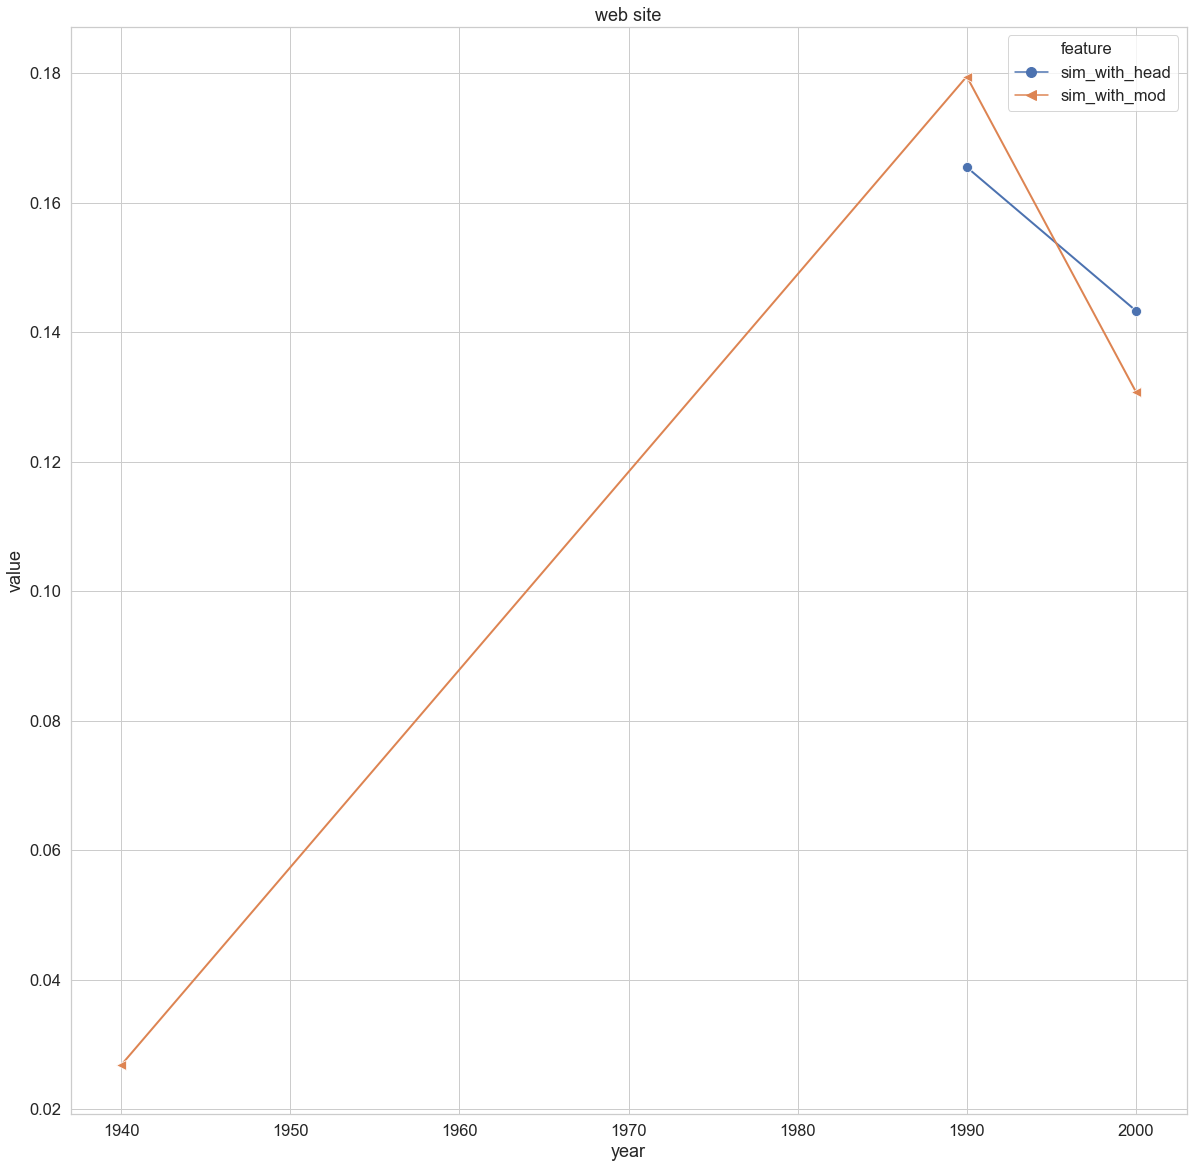

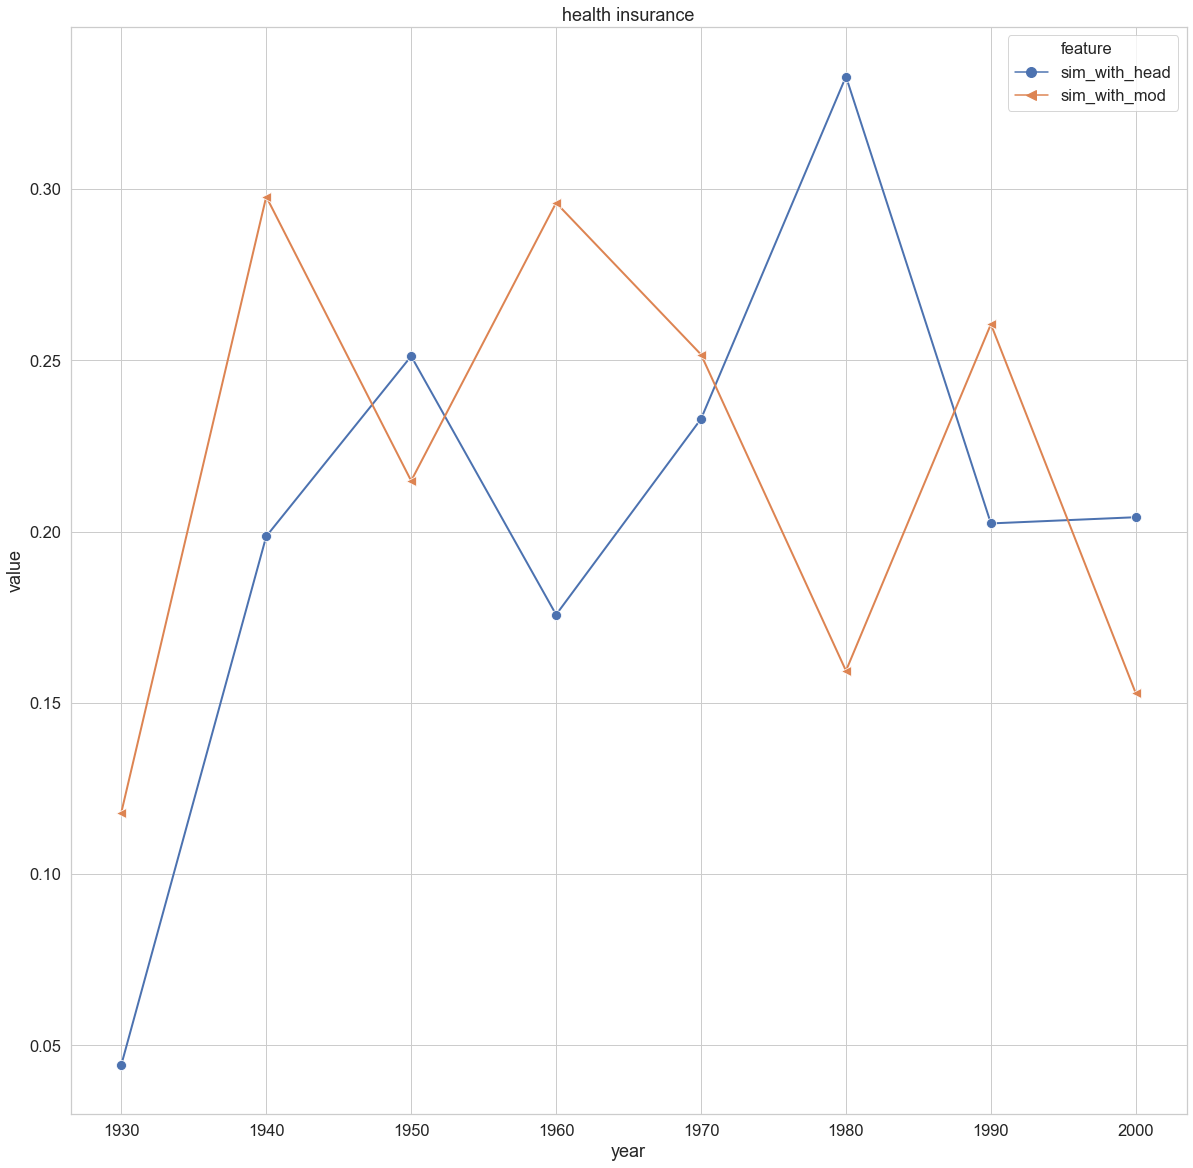

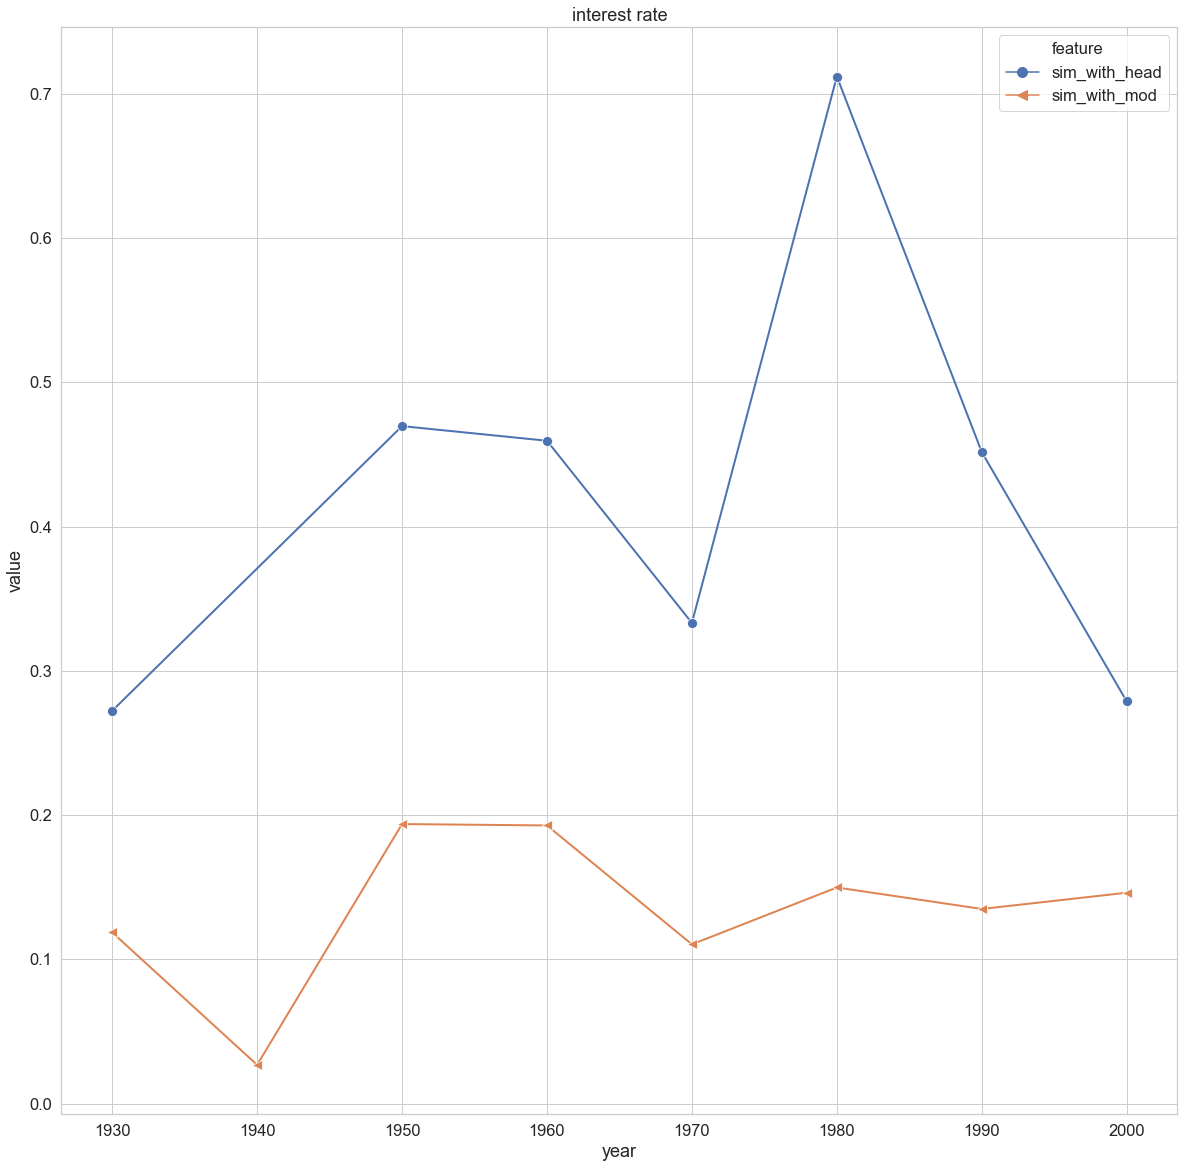

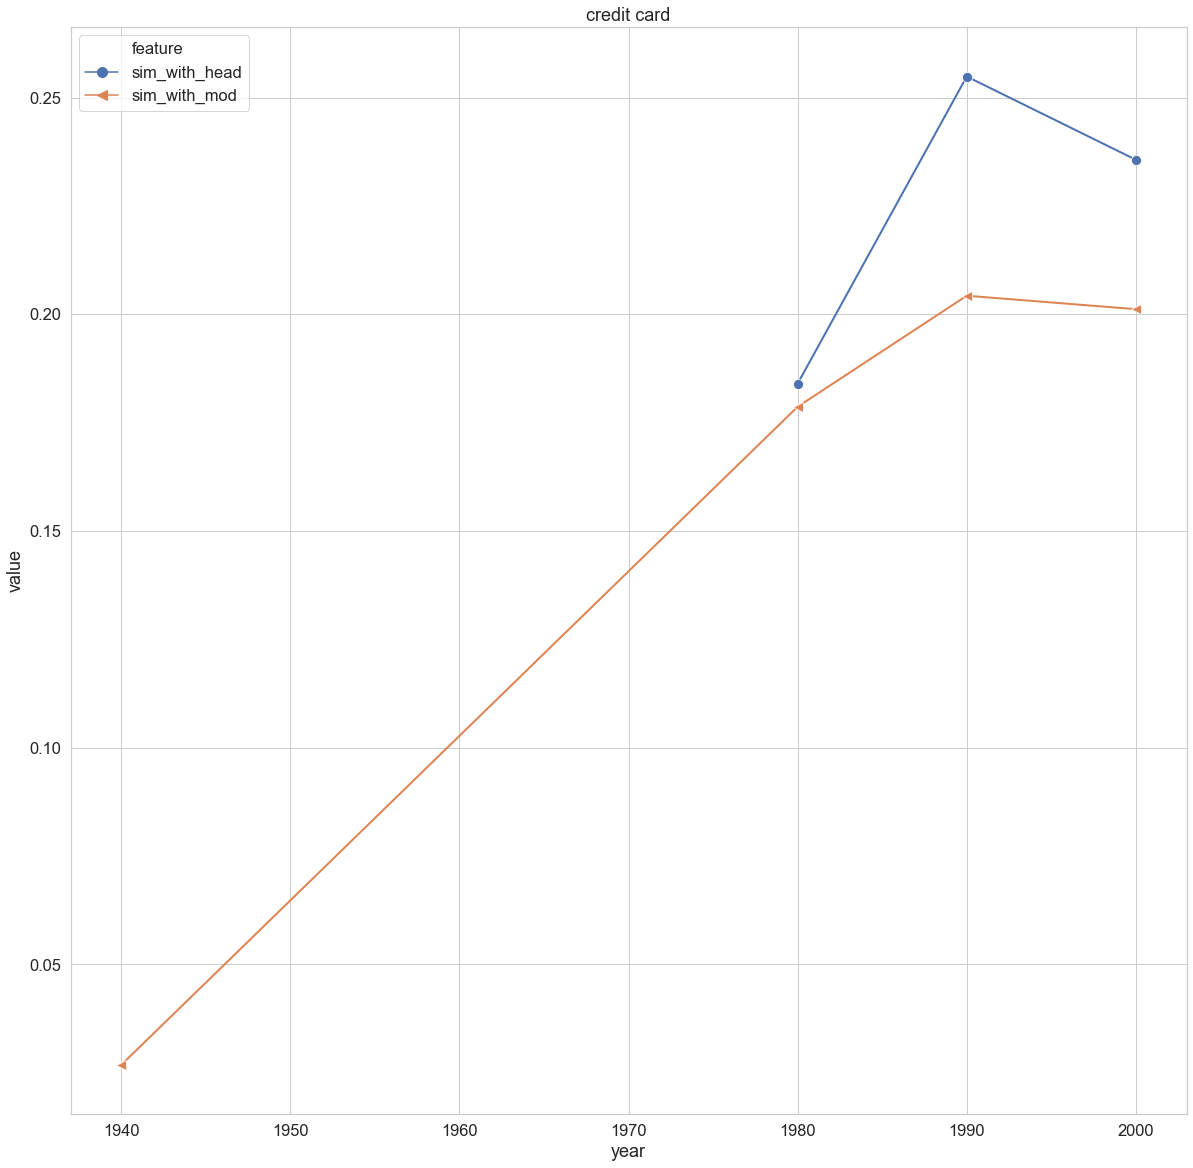

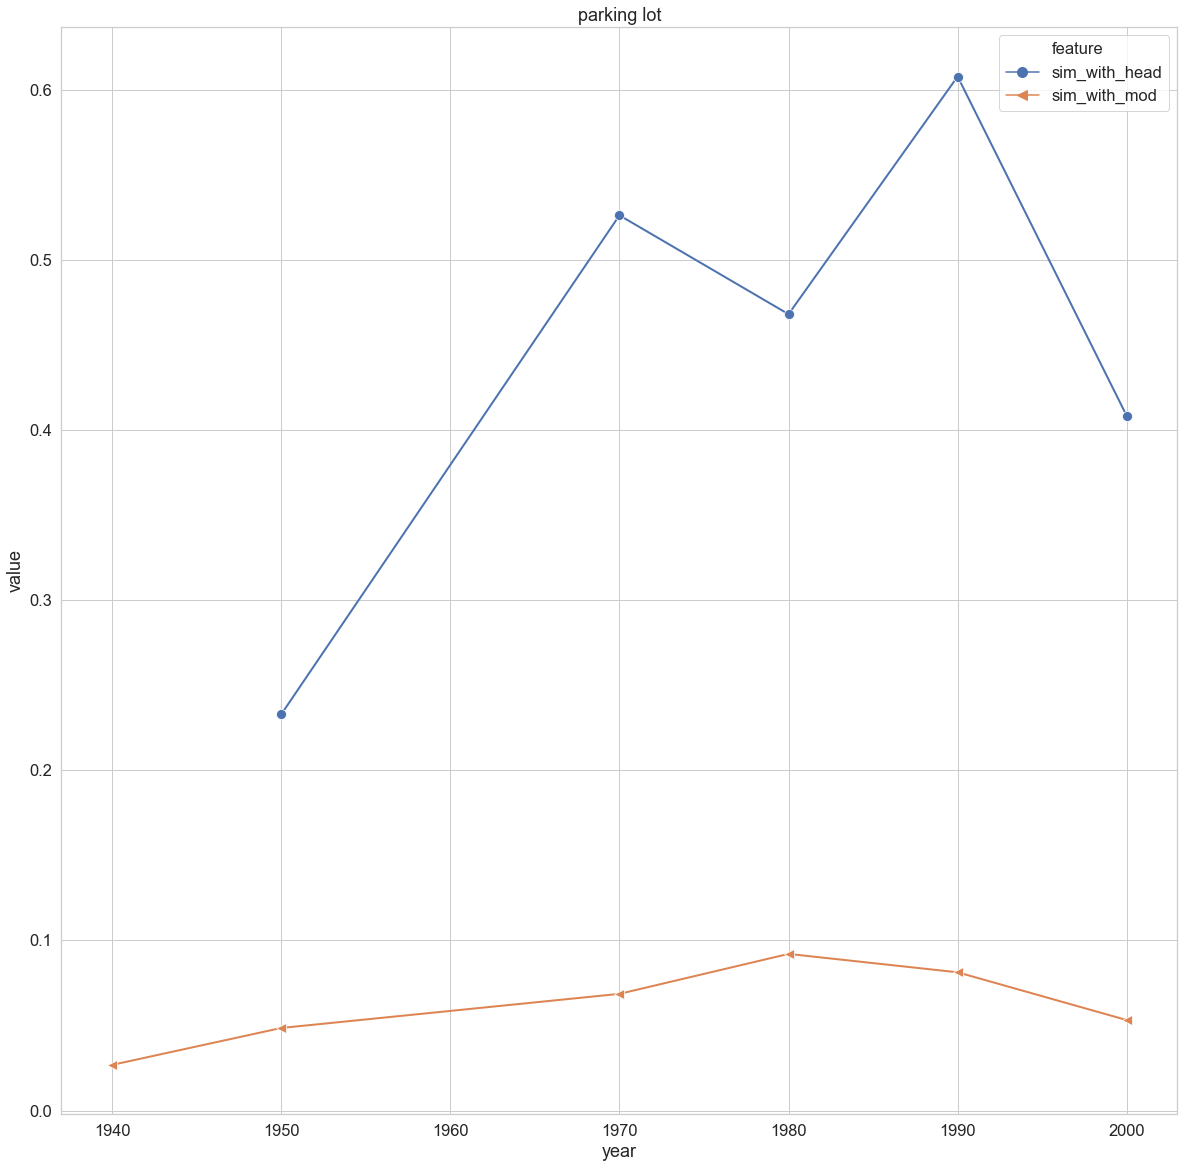

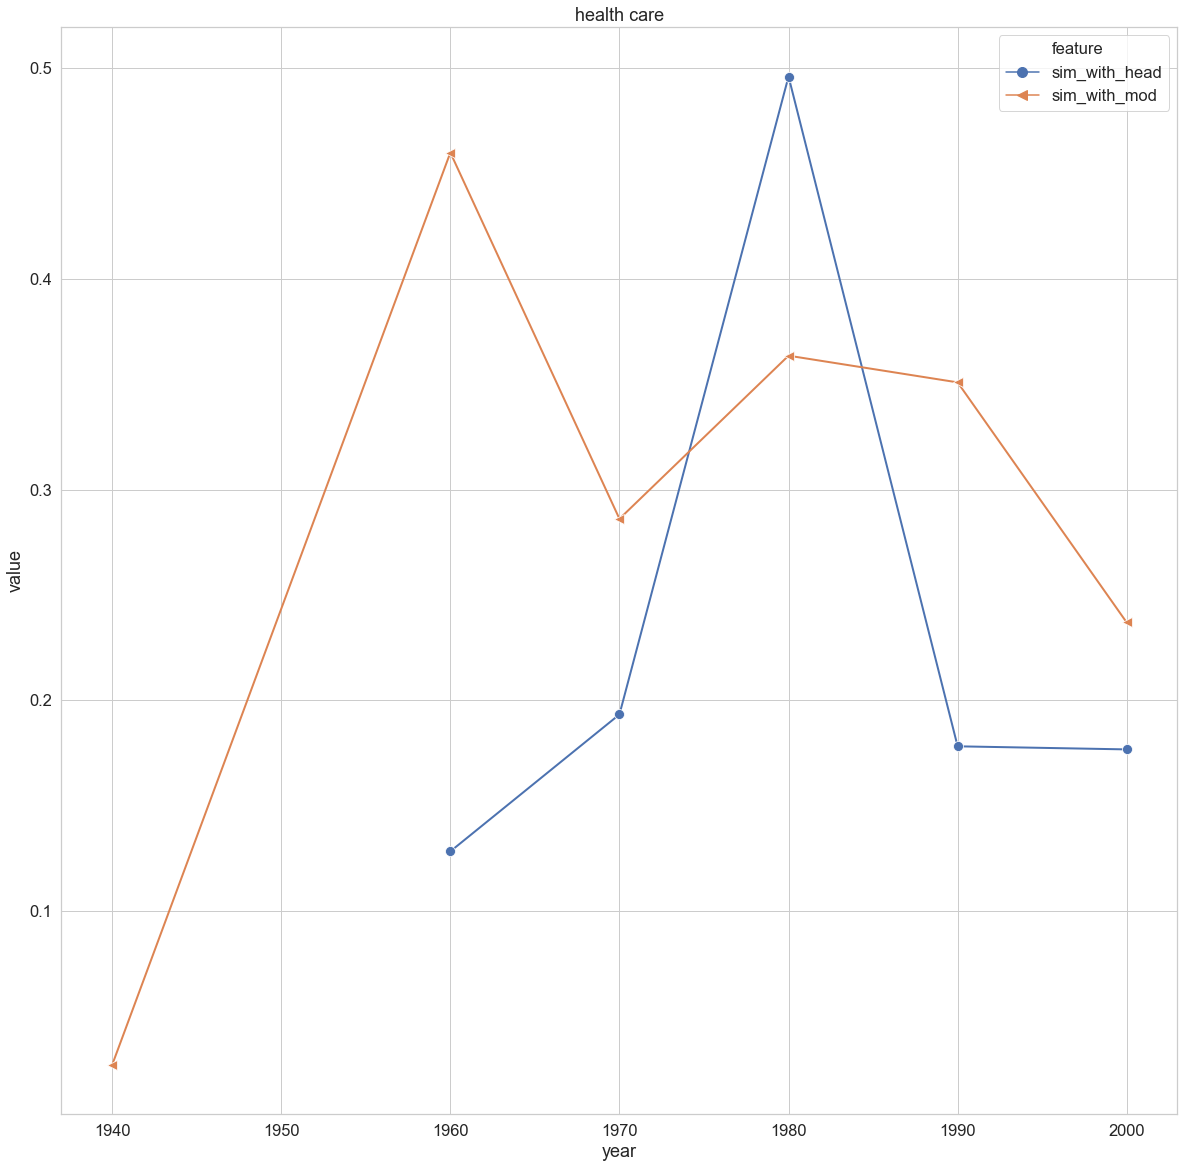

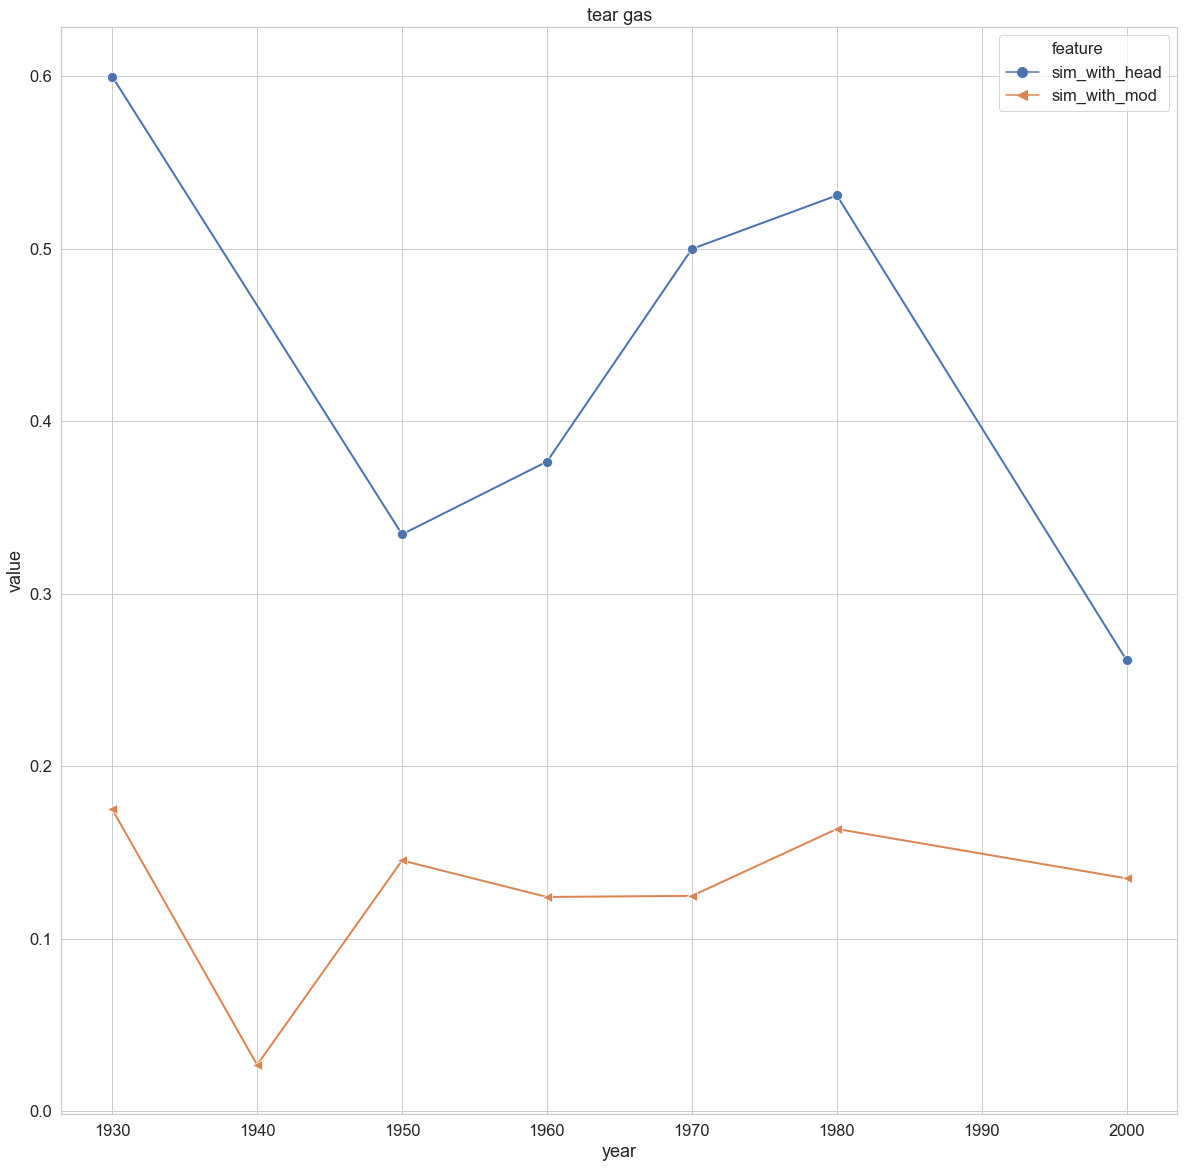

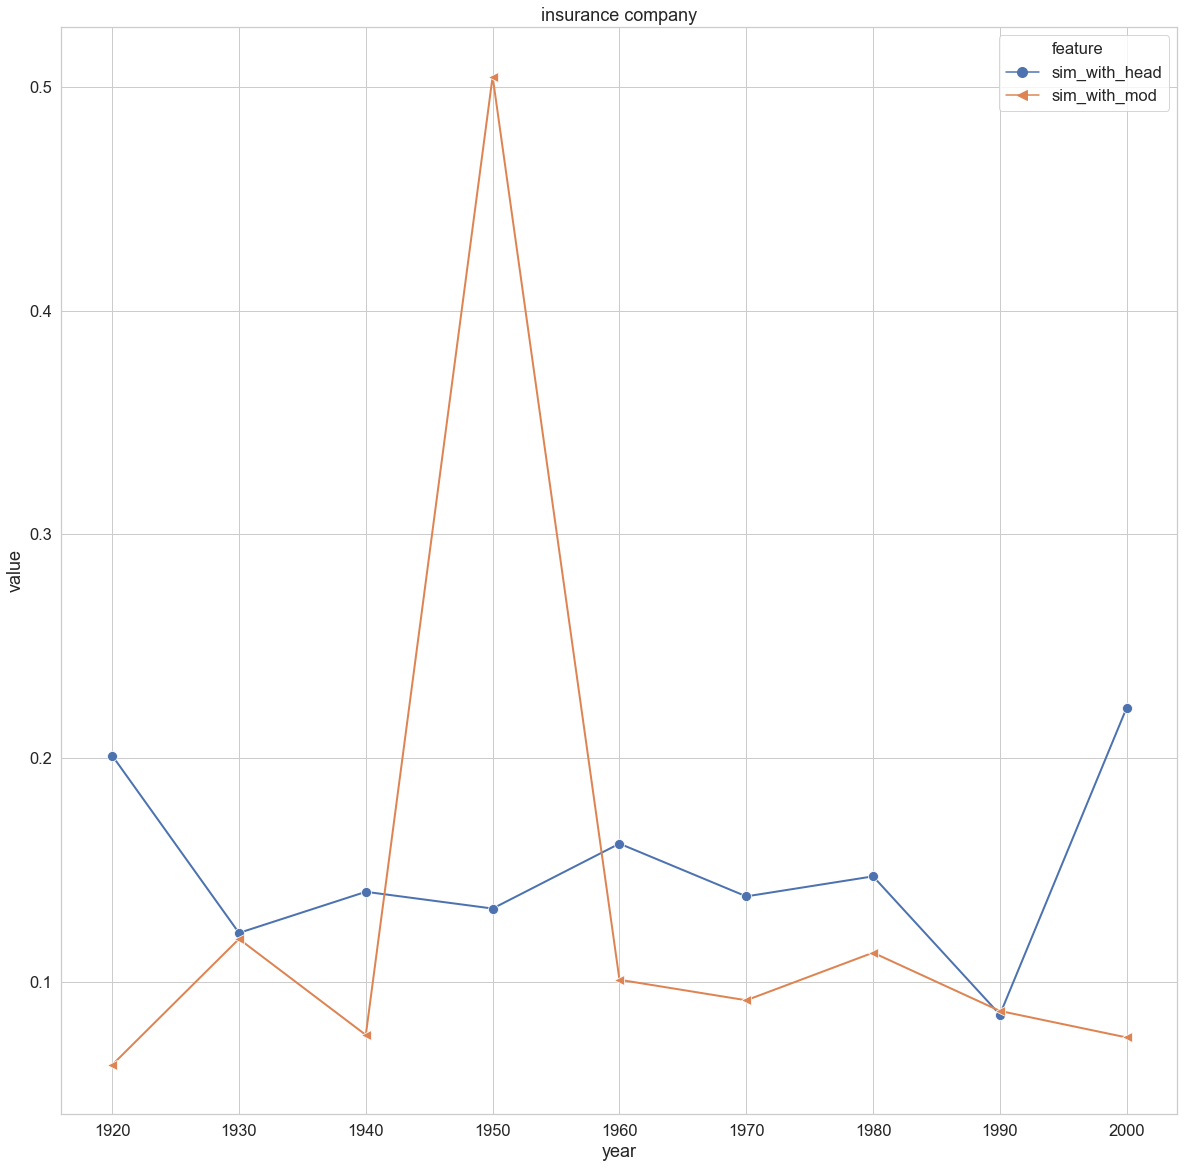

In [39]:
for i in plot_sim_head_mod_df.compound.unique():
    if compounds[compounds.compound == i]["count"].sum() >= 200:
        #fig, ax = plt.subplots(1, 2, figsize=(20,10))
        plt.figure(figsize=(20,20))
        """
        h=sns.lineplot(x = "year", y = "count", data=merge_df.loc[merge_df['compound_surface'] == i],
                      style = "type",
                      hue = "type",
                      markers=['o', '<', '>'],
                      dashes = False,
                      palette = "Paired",
                      ax = ax[0])
        h.set_title(i)
        """
        g=sns.lineplot(x = "year", y = "value", data=plot_sim_head_mod_df.loc[plot_sim_head_mod_df['compound'] == i],
                       hue = "feature",
                       style = "feature",
                       #palette="Set2", 
                       markers=['o', '<'],
                       linewidth = 2,
                       legend = "brief",
                       dashes = False,
                       sort = True,
                       #ax = ax[1]
                      )
        #g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
        #g.xaxis.set_major_locator(ticker.MultipleLocator(20))
        g.set_title(i)
        plt.savefig(plotdir+'single_compounds_sims_{}.png'.format(i))
        if use_pgf:
            plt.savefig(plotdir+'single_compounds_sims_{}.pgf'.format(i))
        plt.show()

In [40]:
mod_prod_df=features.set_index(["modifier", "head"])[mod_prod_cols]
mod_prod_df.columns=[v.split("_")[0] for v in mod_prod_df.columns]
plot_mod_prod_df=mod_prod_df.reset_index()
plot_mod_prod_df['compound']=plot_mod_prod_df['modifier'].str[:-5]+' '+plot_mod_prod_df['head'].str[:-5]
plot_mod_prod_df.drop(['modifier','head'],axis=1,inplace=True)
plot_mod_prod_df.set_index('compound',inplace=True)
plot_mod_prod_df = plot_mod_prod_df.stack().reset_index()
plot_mod_prod_df.columns=["compound", "year", "value"]
plot_mod_prod_df['feature'] = "mod_prod"

head_prod_df=features.set_index(["modifier", "head"])[head_prod_cols]
head_prod_df.columns=[v.split("_")[0] for v in head_prod_df.columns]
plot_head_prod_df=head_prod_df.reset_index()
plot_head_prod_df['compound']=plot_head_prod_df['modifier'].str[:-5]+' '+plot_head_prod_df['head'].str[:-5]
plot_head_prod_df.drop(['modifier','head'],axis=1,inplace=True)
plot_head_prod_df.set_index('compound',inplace=True)
plot_head_prod_df = plot_head_prod_df.stack().reset_index()
plot_head_prod_df.columns=["compound", "year", "value"]
plot_head_prod_df['feature'] = "head_prod"

plot_prod_head_mod_df = plot_mod_prod_df.append(plot_head_prod_df)

plot_prod_head_mod_df = plot_prod_head_mod_df[plot_prod_head_mod_df.value != 0]

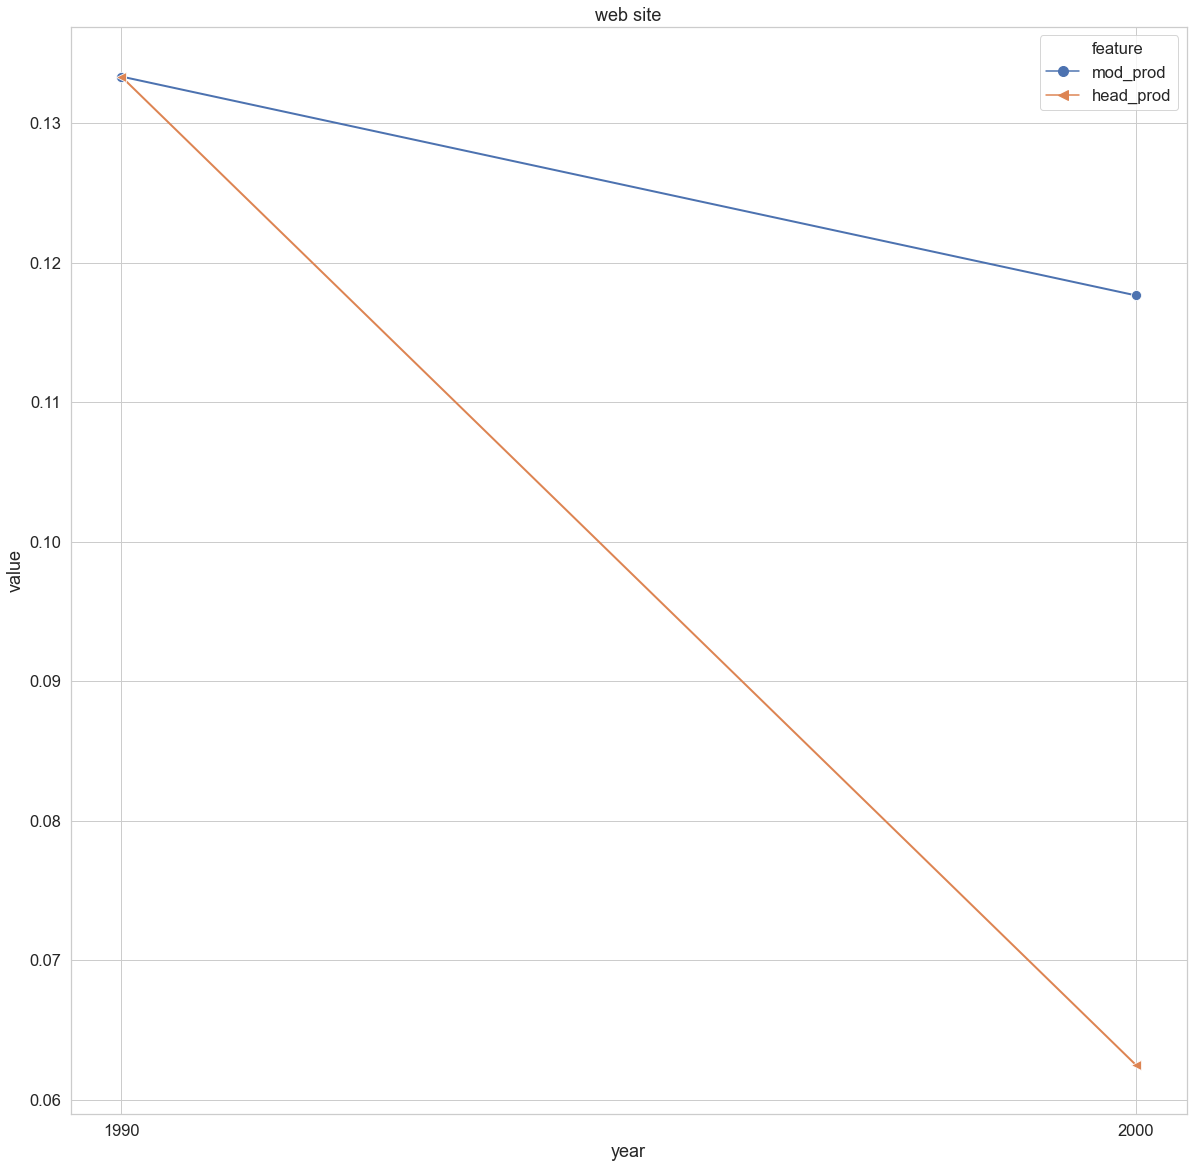

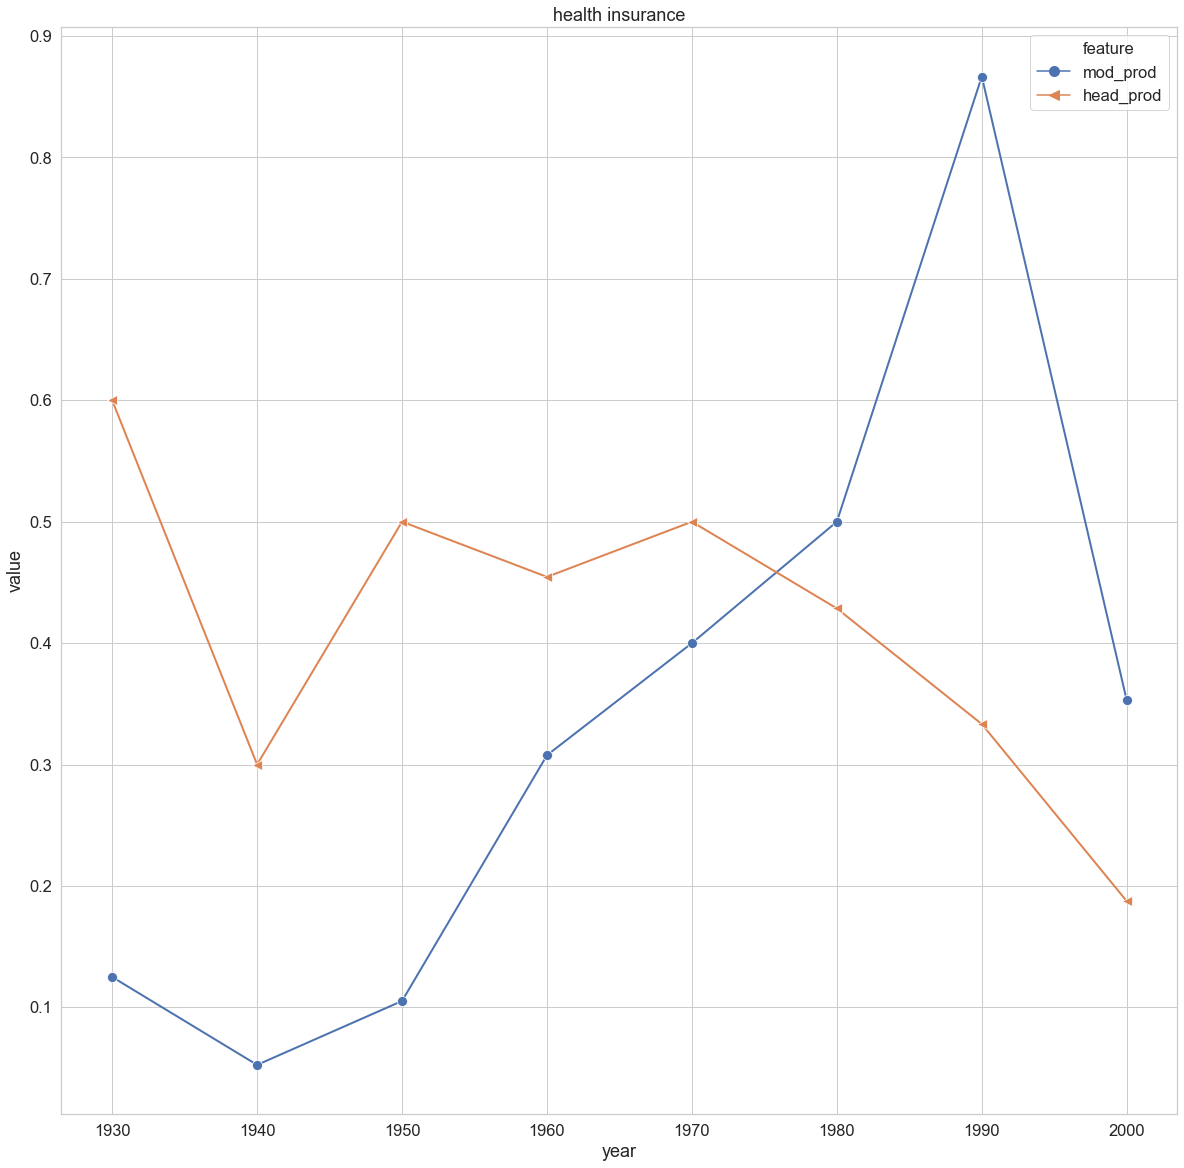

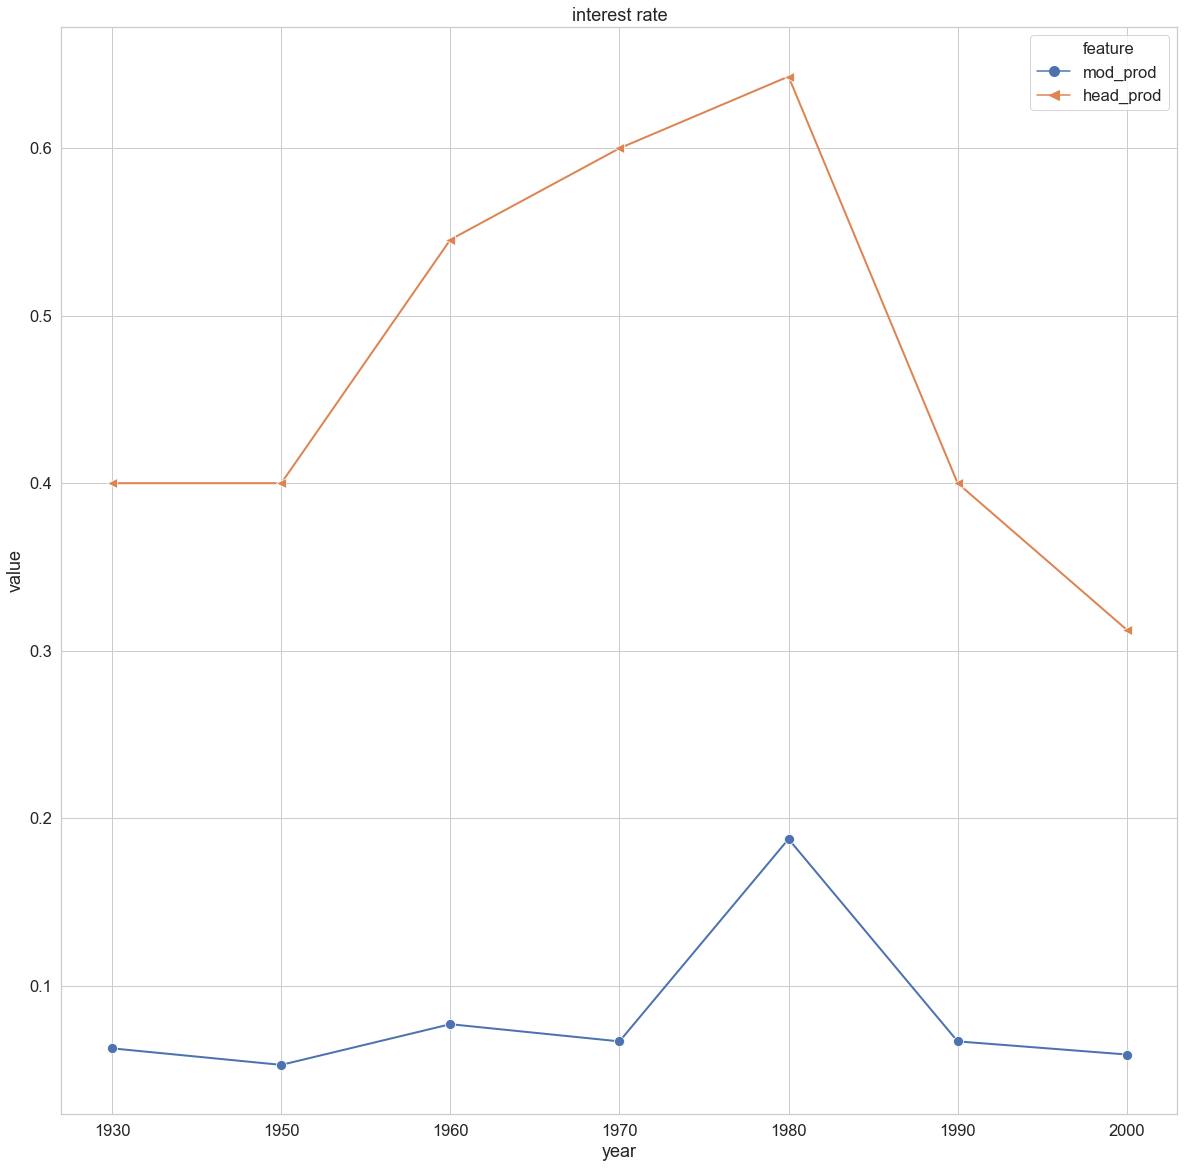

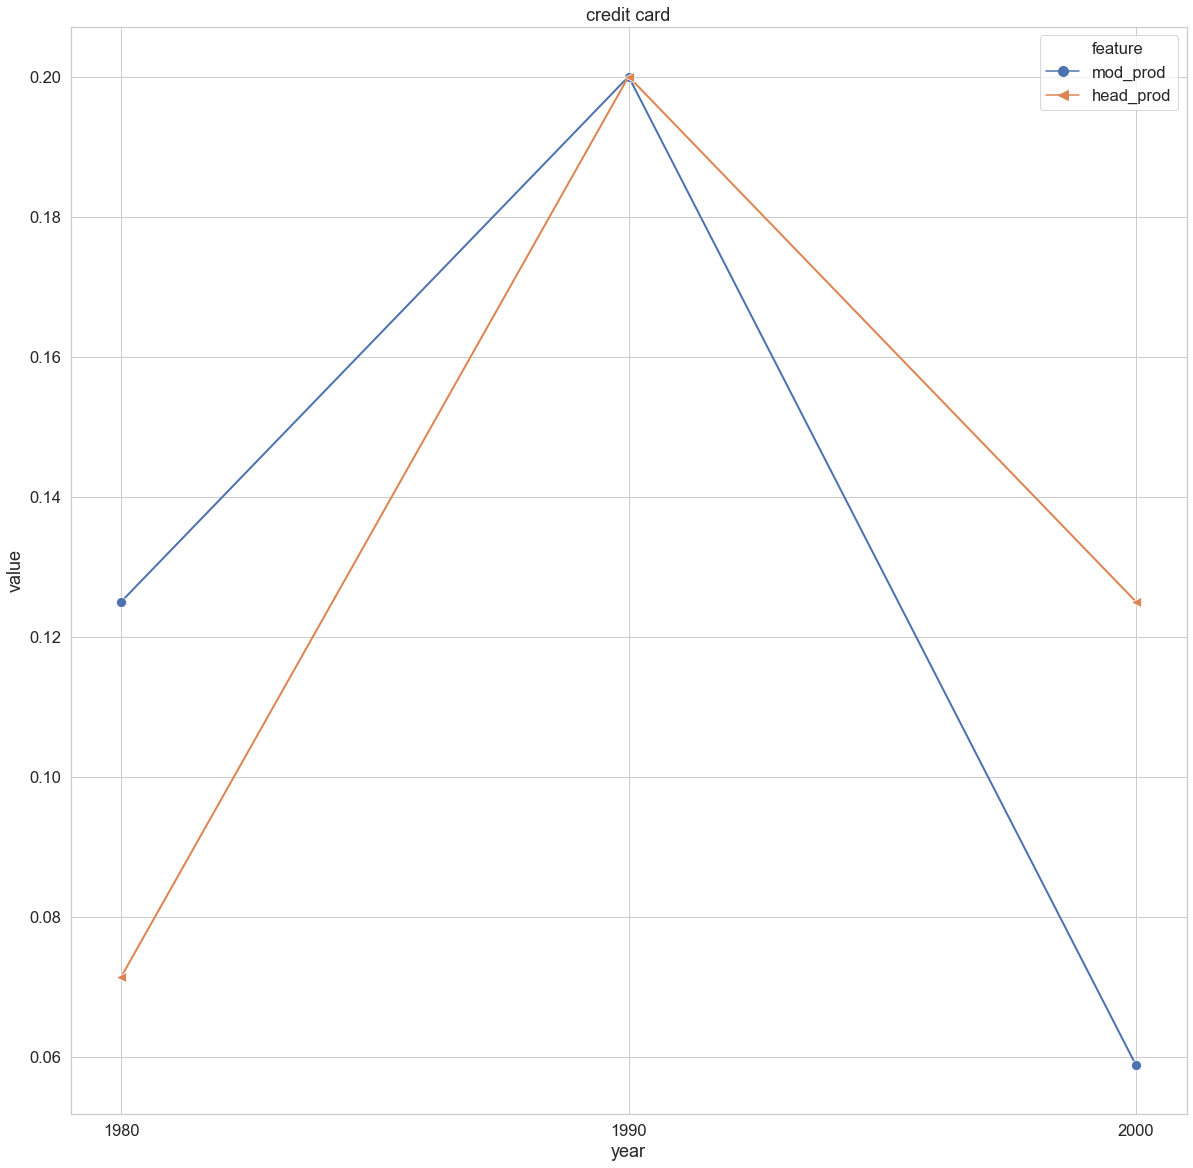

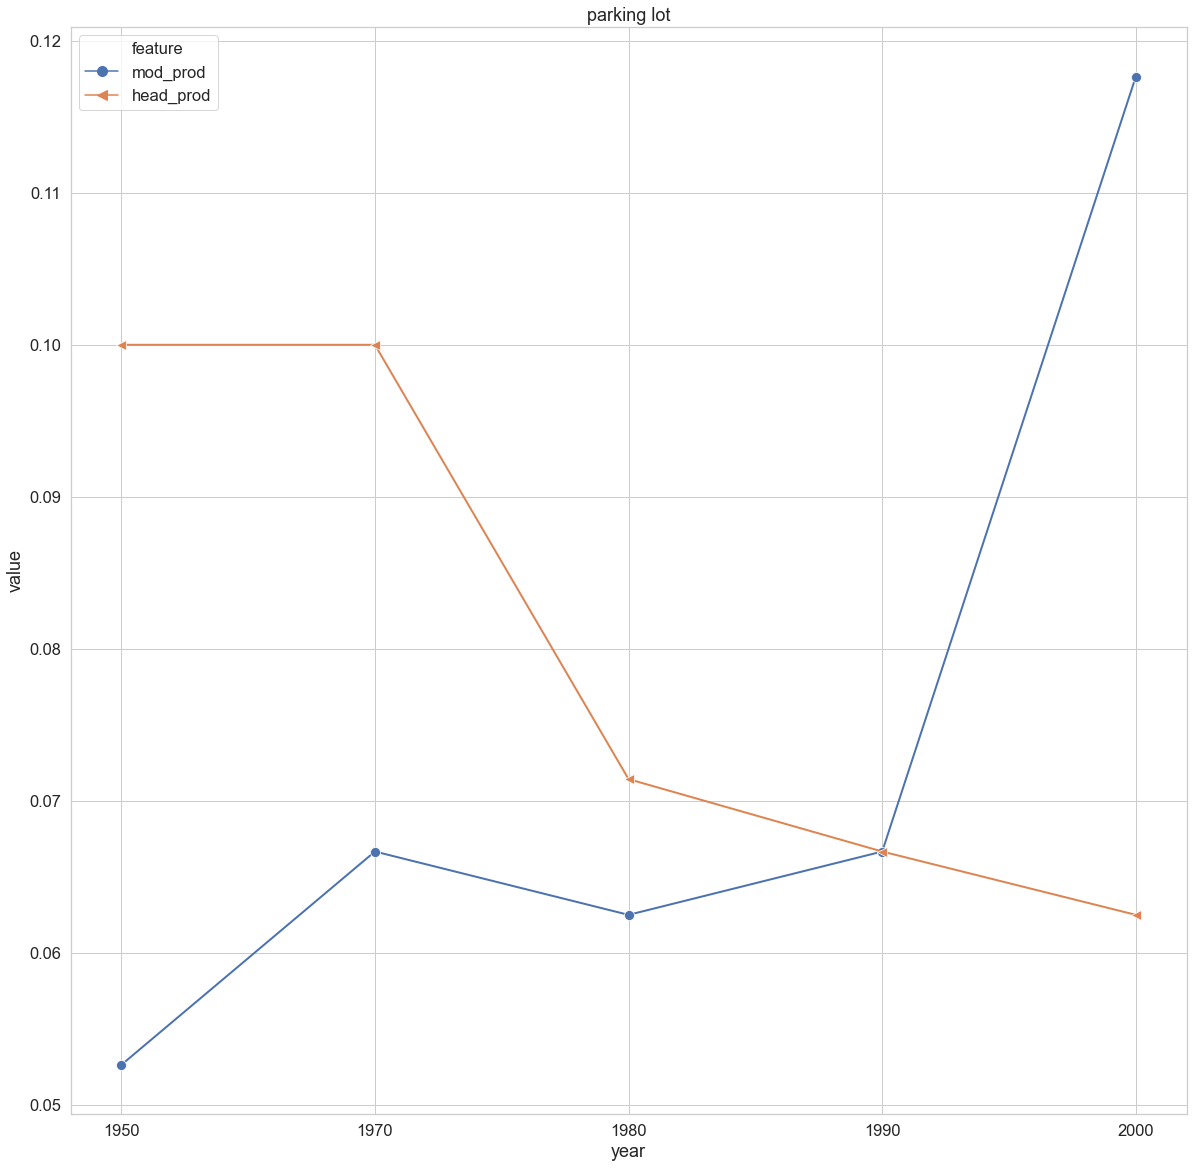

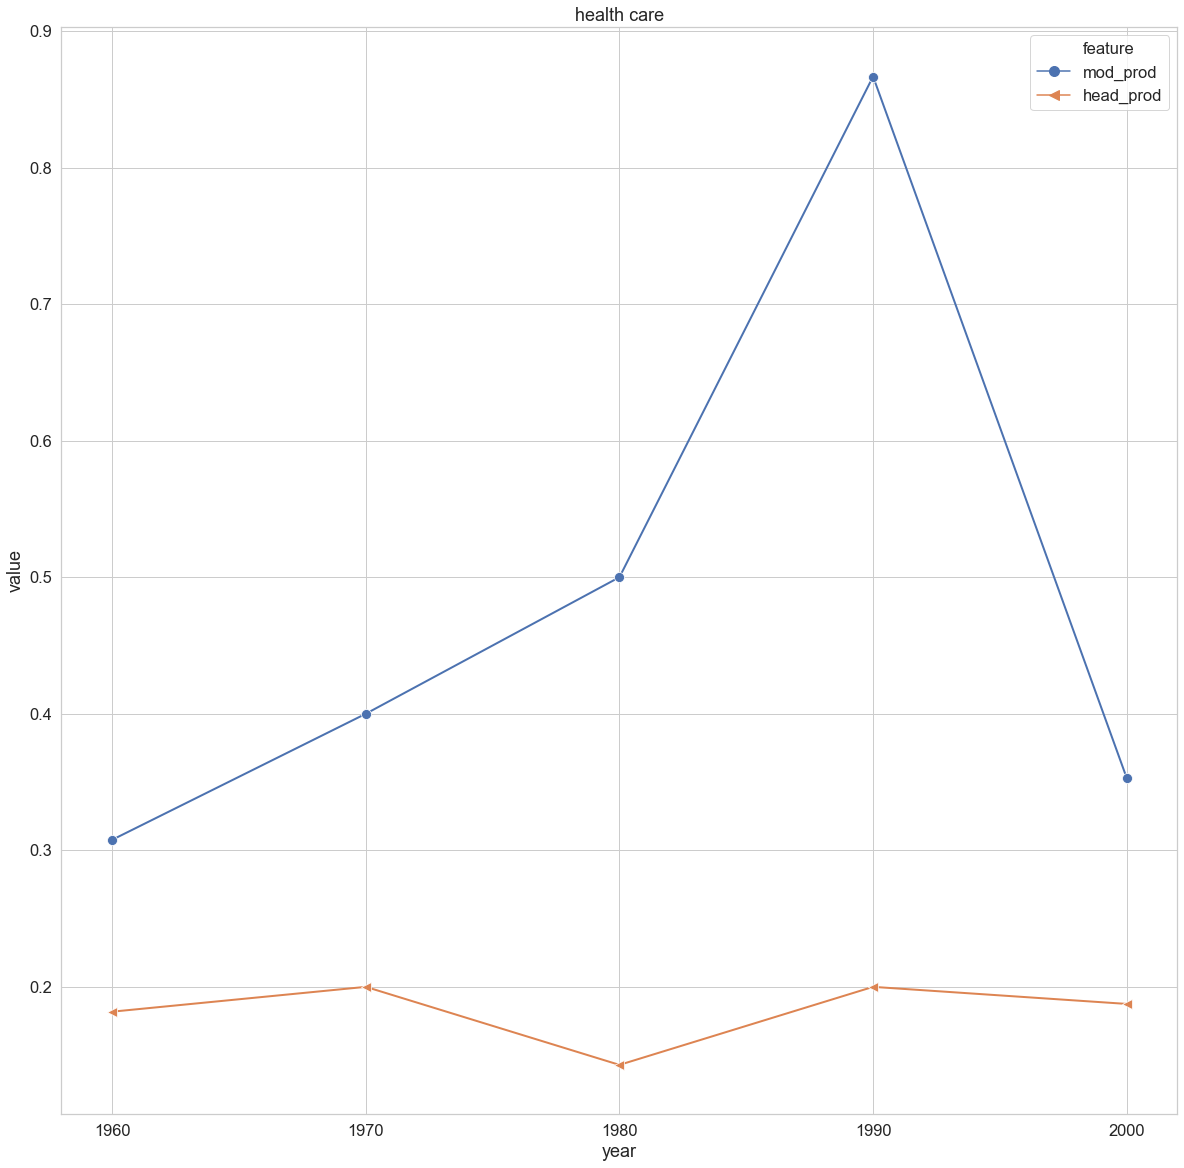

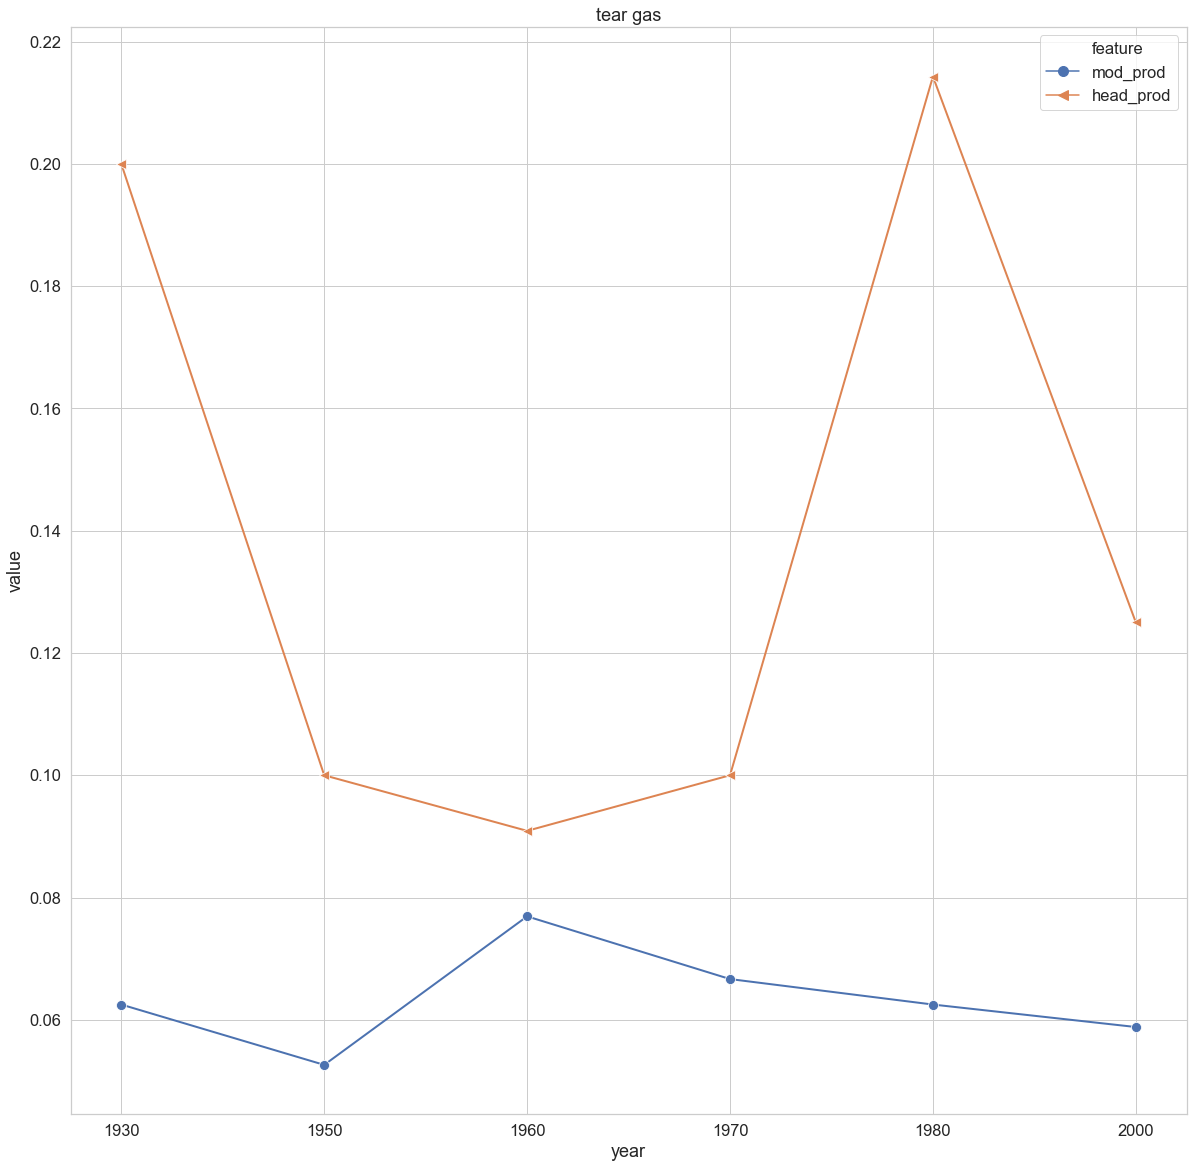

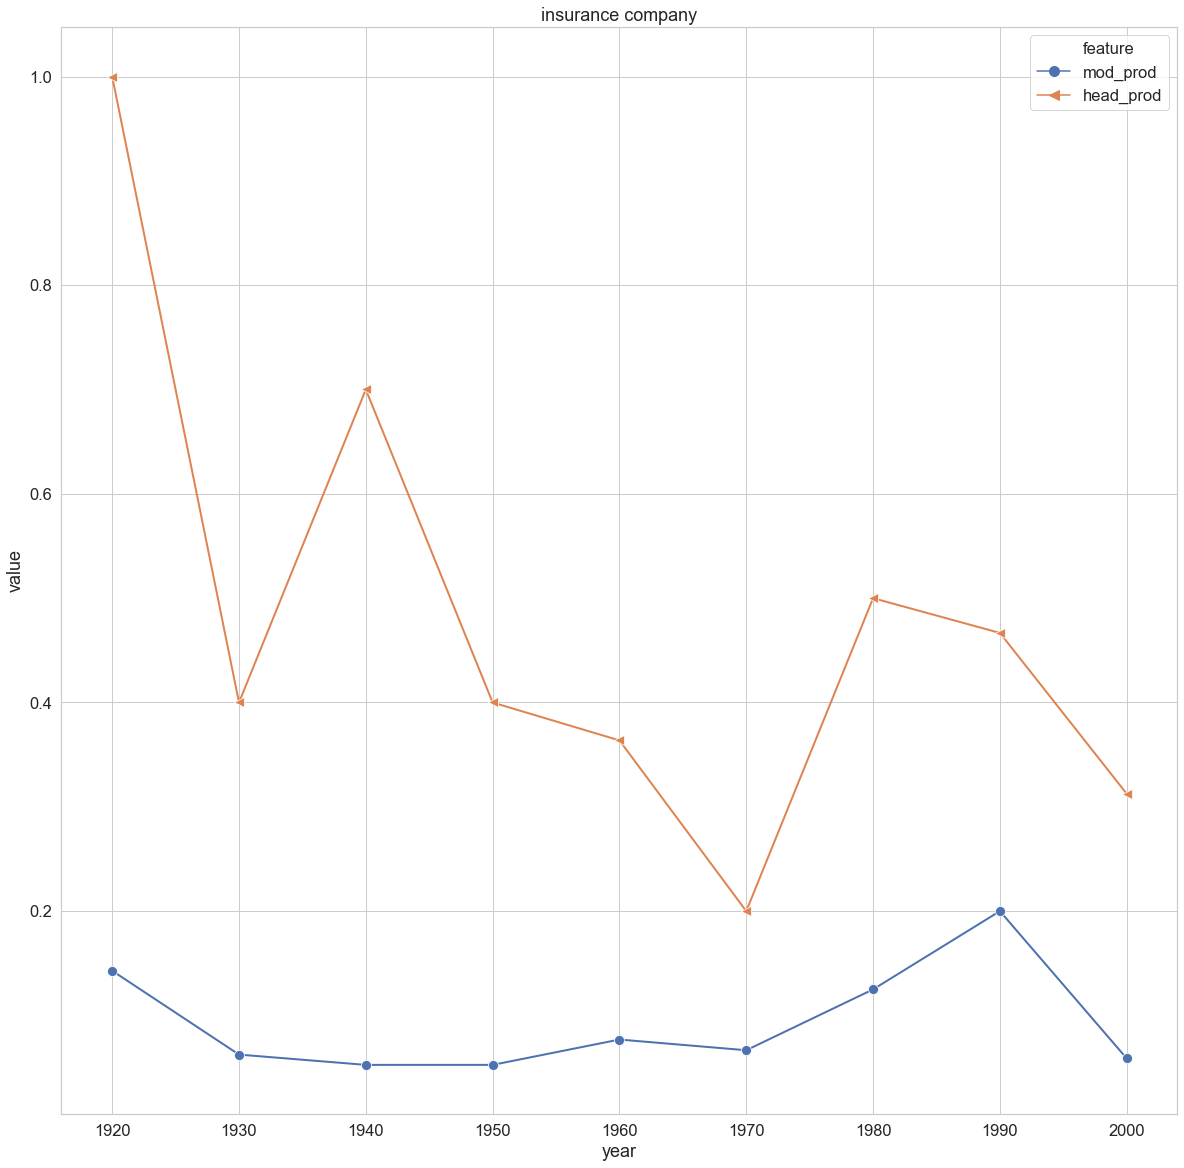

In [41]:
for i in plot_prod_head_mod_df.compound.unique():
    if compounds[compounds.compound == i]["count"].sum() >= 200:
        #fig, ax = plt.subplots(1,2, figsize=(20,10))
        plt.figure(figsize=(20,20))
        """
        h=sns.lineplot(x = "year", y = "count", data=merge_df.loc[merge_df['compound_surface'] == i],
                      style = "type",
                      hue = "type",
                      markers=['o', '<', '>'],
                      dashes = False,
                      palette = "Paired",
                      ax = ax[0])
        h.set_title(i)
        """
        g=sns.lineplot(x = "year", y = "value", data=plot_prod_head_mod_df.loc[plot_prod_head_mod_df['compound'] == i],
                       hue = "feature",
                       style = "feature",
                       #palette="Set2", 
                       markers=['o', '<'],
                       linewidth = 2,
                       legend = "brief",
                       dashes = False,
                       #ax = ax[1]
                      )
        #g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
        #g.xaxis.set_major_locator(ticker.MultipleLocator(20))
        g.set_title(i)
        plt.savefig(plotdir+'single_compounds_prod_{}.png'.format(i))
        if use_pgf:
            plt.savefig(plotdir+'single_compounds_prod_{}.pgf'.format(i))

In [42]:
lmi_df=features.set_index(["modifier", "head"])[lmi_cols]
lmi_df.columns=[v.split("_")[0] for v in lmi_df.columns]
plot_lmi_df=lmi_df.reset_index()
plot_lmi_df['compound']=plot_lmi_df['modifier'].str[:-5]+' '+plot_lmi_df['head'].str[:-5]
plot_lmi_df.drop(['modifier','head'],axis=1,inplace=True)
plot_lmi_df.set_index('compound',inplace=True)
plot_lmi_df = plot_lmi_df.stack().reset_index()
plot_lmi_df.columns=["compound", "year", "value"]
plot_lmi_df['feature'] = "lmi"

llr_df=features.set_index(["modifier", "head"])[llr_cols]
llr_df.columns=[v.split("_")[0] for v in llr_df.columns]
plot_llr_df=llr_df.reset_index()
plot_llr_df['compound']=plot_llr_df['modifier'].str[:-5]+' '+plot_llr_df['head'].str[:-5]
plot_llr_df.drop(['modifier','head'],axis=1,inplace=True)
plot_llr_df.set_index('compound',inplace=True)
plot_llr_df = plot_llr_df.stack().reset_index()
plot_llr_df.columns=["compound", "year", "value"]
plot_llr_df['feature'] = "llr"

ppmi_df=features.set_index(["modifier", "head"])[ppmi_cols]
ppmi_df.columns=[v.split("_")[0] for v in ppmi_df.columns]
plot_ppmi_df=ppmi_df.reset_index()
plot_ppmi_df['compound']=plot_ppmi_df['modifier'].str[:-5]+' '+plot_ppmi_df['head'].str[:-5]
plot_ppmi_df.drop(['modifier','head'],axis=1,inplace=True)
plot_ppmi_df.set_index('compound',inplace=True)
plot_ppmi_df = plot_ppmi_df.stack().reset_index()
plot_ppmi_df.columns=["compound", "year", "value"]
plot_ppmi_df['feature'] = "ppmi"

plot_info_df = plot_lmi_df.append(plot_llr_df)
plot_info_df = plot_info_df.append(plot_ppmi_df)

plot_info_df = plot_info_df[plot_info_df.value != 0]
plot_info_df.year = pd.to_numeric(plot_info_df.year)

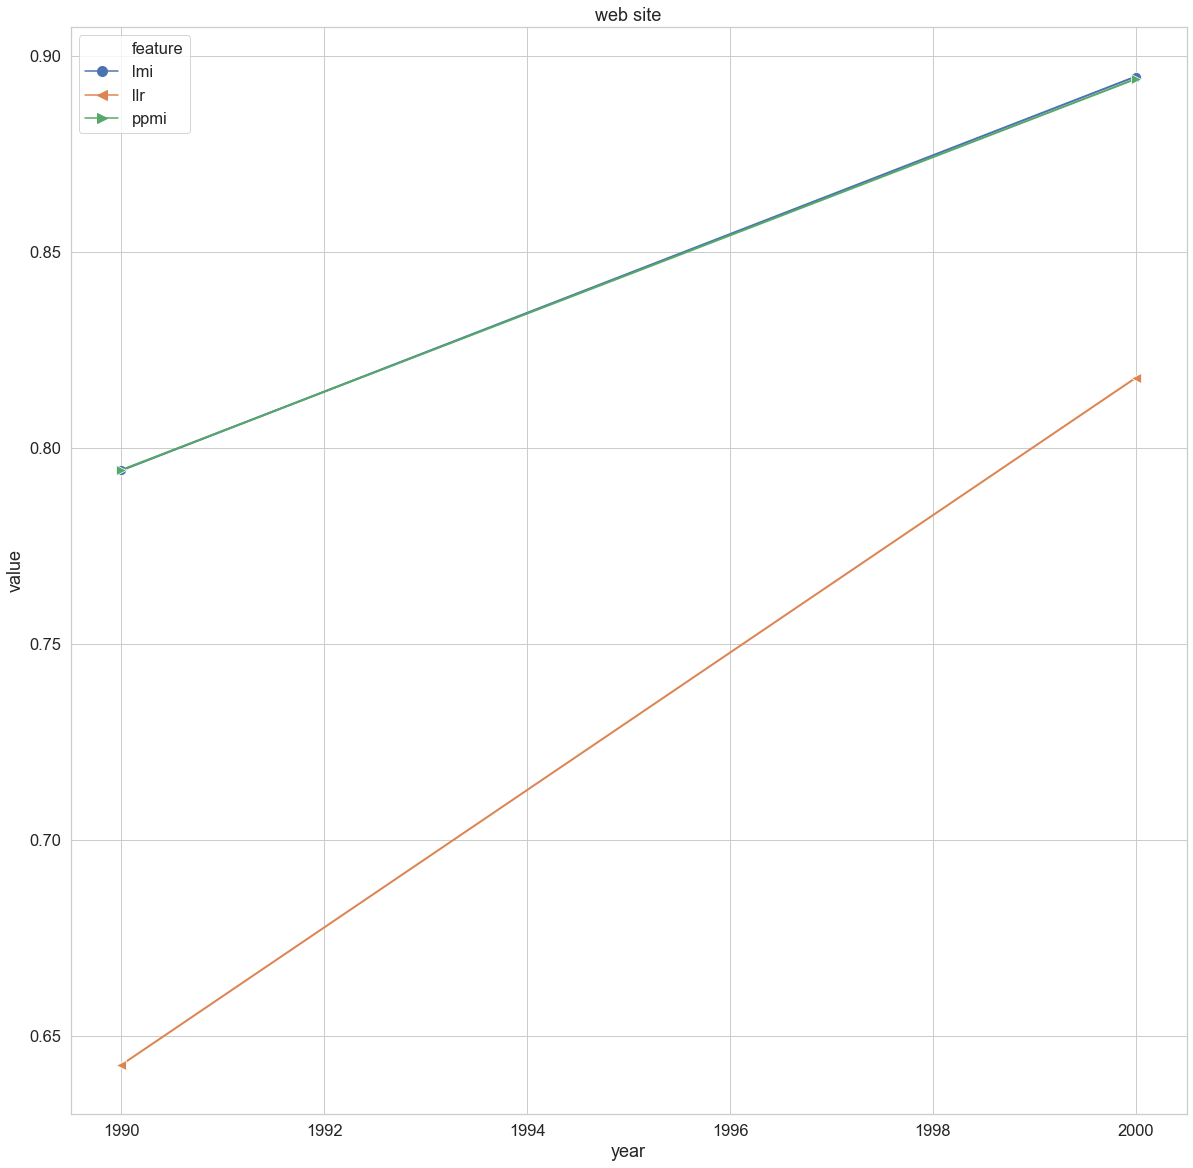

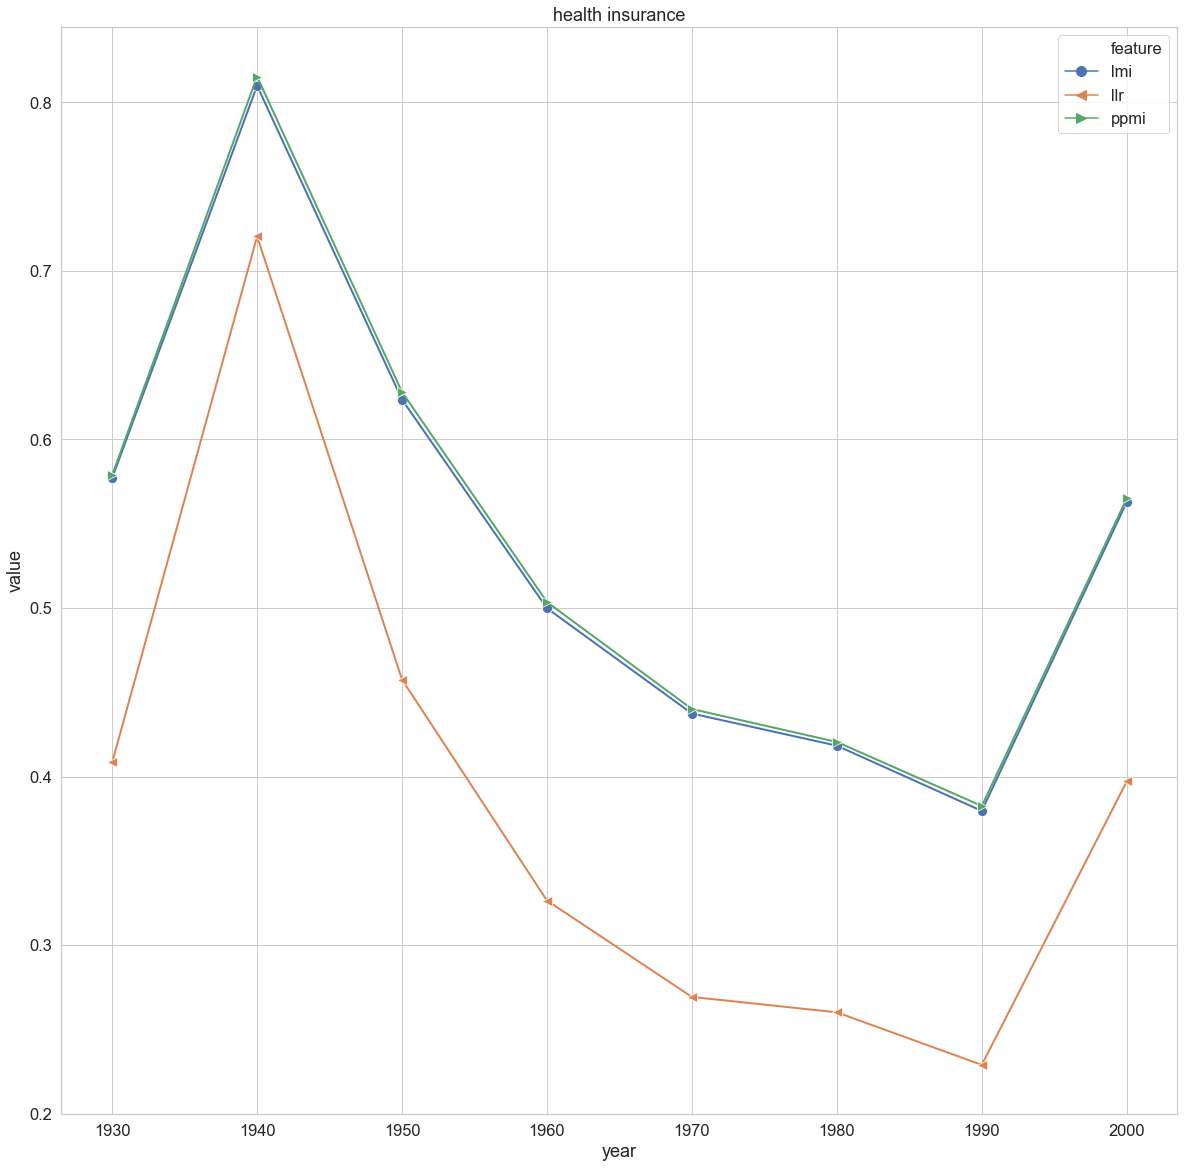

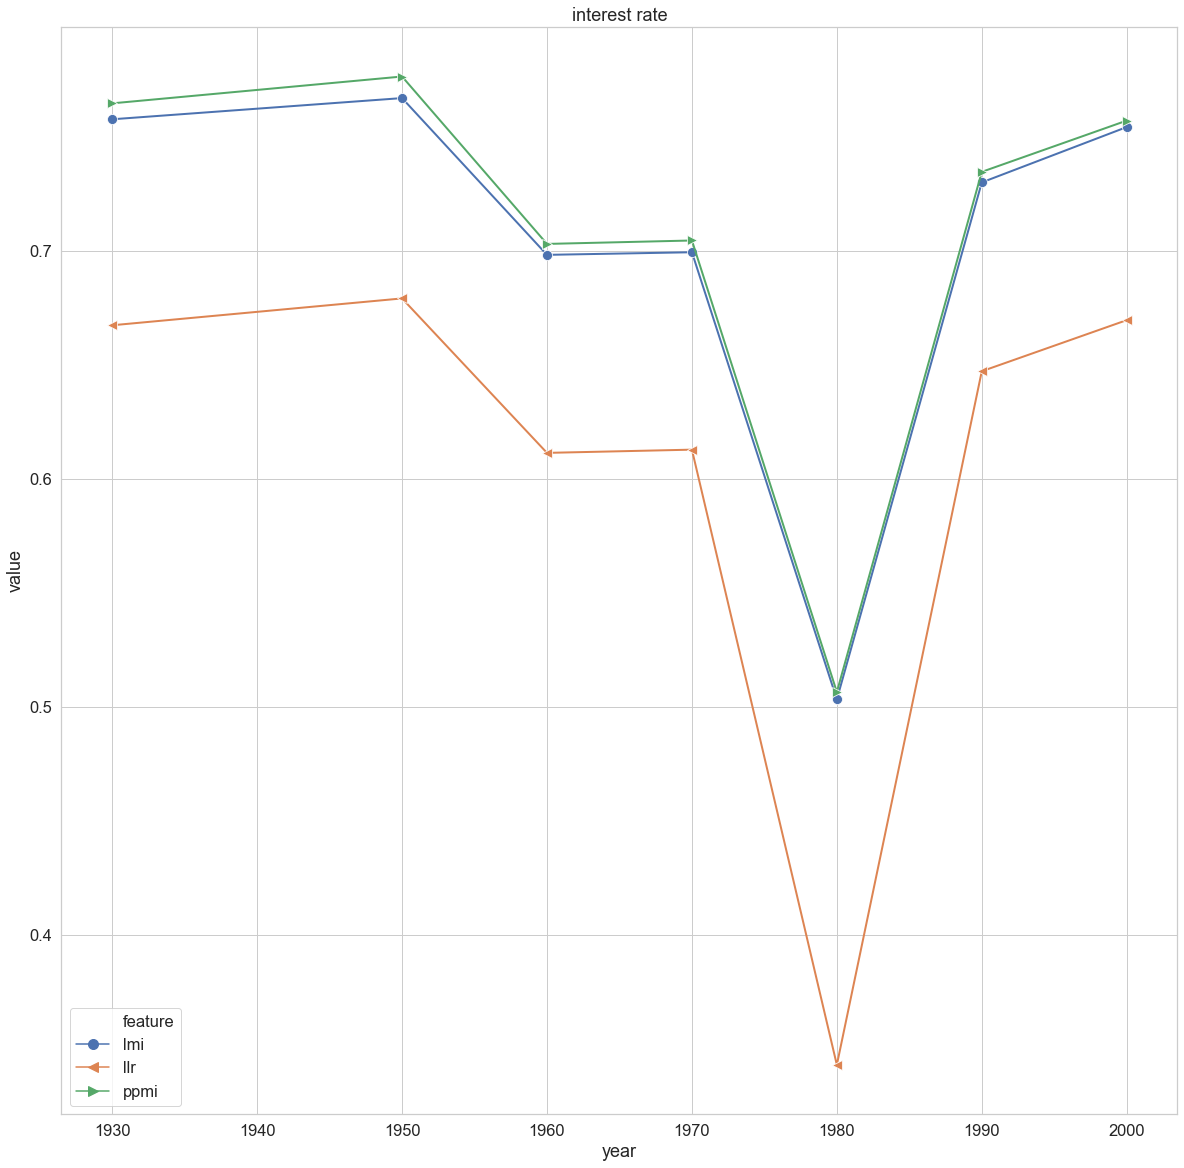

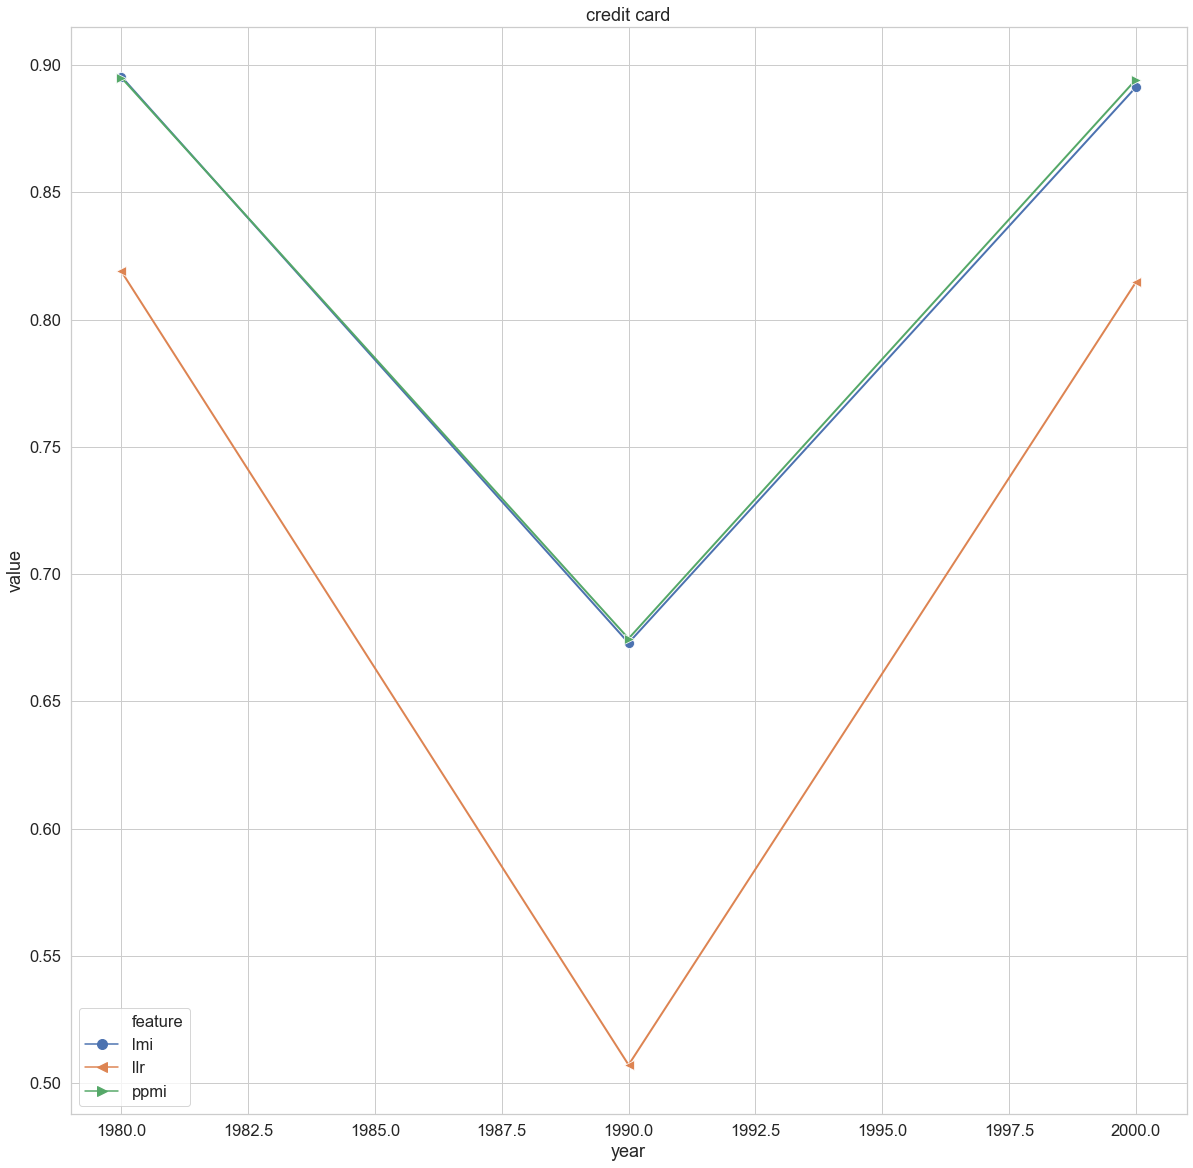

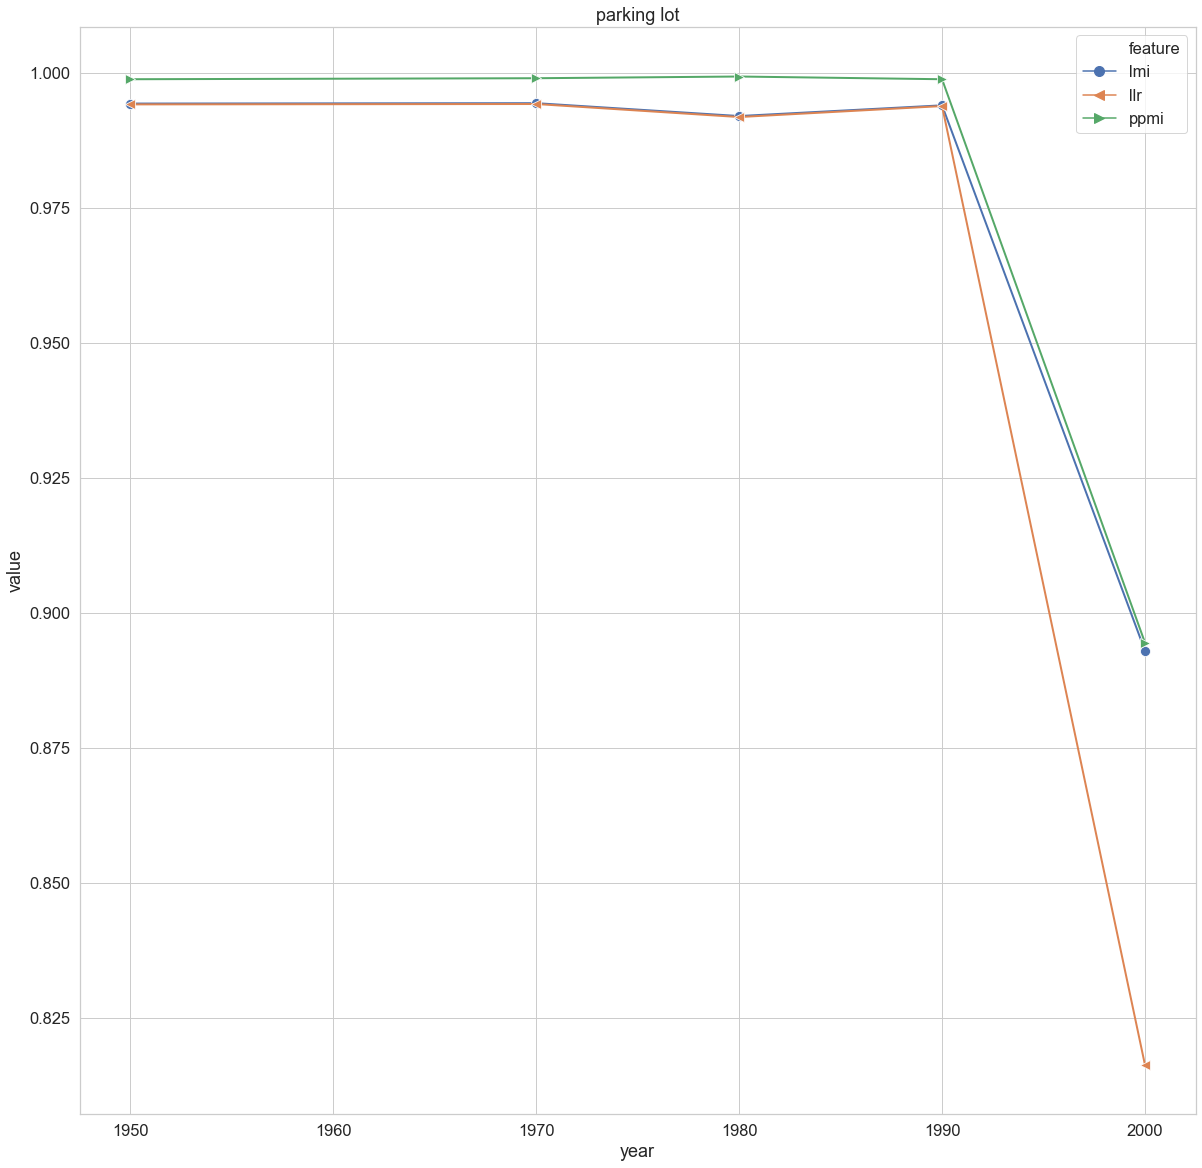

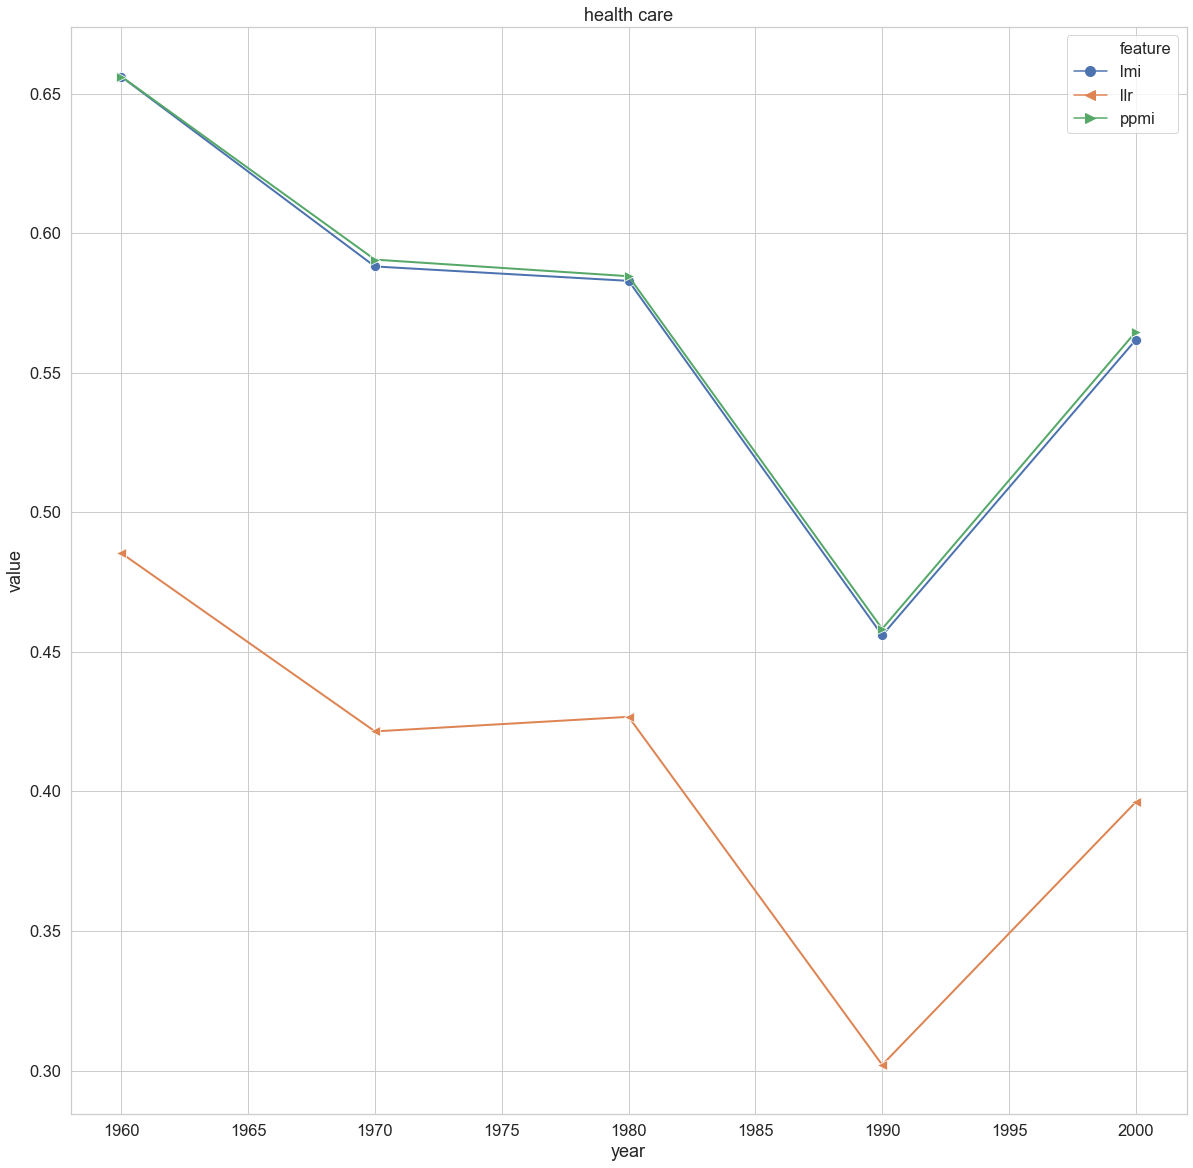

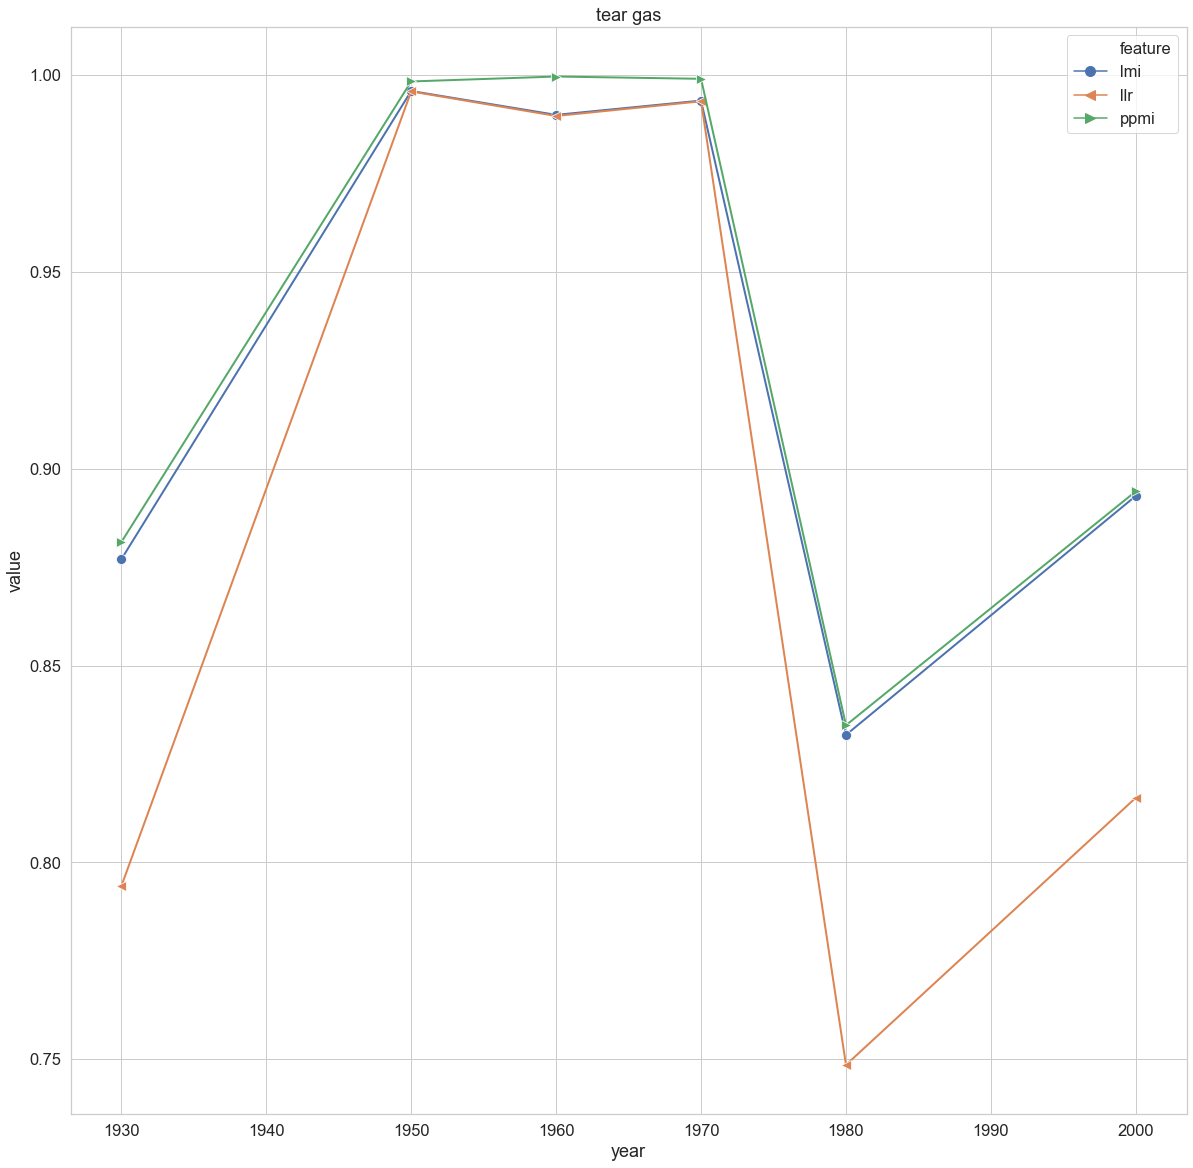

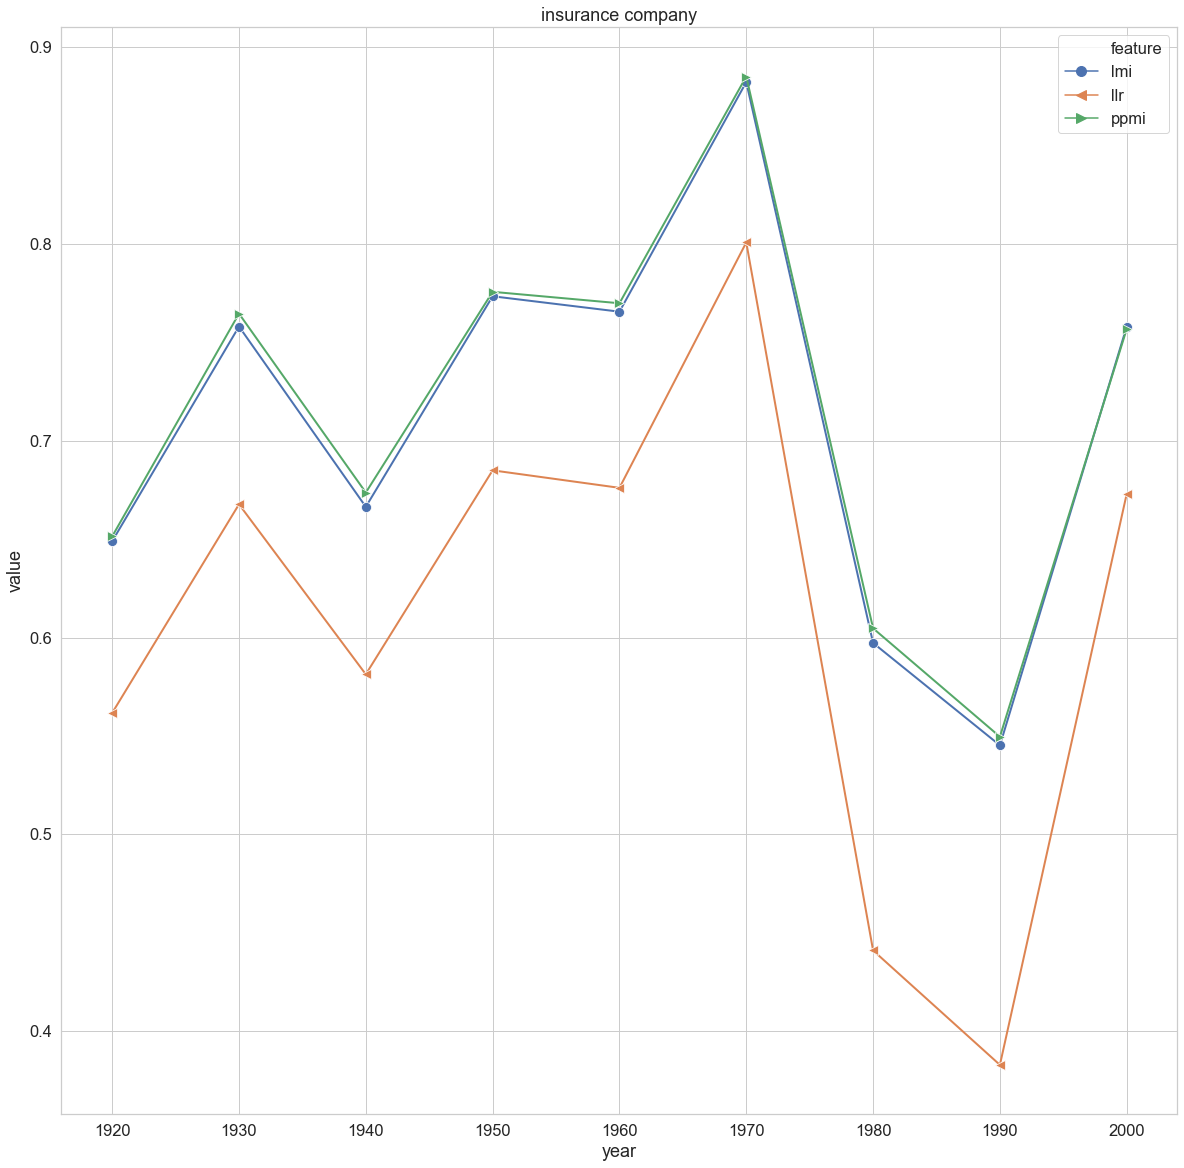

In [43]:
for i in plot_info_df.compound.unique():
    if compounds[compounds.compound == i]["count"].sum() >= 200:
        #fig, ax = plt.subplots(1,2, figsize=(20,10))
        plt.figure(figsize=(20,20))
        """
        h=sns.lineplot(x = "year", y = "count", data=merge_df.loc[merge_df['compound_surface'] == i],
                      style = "type",
                      hue = "type",
                      markers=['o', '<', '>'],
                      dashes = False,
                      palette = "Paired",
                      ax = ax[0])
        h.set_title(i)
        """
        g=sns.lineplot(x = "year", y = "value", data=plot_info_df.loc[plot_info_df['compound'] == i],
                       hue = "feature",
                       style = "feature",
                       #palette="Set2", 
                       markers=['o', '<', '>'],
                       linewidth = 2,
                       legend = "brief",
                       dashes = False,
                       #ax = ax[1]
                      )
        #g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
        #g.xaxis.set_major_locator(ticker.MultipleLocator(20))
        g.set_title(i)
        plt.savefig(plotdir+'single_compounds_inf_{}.png'.format(i))
        if use_pgf:
            plt.savefig(plotdir+'single_compounds_inf_{}.pgf'.format(i))

In [44]:
plot_features_df = pd.concat([plot_info_df, plot_prod_head_mod_df, plot_sim_head_mod_df])

In [45]:
year_token_counts = pd.read_csv('../../data/coha_year_token_count.csv')
year_token_counts.columns = ['year', 'tokencount']
year_token_counts

year  tokencount
0   2000    36346196
1   1990    34499634
2   1980    31014856
3   1920    30884417
4   1950    30043978
5   1930    29779920
6   1940    29644093
7   1960    29363887
8   1970    29109358
9   1910    27415006
10  1900    26455411
11  1890    24365806
12  1880    24198668
13  1870    22376110
14  1860    20414293
15  1850    19814449
16  1840    19247740
17  1830    16555683
18  1820     8363940
19  1810     1478152

In [46]:
plot_count_df = compounds[compounds.compound.isin(plot_features_df.compound.unique())]
plot_count_df = pd.merge(plot_count_df, plot_sim_with_modifier_df[["compound","compound_rating"]], on="compound")
plot_count_df = plot_count_df.merge(year_token_counts, on='year')
plot_count_df["normcount"] = plot_count_df["count"]/plot_count_df["tokencount"]
plot_count_df["normcount"].fillna(0, inplace=True)
plot_count_df["normcount"] -= plot_count_df["normcount"].min()
plot_count_df["normcount"] /= plot_count_df["normcount"].max()
plot_count_df

compound      modifier             head  year  count  \
0        academy award  academy_noun       award_noun  1930      1   
1        academy award  academy_noun       award_noun  1930      1   
2        academy award  academy_noun       award_noun  1930      1   
3        academy award  academy_noun       award_noun  1930      1   
4        academy award  academy_noun       award_noun  1930      1   
...                ...           ...              ...   ...    ...   
6421  peace conference    peace_noun  conference_noun  1880      3   
6422  peace conference    peace_noun  conference_noun  1880      3   
6423  peace conference    peace_noun  conference_noun  1880      3   
6424  peace conference    peace_noun  conference_noun  1880      3   
6425  peace conference    peace_noun  conference_noun  1880      3   

     compound_rating  tokencount  normcount  
0                med    29779920      0.000  
1                med    29779920      0.000  
2                med    29779920      0.000  
3                med    29779920      0.000  
4                med    29779920      0.000  
...              ...         ...        ...  
6421            high    24198668      0.006  
6422            high    24198668      0.006  
6423            high    24198668      0.006  
6424            high    24198668      0.006  
6425            high    24198668      0.006  

[6426 rows x 8 columns]

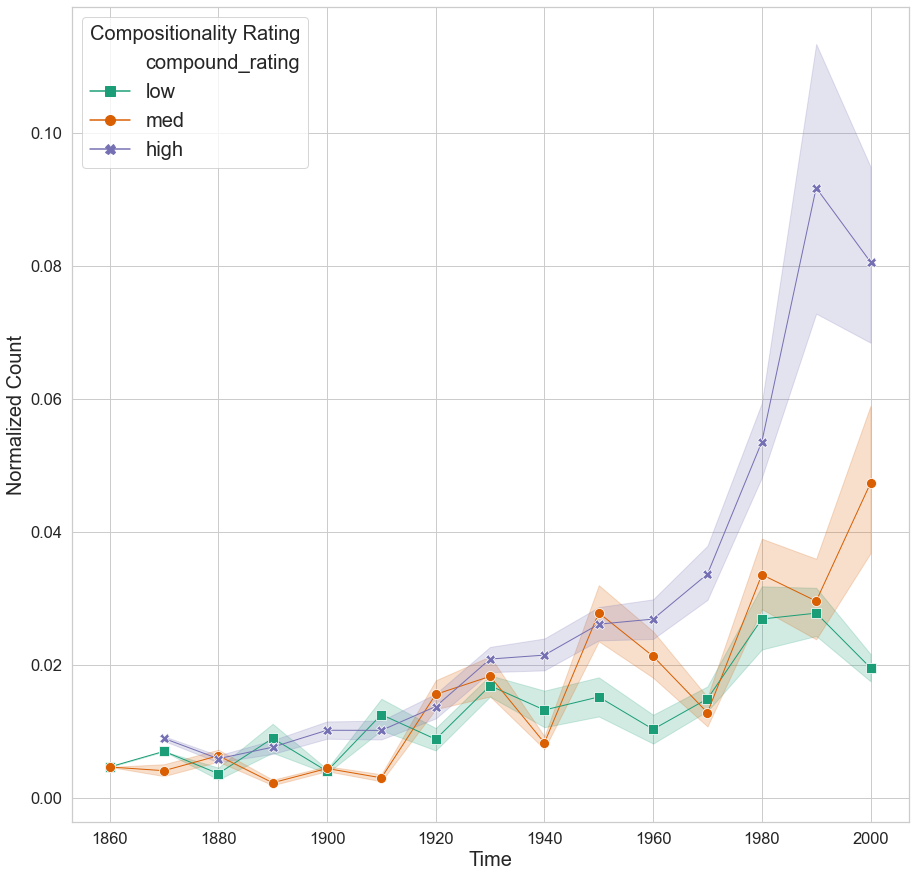

In [47]:
plt.figure(figsize=(15,15))
g=sns.lineplot(x="year", y="normcount", hue="compound_rating", hue_order=["low", "med", "high"], style="compound_rating",data=plot_count_df,palette="Dark2", marker='o',linewidth=1,dashes=False,markers=True)#,err_style="bars", ci=68)
g.set_xlabel("Time", fontsize=20)
g.set_ylabel("Normalized Count", fontsize=20)
g.legend(title='Compositionality Rating', loc='upper left', fontsize=20, title_fontsize=20)
#g.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)
#g.set_xlim(1799, 2000)
plt.savefig(plotdir+'compound-counts-merged_{}_{}_{}_{}.png'.format(mode, timespan, cutoff, dimension))
if use_pgf:
    plt.savefig(plotdir+'compound-counts-merged_{}_{}_{}_{}.pgf'.format(mode, timespan, cutoff, dimension))

In [48]:
corr_count_df = plot_count_df[["compound","year","count"]]
corr_count_df["feature"] = "count"
corr_count_df.rename(columns = {'count':'value'}, inplace = True)
corr_count_df = pd.concat([plot_features_df, corr_count_df])
corr_count_df.drop_duplicates(inplace=True)
corr_count_df['year'] = pd.to_numeric(corr_count_df['year'])
corr_count_df = corr_count_df.pivot_table(values=['value'], index=['year','compound'], columns=['feature'])
corr_count_df.columns = corr_count_df.columns.get_level_values(1)
corr_count_df

feature              count  head_prod   llr   lmi  mod_prod  ppmi  \
year compound                                                       
1860 brick wall      2.000        nan   nan   nan       nan   nan   
     fairy tale      2.000        nan   nan   nan       nan   nan   
1870 balance sheet   1.000        nan   nan   nan       nan   nan   
     brick wall      3.000        nan   nan   nan       nan   nan   
     engine room     3.000        nan   nan   nan       nan   nan   
...                    ...        ...   ...   ...       ...   ...   
2000 shelf life     14.000      0.375 0.641 0.724     0.059 0.730   
     speed limit    17.000      0.062 0.992 0.992     0.059 0.999   
     tear gas       15.000      0.125 0.816 0.893     0.059 0.894   
     video game     49.000      0.250 0.522 0.683     0.118 0.687   
     web site      174.000      0.062 0.818 0.895     0.118 0.894   

feature             sim_with_head  sim_with_mod  
year compound                                    
1860 brick wall               nan           nan  
     fairy tale               nan           nan  
1870 balance sheet            nan           nan  
     brick wall               nan           nan  
     engine room              nan           nan  
...                           ...           ...  
2000 shelf life             0.202         0.036  
     speed limit            0.369         0.274  
     tear gas               0.261         0.135  
     video game             0.369         0.222  
     web site               0.143         0.131  

[368 rows x 8 columns]

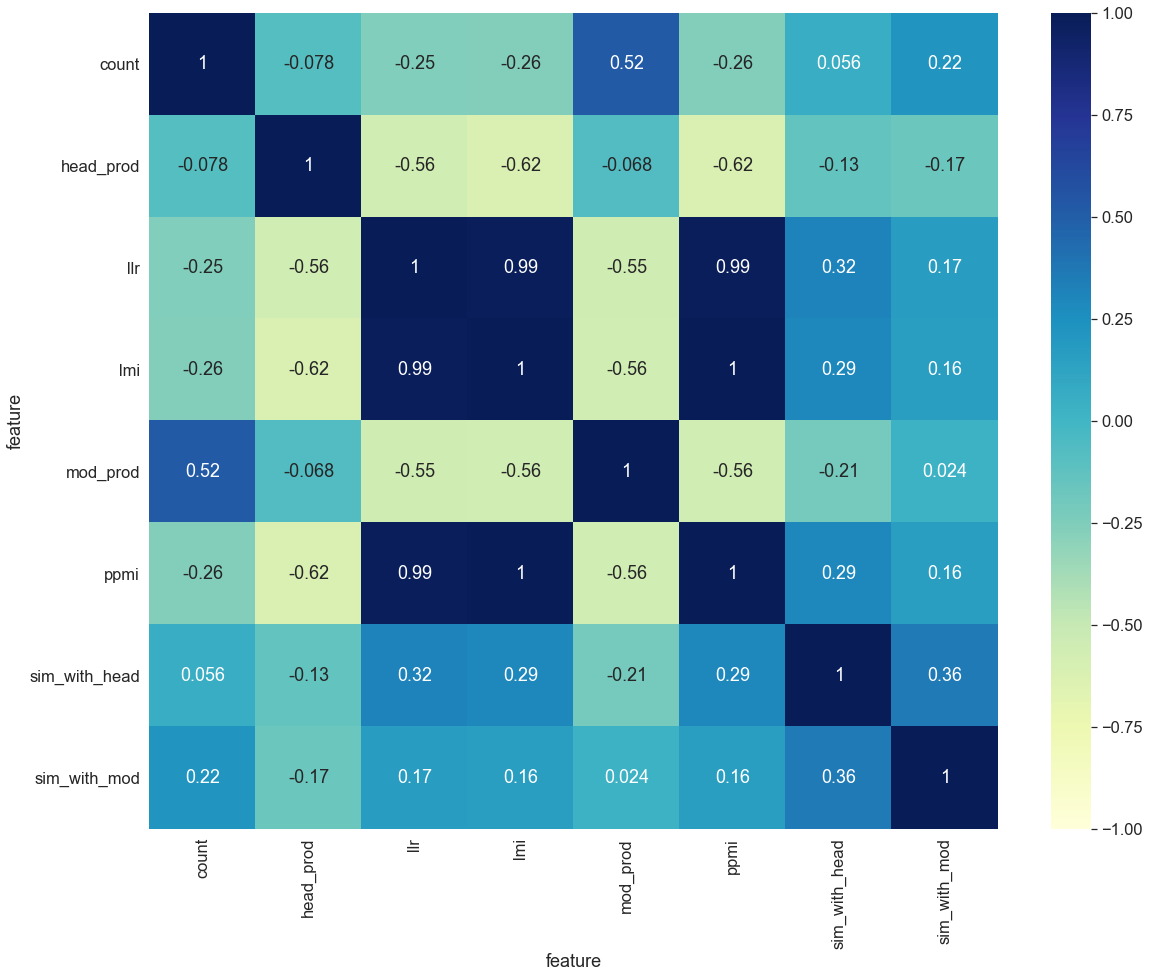

In [49]:
plt.figure(figsize=(19, 15))
g = sns.heatmap(corr_count_df.corr(), annot=True, vmin=-1, vmax=1, cmap="YlGnBu")
plt.savefig(plotdir+'corr_{}_{}_{}_{}.png'.format(mode, timespan, cutoff, dimension))
if use_pgf:
    plt.savefig(plotdir+'corr_{}_{}_{}_{}.pgf'.format(mode, timespan, cutoff, dimension))

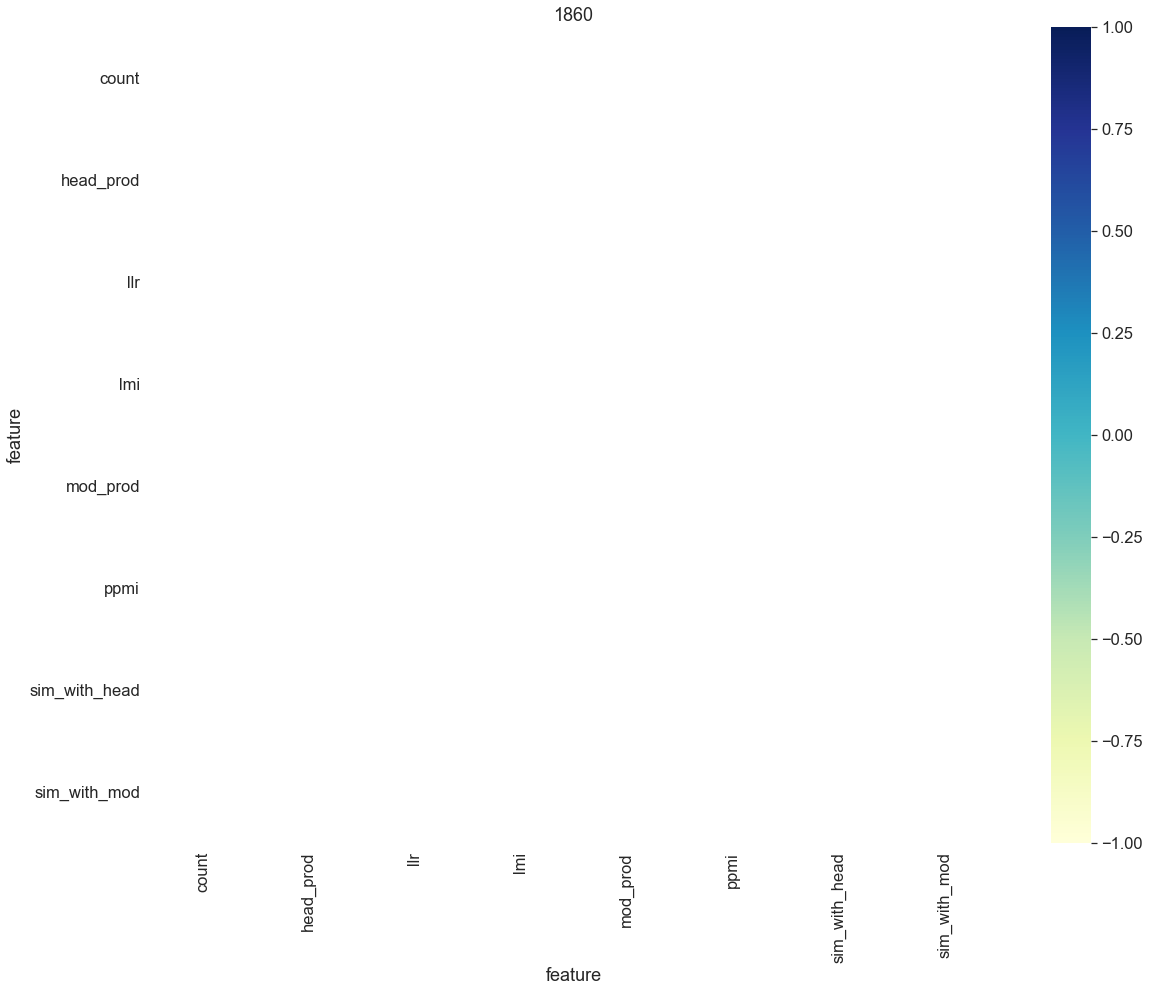

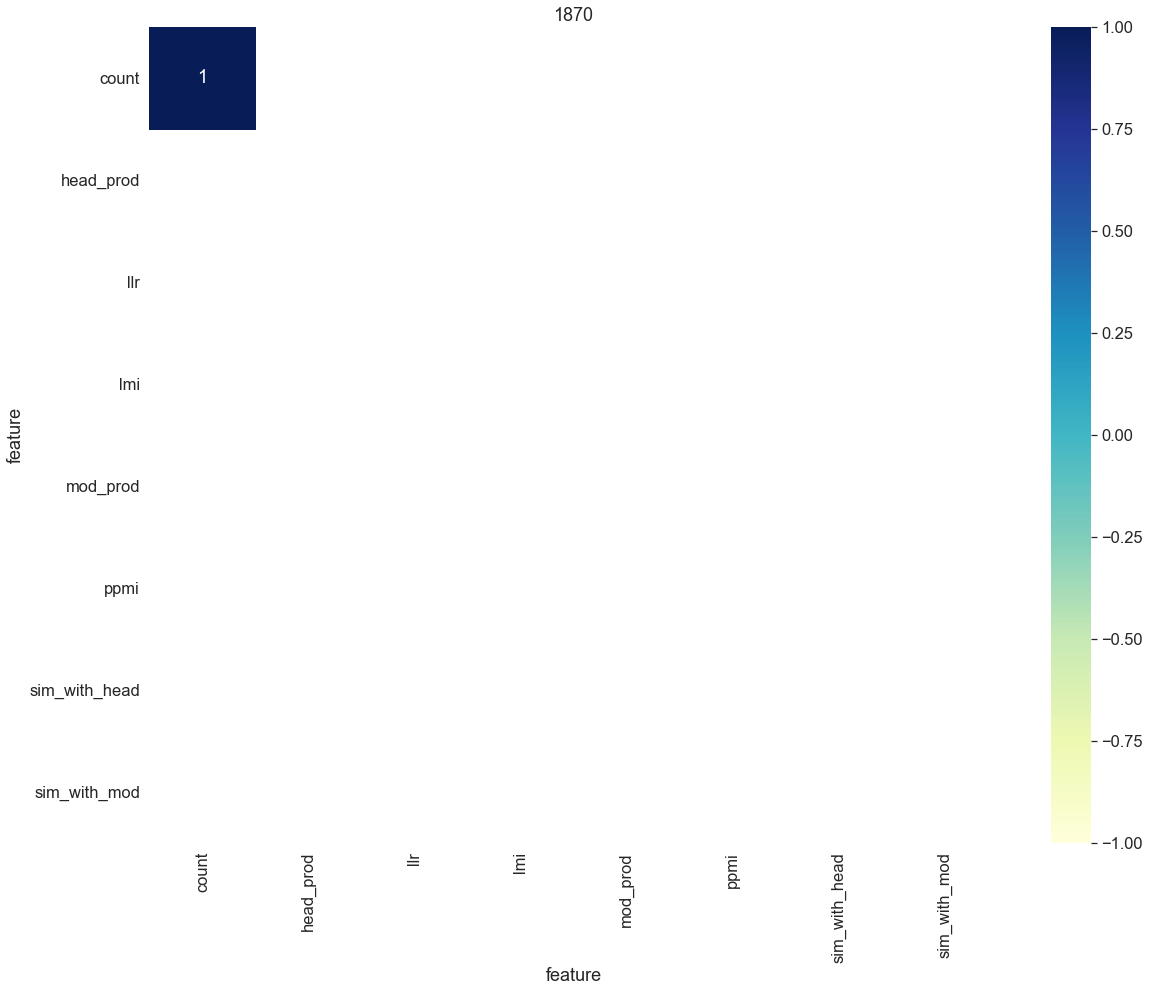

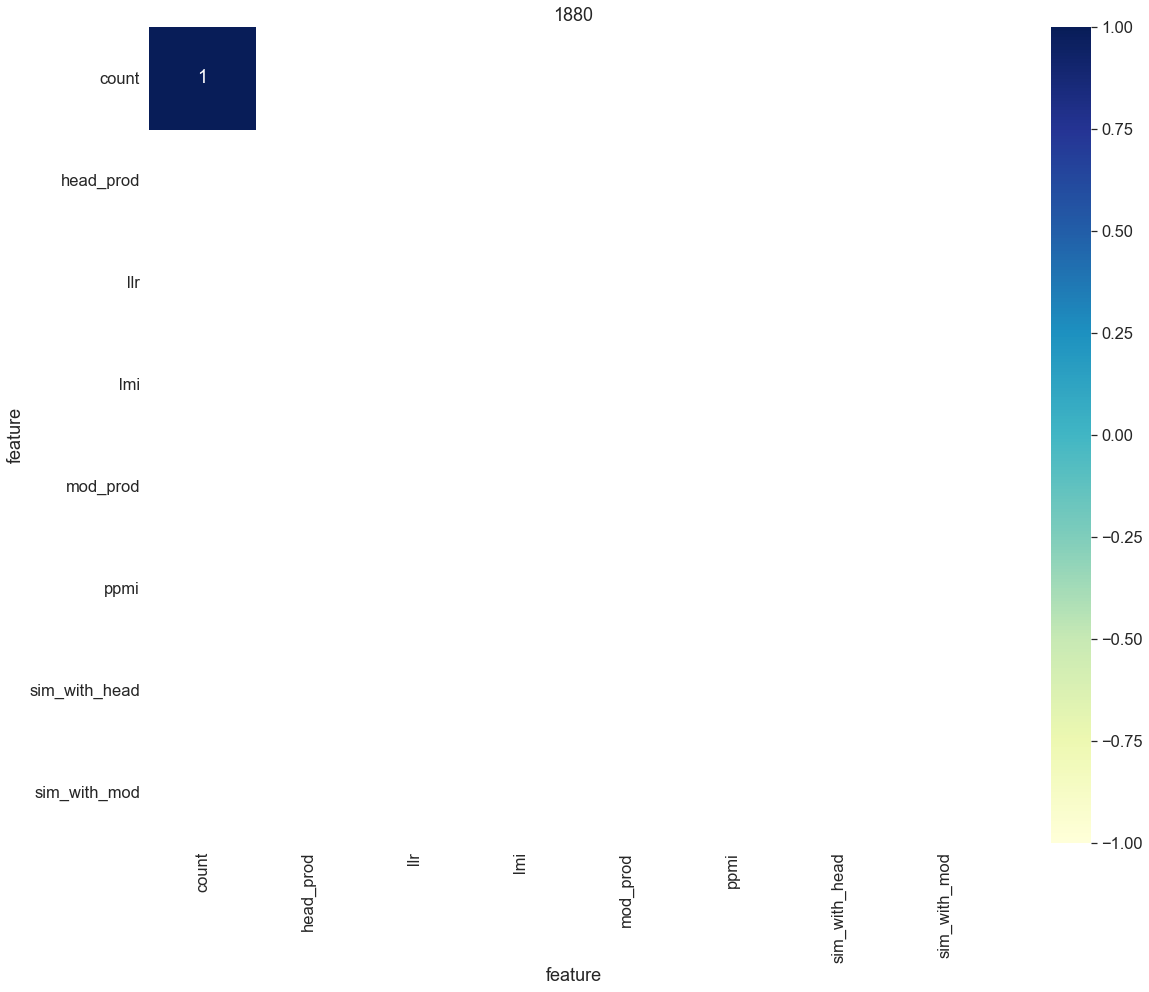

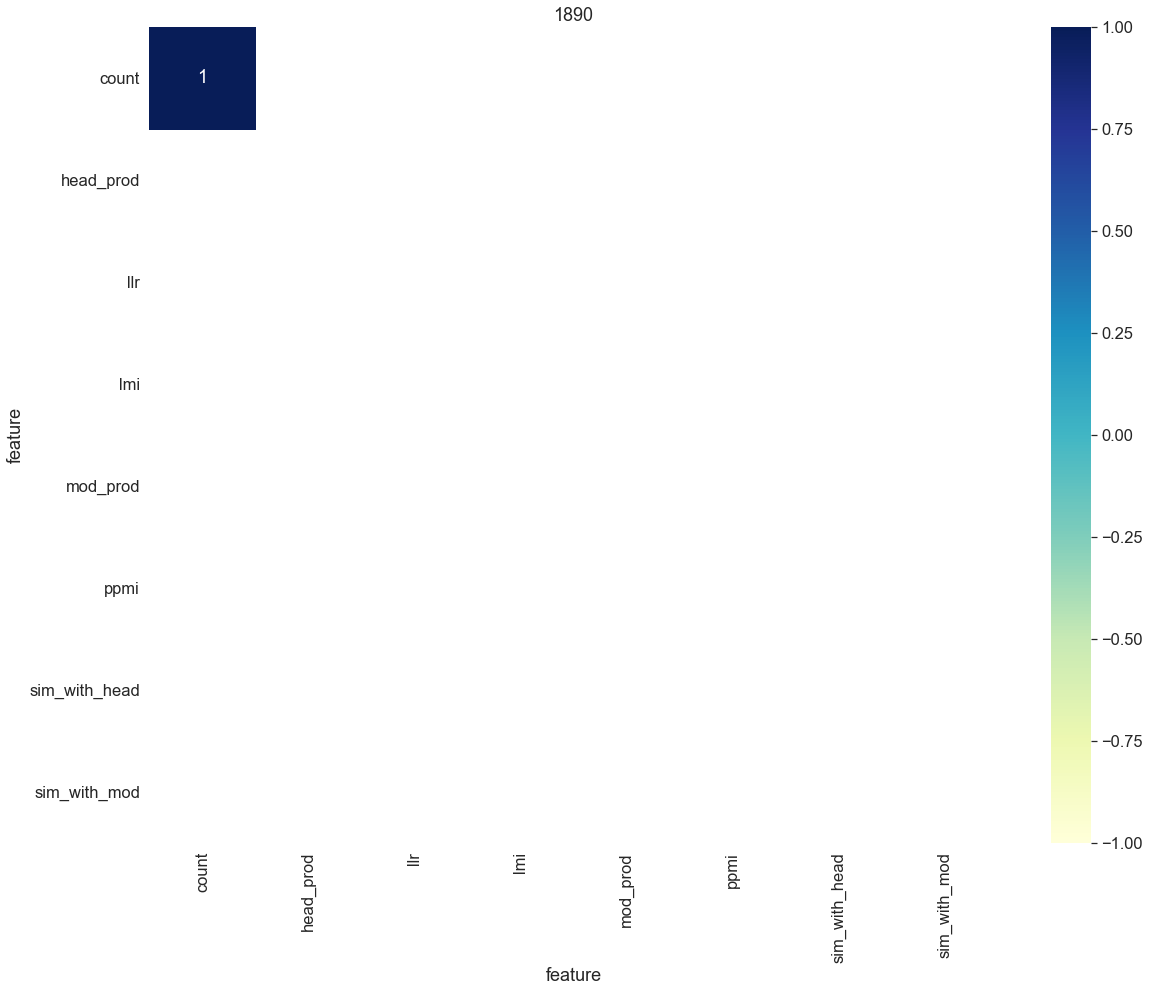

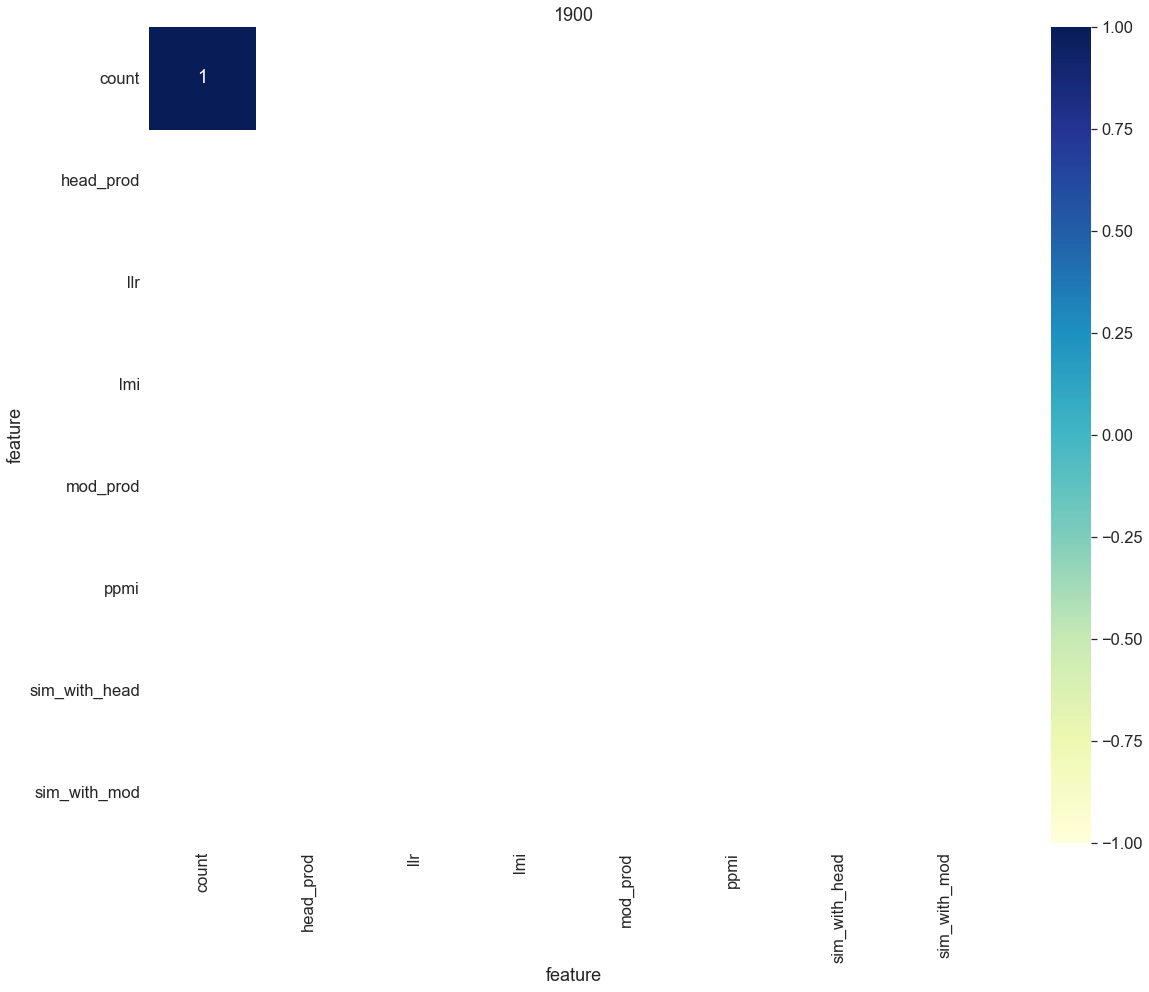

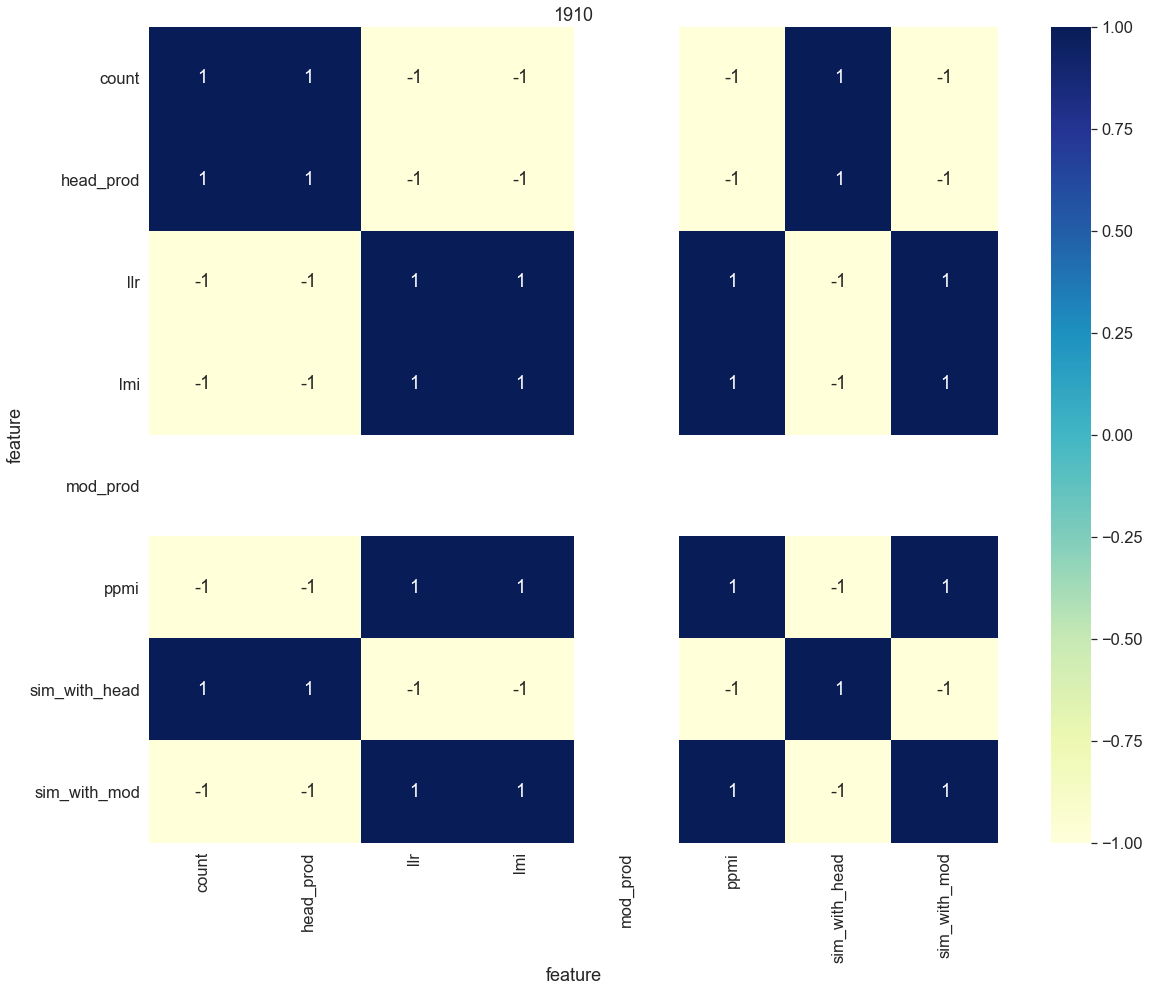

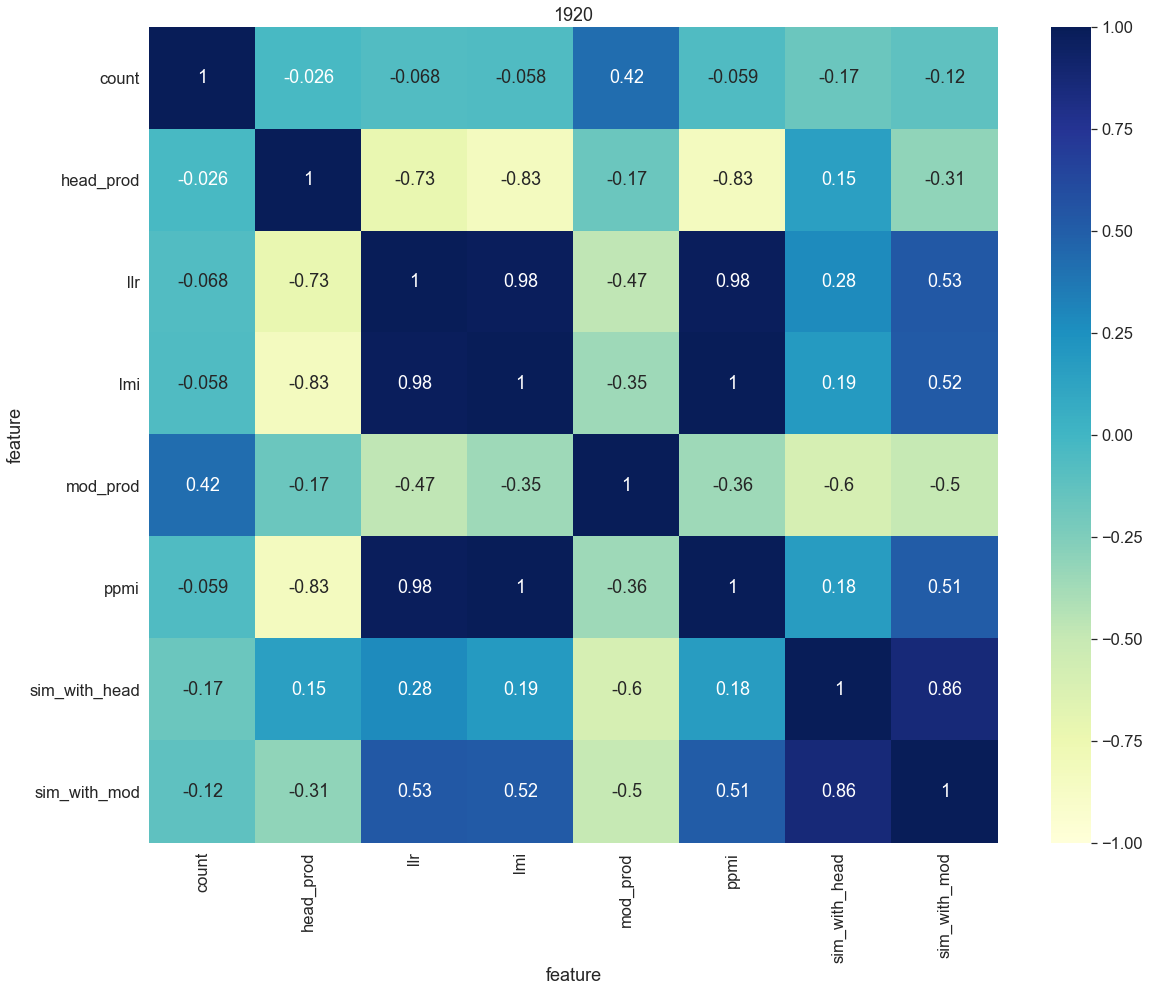

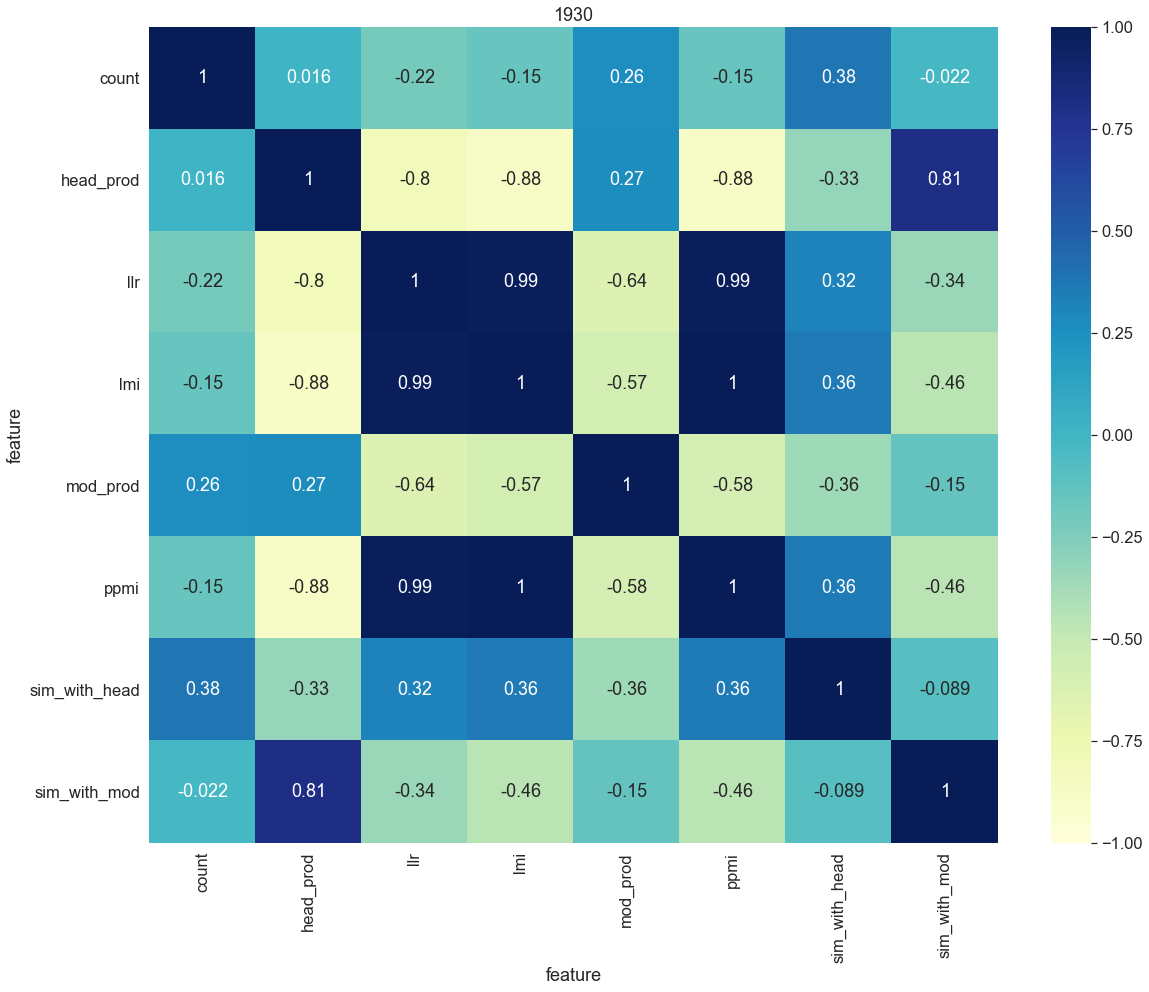

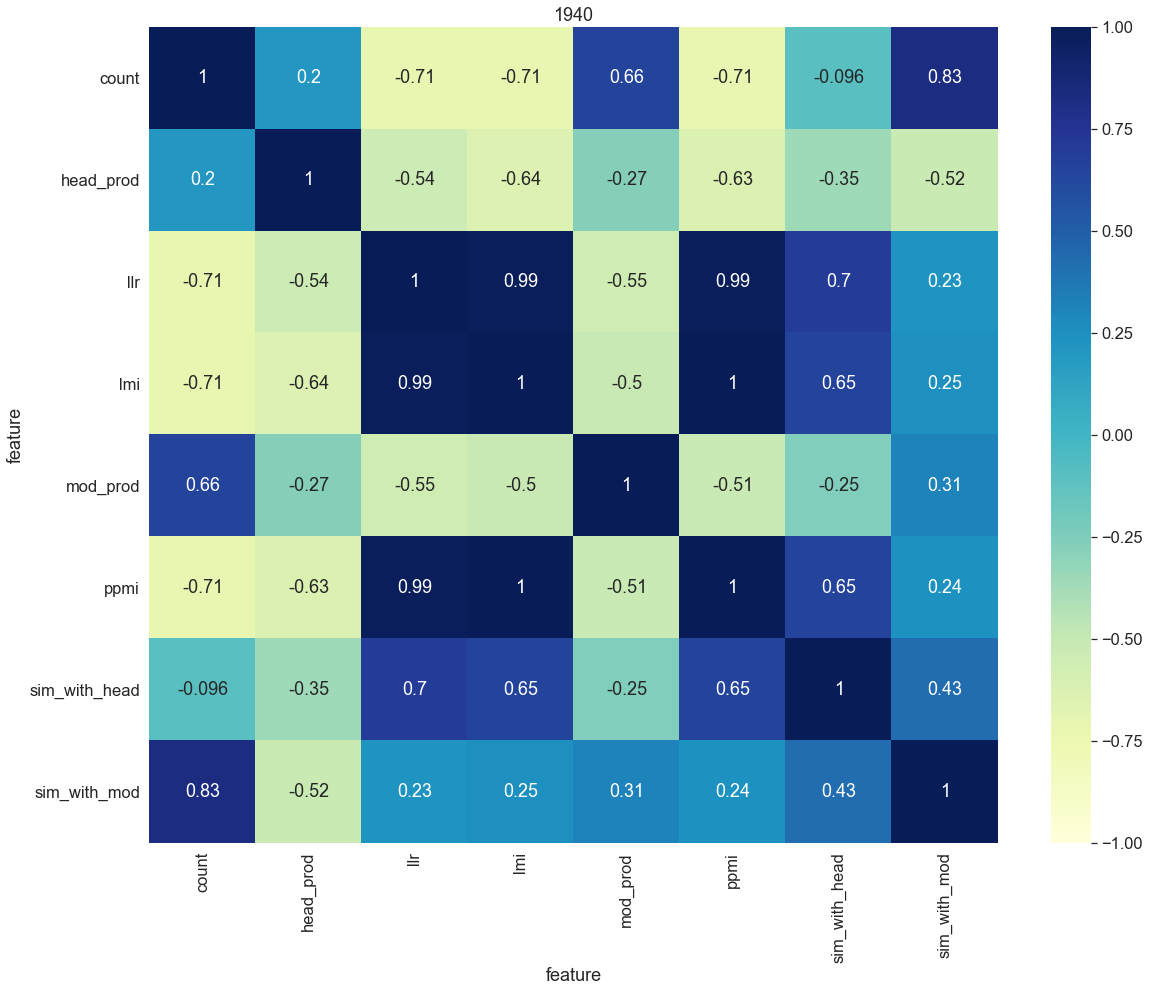

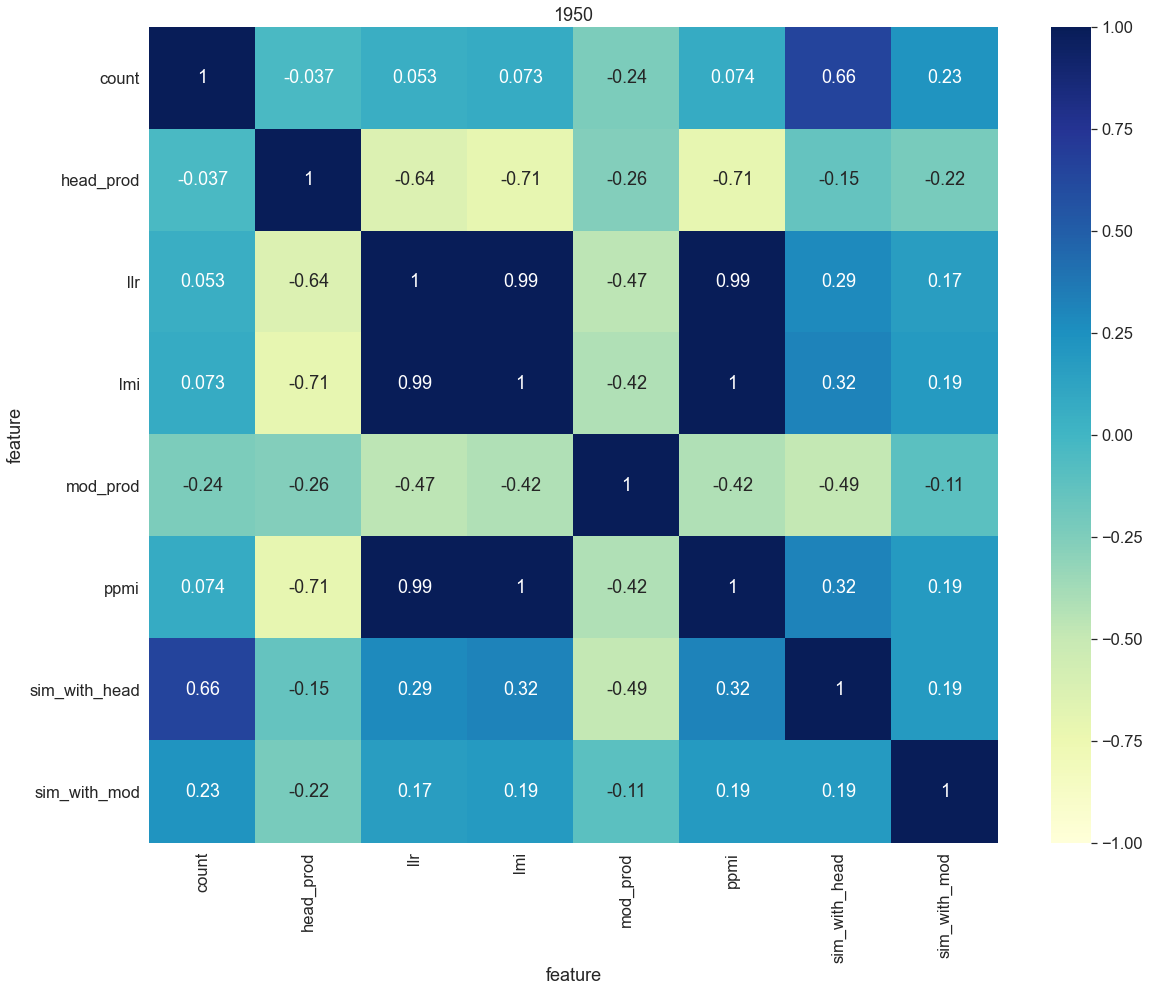

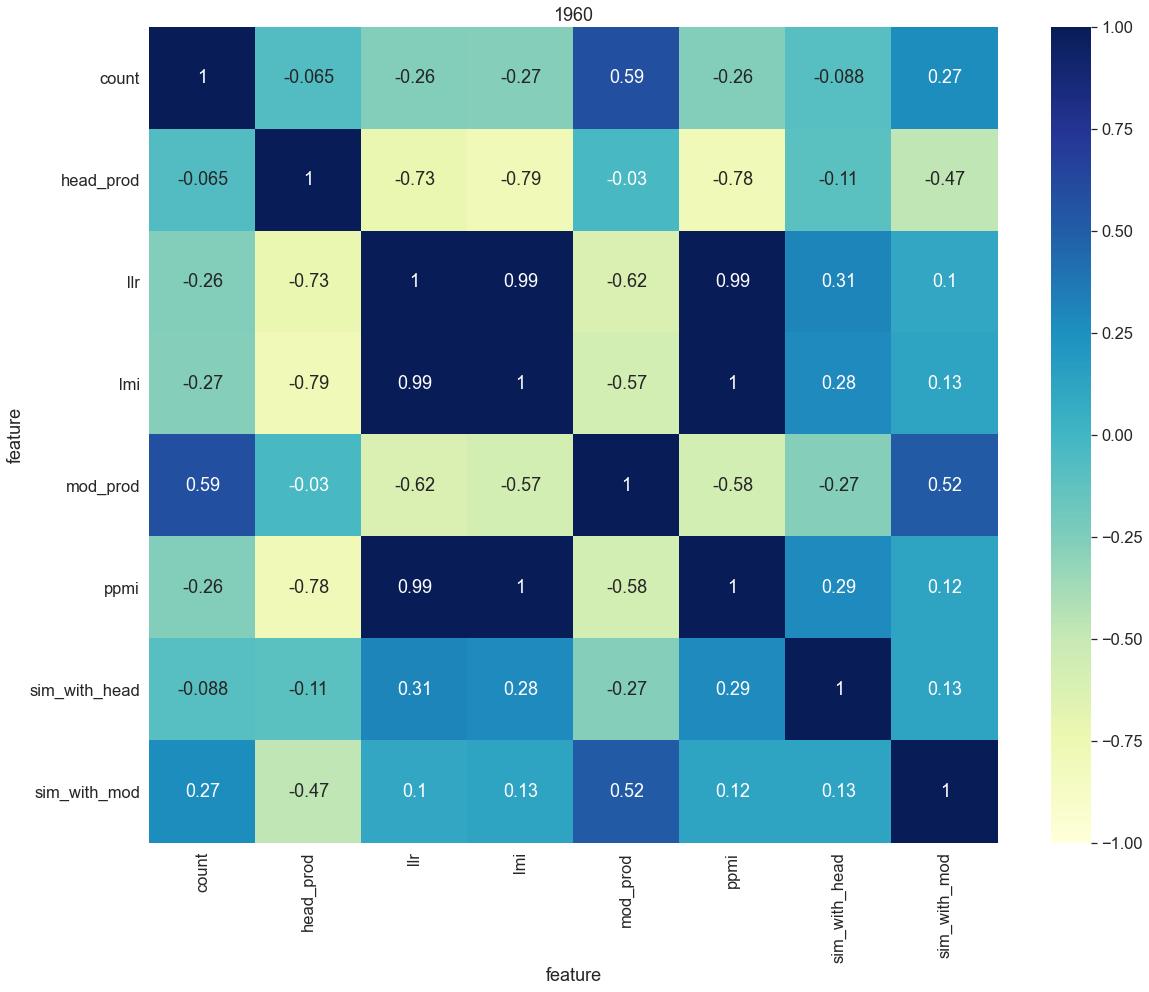

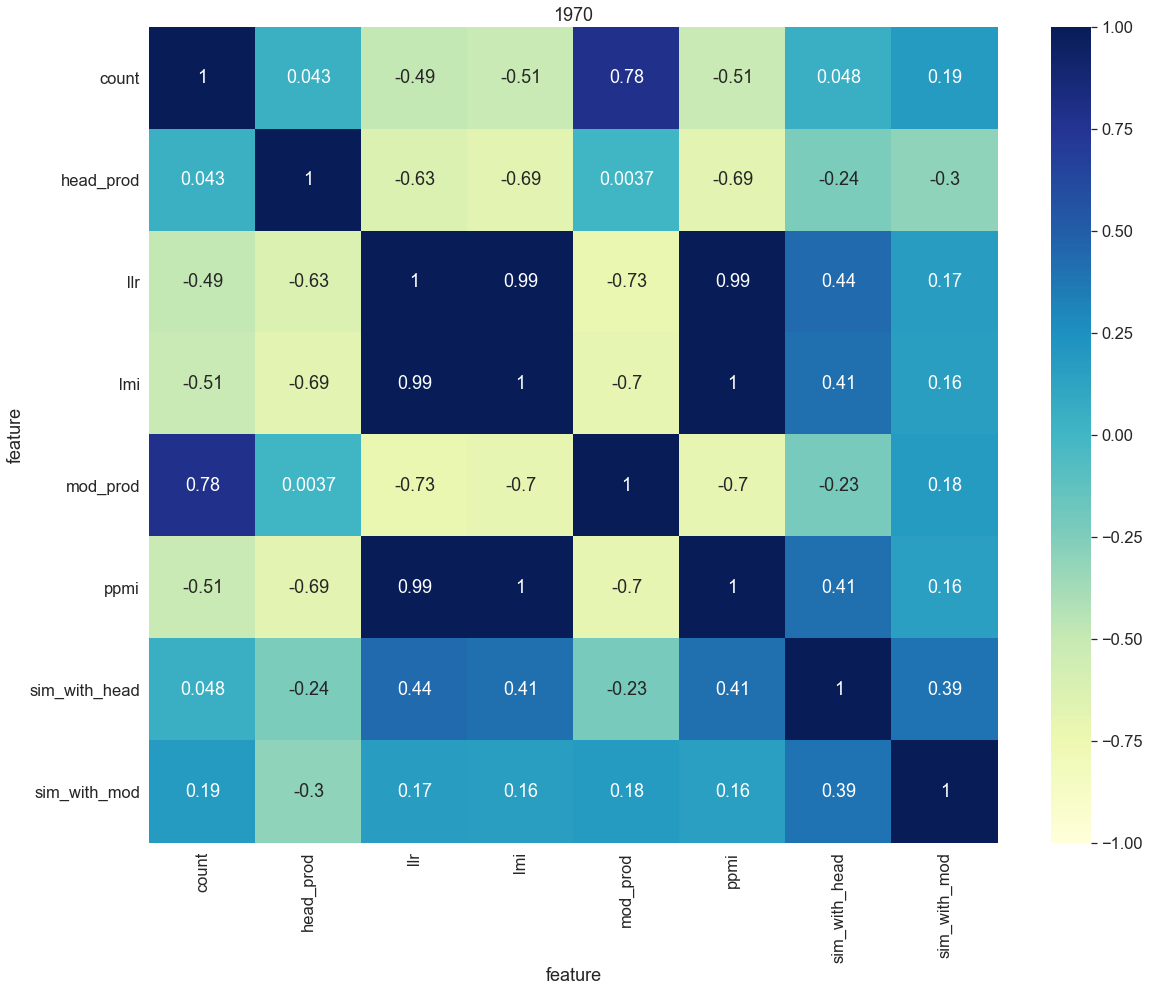

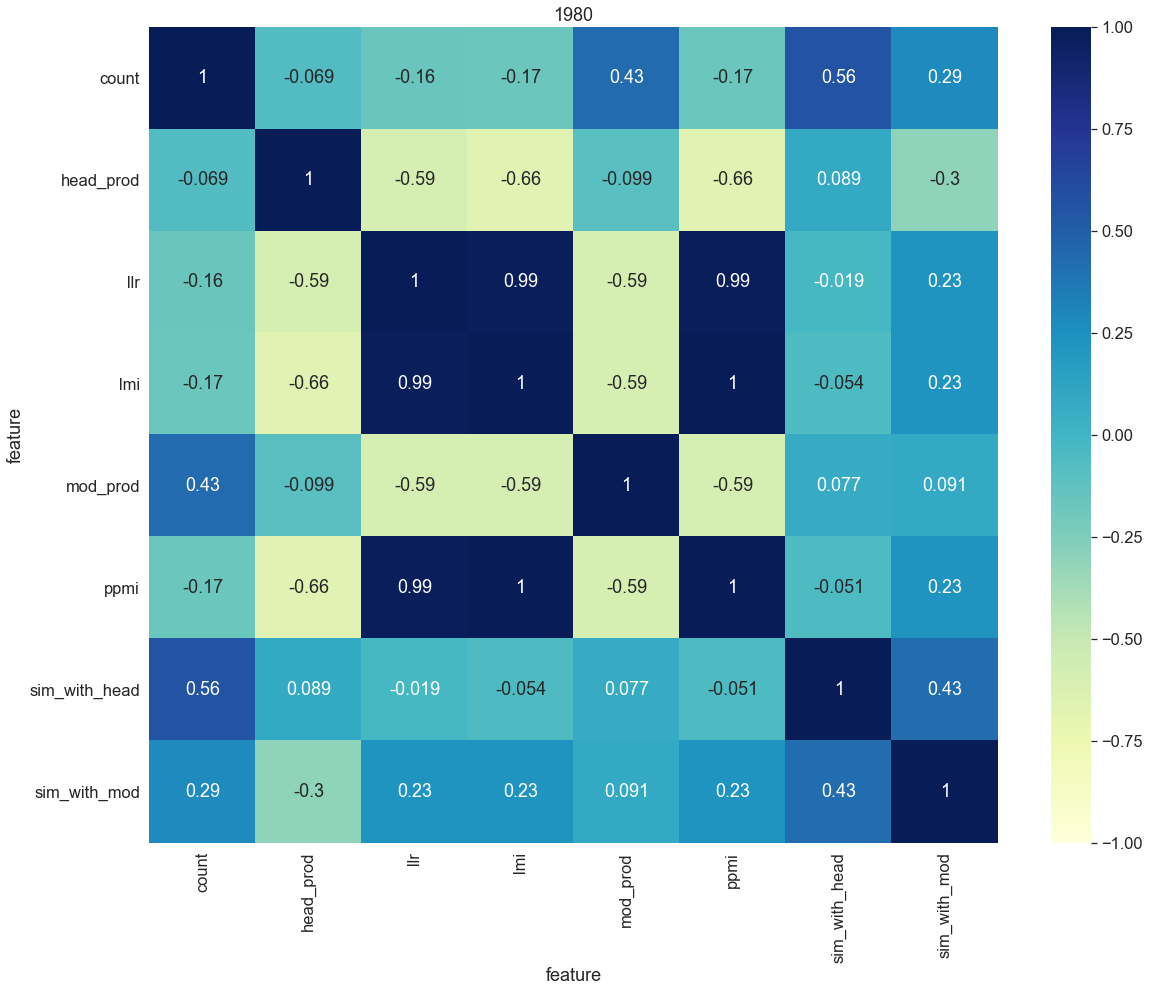

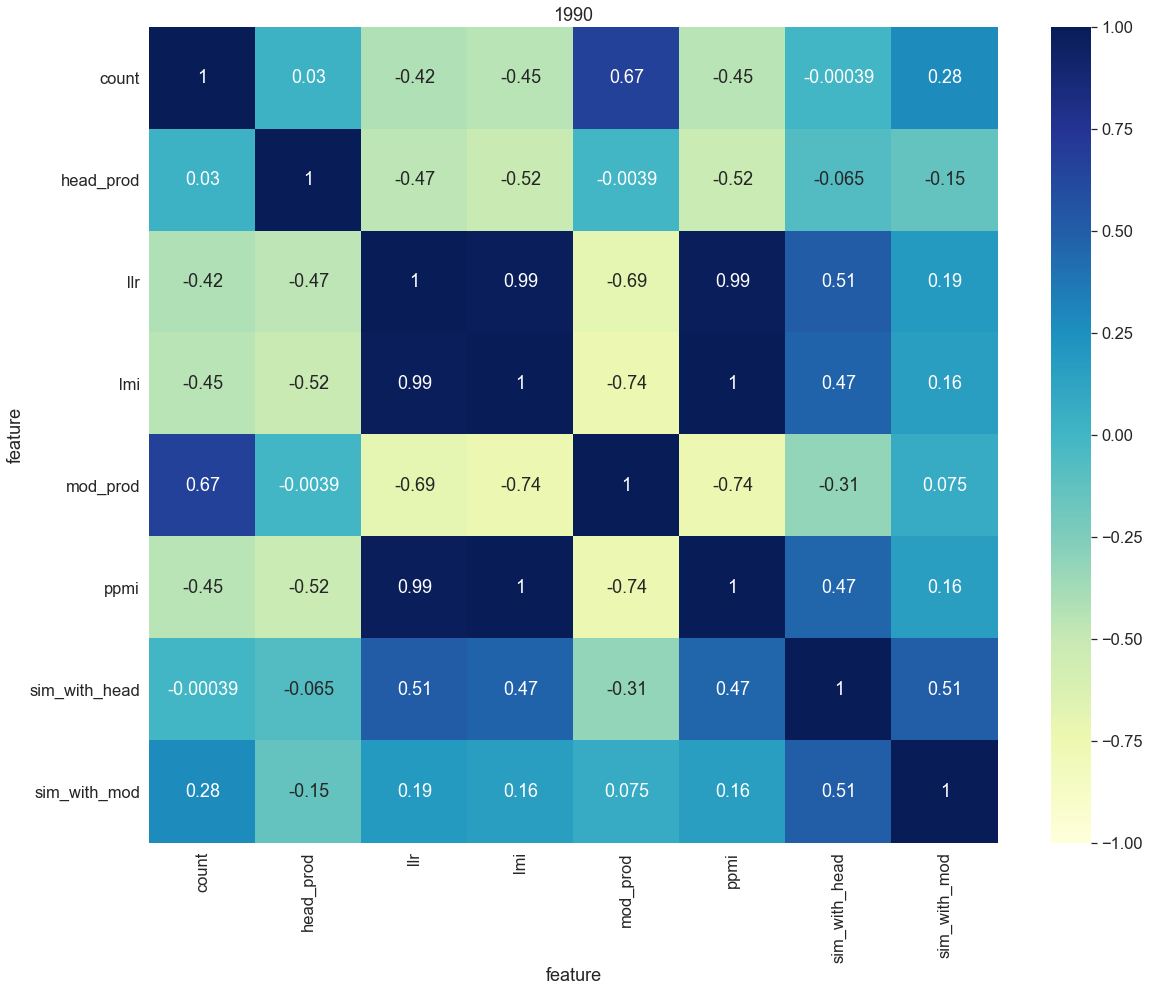

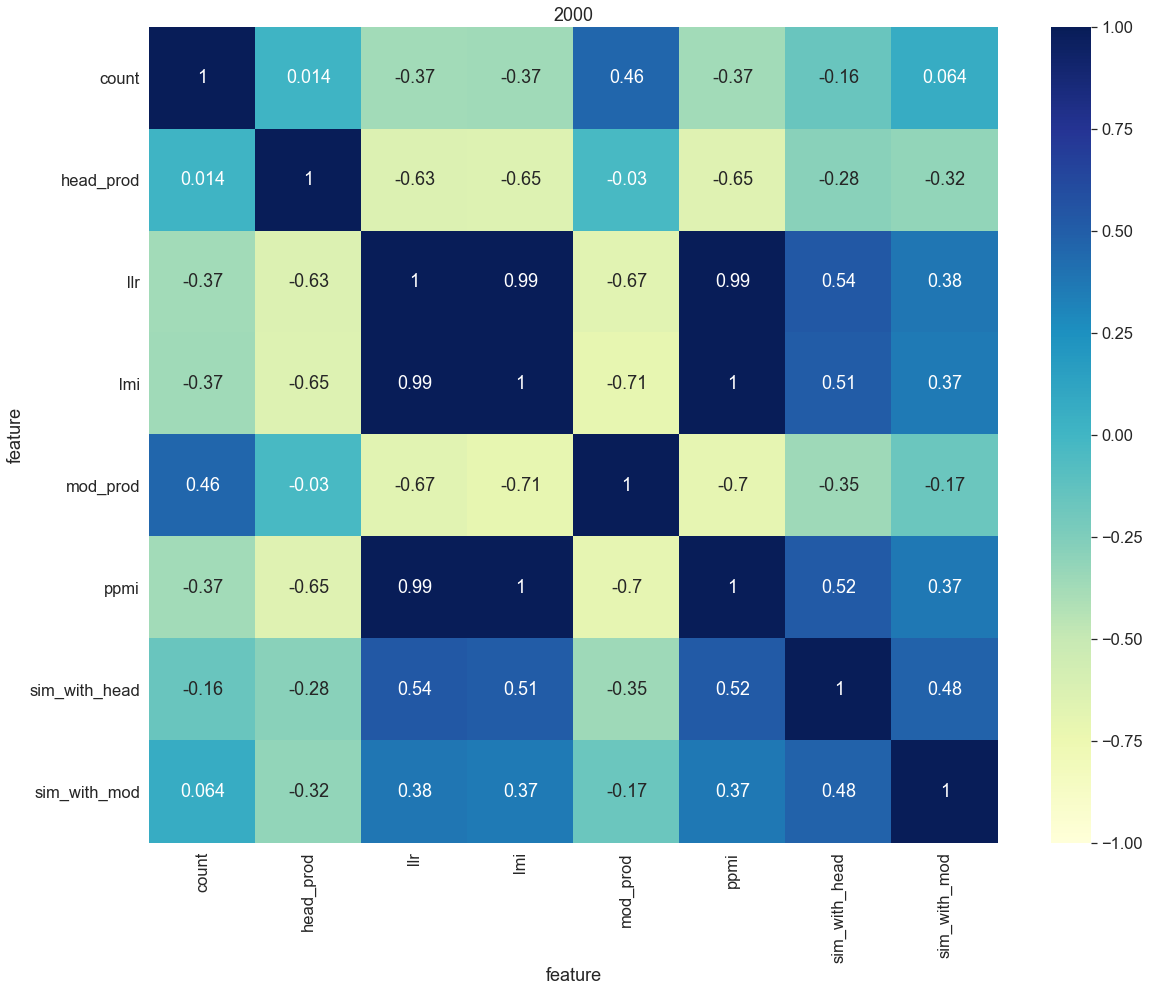

In [50]:
for year, new_df in corr_count_df.groupby(level=0):
    plt.figure(figsize=(19, 15))
    g = sns.heatmap(new_df.corr(), annot=True, vmin=-1, vmax=1, cmap="YlGnBu")
    g.set_title(year)
    plt.savefig(plotdir+'corr-{}_{}_{}_{}_{}.png'.format(year, mode, timespan, cutoff, dimension))
    if use_pgf:
        plt.savefig(plotdir+'corr-{}_{}_{}_{}_{}.pgf'.format(year, mode, timespan, cutoff, dimension))